## Instalaciones necesarias

In [1]:
#%pip install plotly kaleido 
#%pip install bokeh matplotlib seaborn 
#%pip install nbformat
#%pip install torchsummary 

## Librerías

In [2]:
# Importar librerías necesarias
import os
import pandas as pd
import numpy as np
import torch
import torchvision
from torchvision import transforms
from PIL import Image # Para abrir y examinar imágenes
import matplotlib.pyplot as plt
import seaborn as sns # Para visualizaciones de datos

from sklearn.model_selection import train_test_split

# Importar el módulo de redes neuronales de PyTorch
import torch.nn as nn
import torch.nn.functional as F # Para funciones de activación, pooling, etc.
from torchsummary import summary

# Importar librerías necesarias
import torch.nn as nn
import torch.optim as optim
import time
import os
import gc
import copy # Para copiar el mejor modelo/estado

# Importar librería Optuna
import optuna

import plotly.graph_objects as go
import optuna.visualization as vis

# Importar librerías necesarias para evaluación
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torchvision
from PIL import Image # Para visualización

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## Configuración

In [3]:
# Selección de Dispositivo (CPU/GPU)
# Selecciona el dispositivo PyTorch. Prioriza CUDA (GPU NVIDIA) si está disponible.
# Es crucial mover modelos y tensores a este dispositivo para aprovechar la GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo seleccionado: {device}")
if device.type == 'cuda':
    print(f"Nombre de la GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memoria total de la GPU: {torch.cuda.get_device_properties(0).total_memory / (1024**2):.2f} MB") # Mostrar VRAM total
    # Limpiar caché de VRAM al inicio si es necesario (útil si re-ejecutas celdas)
    torch.cuda.empty_cache()
    print("Caché de VRAM limpiado.")

Dispositivo seleccionado: cuda
Nombre de la GPU: NVIDIA GeForce RTX 4060 Laptop GPU
Memoria total de la GPU: 8187.50 MB
Caché de VRAM limpiado.


In [4]:
# Definición de Rutas
# Define las rutas a los datos.
BASE_DATA_PATH = './Datos/'
CSV_FILE_PATH = os.path.join(BASE_DATA_PATH, 'train.csv')
IMAGE_DIR_PATH = os.path.join(BASE_DATA_PATH, 'images', 'images') # Ruta al directorio que CONTIENE las imágenes

print(f"\nRuta al archivo CSV: {CSV_FILE_PATH}")
print(f"Ruta al directorio de imágenes: {IMAGE_DIR_PATH}")

# Verificar si las rutas existen
if not os.path.exists(CSV_FILE_PATH):
    raise FileNotFoundError(f"El archivo CSV no se encontró en: {CSV_FILE_PATH}")
if not os.path.exists(IMAGE_DIR_PATH):
    raise FileNotFoundError(f"El directorio de imágenes no se encontró en: {IMAGE_DIR_PATH}")
print("Rutas verificadas. Archivos encontrados.")


Ruta al archivo CSV: ./Datos/train.csv
Ruta al directorio de imágenes: ./Datos/images\images
Rutas verificadas. Archivos encontrados.


## Análisis Exploratorio de Datos (EDA)

Para el entrenamiento del modelo personalizado, optamos por aplicar un balanceo en el conjunto de datos. Esta decisión se tomó luego de observar que, tras varias pruebas, el modelo no lograba superar un 60% de precisión (accuracy), lo cual indicaba un posible desbalance en las clases que afectaba negativamente el rendimiento del modelo.

In [5]:
df_train = pd.read_csv(CSV_FILE_PATH)
print("\nDataFrame cargado exitosamente.")
print("Primeras 5 filas del DataFrame:")
print(df_train.head())
print("\nInformación del DataFrame:")
df_train.info()


DataFrame cargado exitosamente.
Primeras 5 filas del DataFrame:
           filename    class   xmin   ymin   xmax   ymax  object_count  \
0  image_00373.jpeg   cougar  506.0  303.0  628.0  414.0           1.0   
1  image_00065.jpeg  seahawk  381.0   35.0  856.0  273.0           1.0   
2  image_00111.jpeg   cougar  467.0  136.0  830.0  302.0           1.0   
3  image_00112.jpeg   cougar  447.0  122.0  799.0  287.0           1.0   
4  image_00113.jpeg   cougar  418.0  141.0  631.0  291.0           1.0   

       type  
0  original  
1  original  
2  original  
3  original  
4  original  

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   filename      300 non-null    object 
 1   class         300 non-null    object 
 2   xmin          189 non-null    float64
 3   ymin          189 non-null    float64
 4   xmax       

In [6]:
print("\nEstadísticas descriptivas de las clases:")
print(df_train['class'].describe())


Estadísticas descriptivas de las clases:
count        300
unique         6
top       cougar
freq          50
Name: class, dtype: object


In [7]:
class_counts = df_train['class'].value_counts()
print("\nConteo de instancias por clase:")
print(class_counts)



Conteo de instancias por clase:
class
cougar     50
seahawk    50
ah64       50
f16        50
f15        50
chinook    50
Name: count, dtype: int64


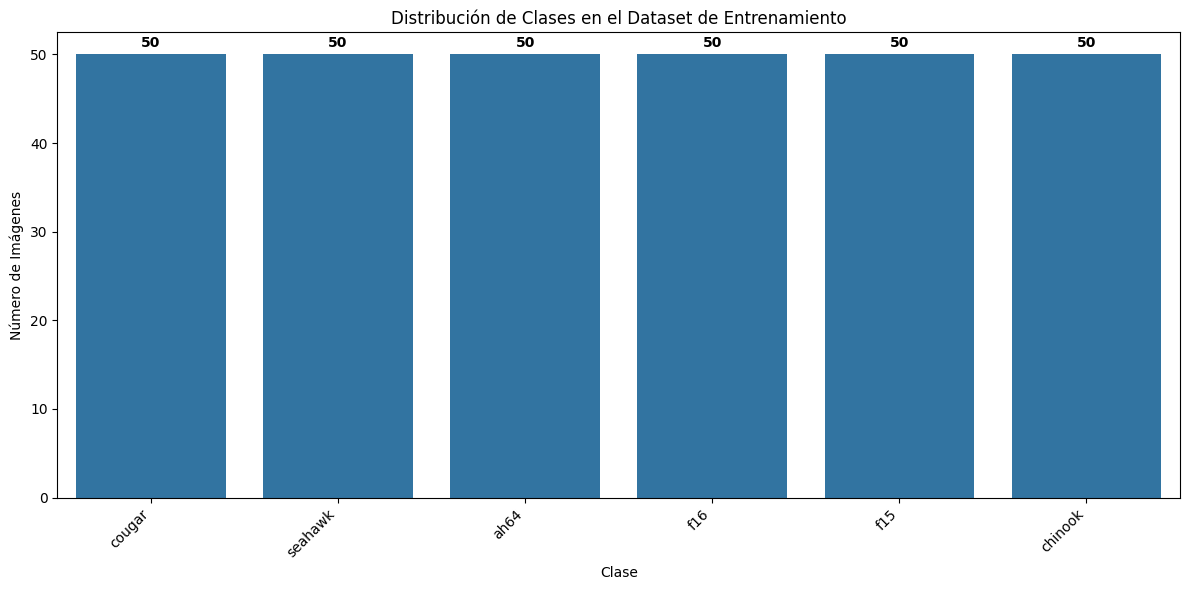

In [8]:
# Visualización del balance de clases
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=class_counts.index, y=class_counts.values) # Store the axes object
plt.title('Distribución de Clases en el Dataset de Entrenamiento')
plt.xlabel('Clase')
plt.ylabel('Número de Imágenes')
plt.xticks(rotation=45, ha='right') # Rotar etiquetas del eje x si hay muchas clases

# Mostrar los valores del numero de imagenes en cada una de las barras
for i, v in enumerate(class_counts.values):
    ax.text(i, v + 0.5, str(v), color='black', ha='center', va='bottom', fontweight='bold')

plt.tight_layout() # Ajustar layout para que las etiquetas no se corten
plt.show()

In [9]:
# Determinar el número de clases y mapeos (índice <-> clase)
unique_classes = sorted(df_train['class'].unique())
num_classes = len(unique_classes)
class_to_idx = {cls_name: i for i, cls_name in enumerate(unique_classes)}
idx_to_class = {i: cls_name for cls_name, i in class_to_idx.items()}

print(f"\nNúmero total de clases únicas: {num_classes}")
print(f"Mapeo Clase a Índice: {class_to_idx}")
print(f"Mapeo Índice a Clase: {idx_to_class}")


Número total de clases únicas: 6
Mapeo Clase a Índice: {'ah64': 0, 'chinook': 1, 'cougar': 2, 'f15': 3, 'f16': 4, 'seahawk': 5}
Mapeo Índice a Clase: {0: 'ah64', 1: 'chinook', 2: 'cougar', 3: 'f15', 4: 'f16', 5: 'seahawk'}


## Parametros

In [10]:
# Definir el tamaño del lote (Batch Size). CRUCIAL para el uso de VRAM.
# Un tamaño más grande puede acelerar el entrenamiento pero consume más VRAM.
# Ajusta este valor según la memoria de tu GPU (8GB es limitado, empieza con 32 o 64).

# num_workers: Número de subprocesos para cargar datos. 0 significa que la carga es en el hilo principal.
# Para un notebook simple o depuración, 0 es aceptable. Para rendimiento en entrenamiento, usar > 0 es mejor,
# pero puede causar problemas en algunos entornos Jupyter (especialmente en Windows).
# Empieza con 0 y aumenta si necesitas más velocidad de carga.

BATCH_SIZE = 32 
IMG_HEIGHT, IMG_WIDTH = 255, 400
NUM_WORKERS = 0 

print(f"\nTamaño seleccionado para redimensionamiento: {IMG_HEIGHT}x{IMG_WIDTH} (Height x Width)")


Tamaño seleccionado para redimensionamiento: 255x400 (Height x Width)


Este tamaño seleccionado se debe a que es el mismo tamano de imagen que usaremos como backbone en la transferencia de conocimiento

## Preprocesamiento de Datos y Creación de DataLoaders

### División de dataframes

In [11]:
# Primero, dividir en train (70%) y temp (30%)
df_train_split, df_temp = train_test_split(
    df_train,
    test_size=0.3, # 30% para temp (val + test)
    random_state=42, # Para reproducibilidad
    stratify=df_train['class'] # Estratificar por clase para mantener el balance
)

# Luego, dividir temp (30%) en validación (15%) y prueba (15%)
# test_size=0.5 porque es 0.5 del 30% original, lo que da 15% del total
df_val_split, df_test_split = train_test_split(
    df_temp,
    test_size=0.5, # 50% de temp para test (10% del total)
    random_state=42, # Para reproducibilidad
    stratify=df_temp['class'] # Estratificar nuevamente
)

print(f"\nDimensiones de los DataFrames divididos:")
print(f"  Entrenamiento: {df_train_split.shape}")
print(f"  Validación: {df_val_split.shape}")
print(f"  Prueba: {df_test_split.shape}")


Dimensiones de los DataFrames divididos:
  Entrenamiento: (210, 8)
  Validación: (45, 8)
  Prueba: (45, 8)


In [12]:
# Creación de un Dataset Personalizado
class CustomImageDataset(torch.utils.data.Dataset):
    """Dataset personalizado para cargar imágenes desde un DataFrame y aplicar transformaciones."""

    def __init__(self, dataframe, img_dir, class_to_idx, transform=None):
        """
        Inicializa el Dataset.
        Args:
            dataframe (pandas.DataFrame): DataFrame con 'filename' y 'class'.
            img_dir (str): Directorio donde se encuentran todas las imágenes.
            class_to_idx (dict): Mapeo de nombres de clase a índices.
            transform (callable, optional): Transformaciones a aplicar.
        """
        self.img_labels = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.class_to_idx = class_to_idx
        # Mapear las etiquetas de clase de string a índice numérico
        self.label_indices = [self.class_to_idx[label] for label in self.img_labels['class']]

    def __len__(self):
        """Devuelve el número total de muestras en el dataset."""
        return len(self.img_labels)

    def __getitem__(self, idx):
        """
        Carga una muestra individual (imagen y etiqueta) por índice.
        Args:
            idx (int): Índice de la muestra.
        Returns:
            tuple: (imagen (Tensor), etiqueta (Tensor))
        """
        # Construir la ruta completa de la imagen
        img_name = self.img_labels.iloc[idx, 0] # Asumiendo 'filename' es la primera columna
        img_path = os.path.join(self.img_dir, img_name)

        try:
            # Abrir la imagen
            image = Image.open(img_path).convert('RGB') # Asegurar 3 canales RGB

            # Obtener la etiqueta y convertirla a tensor
            # label_name = self.img_labels.iloc[idx, 1] # Asumiendo 'class' es la segunda columna
            # label = torch.tensor(self.class_to_idx[label_name], dtype=torch.long)
            # Ya pre-calculamos los índices en __init__ para mayor eficiencia
            label = torch.tensor(self.label_indices[idx], dtype=torch.long)

            # Aplicar transformaciones si existen
            if self.transform:
                image = self.transform(image)

            return image, label

        except FileNotFoundError:
             print(f"Advertencia: Imagen no encontrada, saltando: {img_path}")
             return None, None 

        except Exception as e:
            print(f"Error al cargar o transformar la imagen {img_path}: {e}, saltando.")
            return None, None


print("Clase CustomImageDataset definida.")

Clase CustomImageDataset definida.


In [13]:
#Calculo de media y desviación estándar de los valores RGB de las imágenes

# Solo convierte a tensor (0–255 → 0–1), sin normalizar aún
base_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor()
])

dataset = CustomImageDataset(
    dataframe=df_train,
    img_dir=IMAGE_DIR_PATH,
    class_to_idx=class_to_idx,
    transform=base_transform
)
loader  = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Acumular sumas y sumas de cuadrados
n_images = 0
sum_channels = torch.zeros(3)
sum_sq_channels = torch.zeros(3)

for imgs, _ in loader:
    n_batch = imgs.size(0)
    # imgs: [batch, 3, H, W]
    imgs = imgs.view(n_batch, 3, -1)  # [batch, 3, H*W]
    sum_channels += imgs.mean(dim=[0,2]) * n_batch
    sum_sq_channels += (imgs ** 2).mean(dim=[0,2]) * n_batch
    n_images += n_batch

# Media por canal
mean = sum_channels / n_images
# Varianza y luego std
var  = sum_sq_channels / n_images - mean**2
std  = torch.sqrt(var)

mean_list = mean.tolist()
std_list = std.tolist()

print("mean =", mean_list)
print("std  =", std_list)

mean = [0.528589129447937, 0.5788546204566956, 0.6231197714805603]
std  = [0.24197205901145935, 0.24344542622566223, 0.27202919125556946]


In [14]:
# Definición de Transformaciones de Preprocesamiento Estándar
# Estas transformaciones se aplicarán a los conjuntos de validación y prueba.

# Definir las transformaciones básicas: redimensionar, convertir a tensor, normalizar.
# La normalización utiliza la media y desviación estándar calculadas anteriormente.
# Para mayor precisión, deberías calcular la media/std de TU dataset de entrenamiento.
standard_transforms = transforms.Compose([    
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),    
    transforms.ToTensor(),    
    transforms.Normalize(mean=mean_list, std=std_list)
])

### Instanciación de Datasets

In [15]:
# Creamos instancias de nuestro Dataset para cada conjunto (train, val, test).
# Nota: train_dataset usará standard_transforms por ahora. Se actualizará más adelante.
train_dataset = CustomImageDataset(
    dataframe=df_train_split,
    img_dir=IMAGE_DIR_PATH,
    class_to_idx=class_to_idx,
    transform=standard_transforms # Usamos standard por ahora
)

val_dataset = CustomImageDataset(
    dataframe=df_val_split,
    img_dir=IMAGE_DIR_PATH,
    class_to_idx=class_to_idx,
    transform=standard_transforms # Validación usa transformaciones estándar (sin aumento)
)

test_dataset = CustomImageDataset(
    dataframe=df_test_split,
    img_dir=IMAGE_DIR_PATH,
    class_to_idx=class_to_idx,
    transform=standard_transforms # Prueba usa transformaciones estándar (sin aumento)
)

print(f"\nDatasets instanciados:")
print(f"  Entrenamiento: {len(train_dataset)} muestras")
print(f"  Validación: {len(val_dataset)} muestras")
print(f"  Prueba: {len(test_dataset)} muestras")



Datasets instanciados:
  Entrenamiento: 210 muestras
  Validación: 45 muestras
  Prueba: 45 muestras


### Batch Size

In [16]:
print(f"\nConfiguración de DataLoaders:")
print(f"  Tamaño del lote (BATCH_SIZE): {BATCH_SIZE}")
print(f"  Número de workers (NUM_WORKERS): {NUM_WORKERS}")


Configuración de DataLoaders:
  Tamaño del lote (BATCH_SIZE): 32
  Número de workers (NUM_WORKERS): 0


### Creación de DataLoaders

In [17]:
# 5. Creación de DataLoaders
# Los DataLoaders permiten iterar sobre el dataset en lotes y manejar el multi-threading para la carga.
print(f'Dispositivo seleccionado:{device.type}')
# Instanciar los DataLoaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, # Importante para entrenamiento: barajar los datos en cada época
    num_workers=NUM_WORKERS,
    pin_memory=True if device.type == 'cuda' else False # Copia datos a la memoria fija del host, útil para GPU
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # No es necesario barajar la validación
    num_workers=NUM_WORKERS,
    pin_memory=True if device.type == 'cuda' else False
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # No es necesario barajar la prueba
    num_workers=NUM_WORKERS,
    pin_memory=True if device.type == 'cuda' else False
)

print("\nDataLoaders creados: train_loader, val_loader, test_loader")

Dispositivo seleccionado:cuda

DataLoaders creados: train_loader, val_loader, test_loader


In [18]:
# Verificación Rápida de un Lote
# Tomamos un lote de ejemplo para verificar las dimensiones y el dispositivo
try:
    # Obtener un iterador para el DataLoader
    data_iter = iter(train_loader)
    # Obtener el primer lote
    images, labels = next(data_iter)

    print(f"\nVerificación de un lote del train_loader:")
    print(f"  Dimensiones de las imágenes en el lote: {images.shape}") # Esperado: [BATCH_SIZE, Canales, Altura, Ancho]
    print(f"  Tipo de dato de las imágenes: {images.dtype}")
    print(f"  Dimensiones de las etiquetas en el lote: {labels.shape}") # Esperado: [BATCH_SIZE]
    print(f"  Tipo de dato de las etiquetas: {labels.dtype}")
    print(f"  Valores de las primeras 10 etiquetas: {labels[:10]}")
    print(f"  Rango de valores de píxeles (normalizados): min={images.min().item():.4f}, max={images.max().item():.4f}")

    # Mover un lote al dispositivo seleccionado (GPU si es posible) para probar
    images = images.to(device)
    labels = labels.to(device)
    print(f"  Dispositivo de las imágenes después de mover: {images.device}")
    print(f"  Dispositivo de las etiquetas después de mover: {labels.device}")

    # Liberar tensores de prueba para no consumir VRAM innecesariamente
    del images, labels
    # Limpiar caché de VRAM
    if device.type == 'cuda':
        torch.cuda.empty_cache()
    print("Lote de prueba cargado y verificado. Tensores liberados.")

except Exception as e:
    print(f"\nError al intentar cargar un lote de prueba: {e}")
    print("Asegúrate de que las rutas y el DataFrame son correctos y que hay imágenes válidas.")


# Limpieza de memoria 
import gc
gc.collect()
if device.type == 'cuda':
    torch.cuda.empty_cache()



Verificación de un lote del train_loader:
  Dimensiones de las imágenes en el lote: torch.Size([32, 3, 255, 400])
  Tipo de dato de las imágenes: torch.float32
  Dimensiones de las etiquetas en el lote: torch.Size([32])
  Tipo de dato de las etiquetas: torch.int64
  Valores de las primeras 10 etiquetas: tensor([5, 0, 2, 3, 3, 5, 5, 1, 3, 2])
  Rango de valores de píxeles (normalizados): min=-2.3778, max=1.9482
  Dispositivo de las imágenes después de mover: cuda:0
  Dispositivo de las etiquetas después de mover: cuda:0
Lote de prueba cargado y verificado. Tensores liberados.


### Técnicas de Aumento de Datos (Data Augmentation)

In [19]:
print(f"\nUsando tamaño de imagen para augmentation: ({IMG_HEIGHT}x{IMG_WIDTH})")


Usando tamaño de imagen para augmentation: (255x400)


In [20]:
# Estas transformaciones incluyen el preprocesamiento estándar MÁS técnicas de aumento.

train_transforms = transforms.Compose([
    # Aumento: Recorta aleatoriamente y redimensiona a IMG_HEIGHT x IMG_WIDTH.
    # Scale es el rango del tamaño del recorte respecto al tamaño original.
    # Ratio es el rango de la relación de aspecto del recorte.
    transforms.RandomResizedCrop((IMG_HEIGHT, IMG_WIDTH), scale=(0.8, 1.0), ratio=(0.75, 1.33)),

    # Aumento: Voltea horizontalmente la imagen con una probabilidad p=0.5.
    transforms.RandomHorizontalFlip(p=0.5),

    # Aumento: Ajustes aleatorios de brillo, contraste, saturación y matiz.
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),

    # Aumento: Rotación aleatoria. Degrees es el rango de ángulos.
    transforms.RandomRotation(degrees=10),

    # Convertir a tensor (como en standard_transforms)
    transforms.ToTensor(),

    # Normalizar (como en standard_transforms) 
    transforms.Normalize(mean=mean_list, std=std_list)    
])

print("\nTransformaciones con aumento de datos para entrenamiento definidas.")

# Las transformaciones para validación y prueba siguen siendo las estándar sin aumento

# Re-instanciar el Dataset de Entrenamiento con las Nuevas Transformaciones
# Solo cambiamos el argumento 'transform'.
train_dataset = CustomImageDataset(
    dataframe=df_train_split, # Usamos el mismo split de entrenamiento del MÓDULO 2
    img_dir=IMAGE_DIR_PATH,
    class_to_idx=class_to_idx,
    transform=train_transforms # ¡Ahora usamos las transformaciones con aumento!
)

print(f"\nDataset de entrenamiento actualizado para usar aumento de datos: {len(train_dataset)} muestras.")
# Los datasets de validación y prueba (val_dataset, test_dataset) NO se modifican.

# Re-crear el DataLoader de Entrenamiento
# Re-creamos el DataLoader de entrenamiento usando el dataset actualizado.
# Mantenemos la misma configuración de BATCH_SIZE y NUM_WORKERS.
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, # Seguir barajando el conjunto de entrenamiento
    num_workers=NUM_WORKERS,
    pin_memory=True if device.type == 'cuda' else False # Copia a memoria fija del host, esto permite transferencias de datos más rápidas y eficientes a la GPU.
)

print(f"DataLoader de entrenamiento re-creado con BATCH_SIZE={BATCH_SIZE} y NUM_WORKERS={NUM_WORKERS}.")
# Los DataLoaders de validación y prueba (val_loader, test_loader) NO se modifican.


Transformaciones con aumento de datos para entrenamiento definidas.

Dataset de entrenamiento actualizado para usar aumento de datos: 210 muestras.
DataLoader de entrenamiento re-creado con BATCH_SIZE=32 y NUM_WORKERS=0.


### Visualización del Efecto del Aumento de Datos


Visualizando un lote de imágenes con aumento de datos (muestra)...


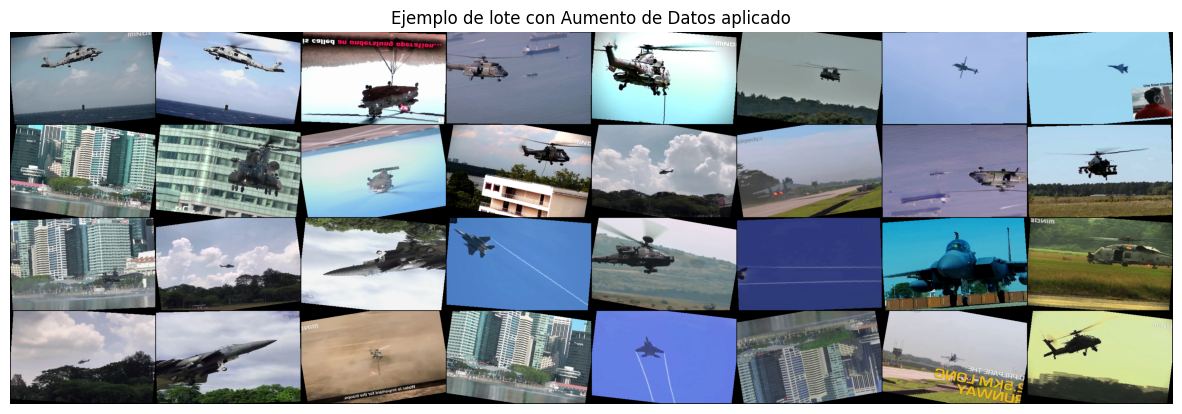

Etiquetas para el lote mostrado: [5, 5, 1, 2, 2, 1, 0, 3, 1, 1, 5, 2, 2, 3, 2, 0, 1, 2, 3, 3, 0, 3, 3, 5, 2, 3, 2, 1, 3, 1, 4, 0]
Visualización completada. Tensores liberados.


In [21]:

# Para entender visualmente qué hacen las transformaciones de aumento.
print("\nVisualizando un lote de imágenes con aumento de datos (muestra)...")
try:
    # Tomar un lote de ejemplo del NUEVO train_loader
    images, labels = next(iter(train_loader))

    # Las imágenes ya están normalizadas. Para visualizarlas correctamente,
    # necesitamos "de-normalizarlas" (aplicar la inversa de la normalización).
    # Media y Std usados para normalización (ImageNet)
    mean = torch.tensor(mean_list).view(1, 3, 1, 1) # (1, 3, 1, 1) para broadcasting
    std = torch.tensor(std_list).view(1, 3, 1, 1) # (1, 3, 1, 1) para broadcasting
    #mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    #std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

    # De-normalizar: imagen = imagen * std + media
    # Clonar para no modificar el tensor original que podríamos usar después
    images_display = images * std + mean
    images_display = torch.clamp(images_display, 0, 1) # Asegurar que los valores estén en [0, 1]

    # Usar make_grid para crear una cuadrícula de imágenes
    grid = torchvision.utils.make_grid(images_display, nrow=8, padding=2) # nrow: imágenes por fila

    # Convertir el tensor de la cuadrícula a formato (H, W, C) para matplotlib
    plt.figure(figsize=(15, (BATCH_SIZE // 8) * 2)) # Ajusta el tamaño de la figura
    plt.imshow(grid.permute(1, 2, 0)) # Permuta las dimensiones para (H, W, C)
    plt.title("Ejemplo de lote con Aumento de Datos aplicado")
    plt.axis('off') # Ocultar ejes
    plt.show()

    # Mostrar las etiquetas de este lote
    print(f"Etiquetas para el lote mostrado: {labels.tolist()}")
    # Opcionalmente, mapear a nombres de clase si quieres:
    # label_names = [idx_to_class[l.item()] for l in labels]
    # print(f"Nombres de clase: {label_names}")


    # Liberar tensores de visualización
    del images, labels, images_display, grid, mean, std
    if device.type == 'cuda':
        torch.cuda.empty_cache()
    print("Visualización completada. Tensores liberados.")

except Exception as e:
    print(f"\nError al intentar visualizar un lote con aumento de datos: {e}")
    print("Asegúrate de que el DataLoader funciona y matplotlib/torchvision están correctamente instalados.")


# Limpieza de memoria opcional
import gc
gc.collect()
if device.type == 'cuda':
    torch.cuda.empty_cache()

## Definición de la Arquitectura CNN

In [22]:
print(f"\nDispositivo para el modelo: {device}")
print(f"Número de clases para la capa de salida: {num_classes}")
# IMG_HEIGHT, IMG_WIDTH también son relevantes, aunque la arquitectura simple
# puede ser un poco agnóstica al tamaño exacto antes de las capas lineales.


Dispositivo para el modelo: cuda
Número de clases para la capa de salida: 6


In [39]:
# Definición de la Clase del Modelo CNN
# Heredamos de nn.Module, la clase base para todos los módulos de redes neuronales en PyTorch.

   # Para tunear el dropout, SimpleCNN(num_classes=num_classes, dropout_rate=dropout_rate)
    # y dentro de SimpleCNN.__init__ self.dropout = nn.Dropout(p=dropout_rate)

class SimpleCNN(nn.Module):
    """
    Una arquitectura CNN para clasificación de imágenes.
    Consiste en capas convolucionales seguidas de capas totalmente conectadas.
    """
    def __init__(self, num_classes, dropout_rate=0.5):
        """
        Inicializa el modelo CNN.
        Args:
            num_classes (int): El número de clases de salida para la capa final.
            dropout_rate (float): Tasa de dropout para regularización.
        """
        super(SimpleCNN, self).__init__() # Llamar al constructor de la clase base

        # Definir las capas convolucionales y de pooling
        # Conv2d(canales_entrada, canales_salida, tamaño_kernel, stride, padding)
        # MaxPool2d(tamaño_kernel, stride, padding)

        # Primera capa convolucional
        # Entrada: 3 canales (RGB), Tamaño: IMG_HEIGHT x IMG_WIDTH 
        # Salida: 16 canales
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)

        # nn.BatchNorm2d ayuda a estabilizar y acelerar el entrenamiento
        self.bn1 = nn.BatchNorm2d(16)

        # Max Pooling: reduce las dimensiones espaciales
        # Tamaño de salida después de conv1 y pool1: (H/2) x (W/2) con 16 canales
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Segunda capa convolucional
        # Entrada: 16 canales (salida de conv1/pool1)
        # Salida: 32 canales
        # Tamaño de salida después de conv2 y pool2: ((H/2)/2) x ((W/2)/2) = (H/4) x (W/4) con 32 canales
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Tercera capa convolucional
        # Entrada: 32 canales (salida de conv2/pool2)
        # Salida: 64 canales
        # Tamaño de salida después de conv3 y pool3: ((H/4)/2) x ((W/4)/2) = (H/8) x (W/8) con 64 canales
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)


        # Calcular el tamaño de la entrada a la primera capa lineal (Flatten)
        # Para un tamaño de entrada (H, W) y 3 capas con kernel_size=3, stride=1, padding=1, y pool_size=2, stride=2:
        # Tamaño de salida después de 3 pools es aproximadamente (H/8) x (W/8)        
        final_h = IMG_HEIGHT // 8
        final_w = IMG_WIDTH // 8
        linear_input_features = 64 * final_h * final_w # Canales_ultima_conv * Altura_final * Ancho_final
        print(f"Tamaño de entrada calculado para la capa lineal: {linear_input_features}")

        # Verificar que el tamaño de imagen es suficiente para 3 capas de pooling        
        if final_h < 1 or final_w < 1:
             raise ValueError(f"El tamaño de imagen ({IMG_HEIGHT}x{IMG_WIDTH}) es demasiado pequeño para 3 capas de pooling.")

        # Definir las capas totalmente conectadas (Fully Connected - FC)
        # La primera capa FC toma la salida aplanada de las capas convolucionales.
        self.fc1 = nn.Linear(in_features=linear_input_features, out_features=128)
        self.bn4 = nn.BatchNorm1d(128) # BatchNorm después de la lineal y antes de la activación

        # Capa de Dropout para regularización (ayuda a prevenir el sobreajuste)
        #self.dropout = nn.Dropout(p=0.5)
        self.dropout = nn.Dropout(p=dropout_rate) # Tasa de dropout ajustable
        # La capa final FC tiene el número de neuronas igual al número de clases.
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)


    def forward(self, x):
        """
        Define el pase hacia adelante (forward pass) del modelo.
        Define cómo los datos fluyen a través de las capas.
        """
        # Aplicar capas convolucionales, BatchNorm, activación ReLU y Pooling
        # (Canales_entrada, H, W) -> (Canales_salida_conv1, H/2, W/2)
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        # (Canales_salida_conv1, H/2, W/2) -> (Canales_salida_conv2, H/4, W/4)
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        # (Canales_salida_conv2, H/4, W/4) -> (Canales_salida_conv3, H/8, W/8)
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # Aplanar la salida de las capas convolucionales para pasarla a las capas FC
        # El "-1" en view() infiere automáticamente el tamaño del lote
        # x.size(0) es el tamaño del lote
        # x.view(x.size(0), -1) aplana cada imagen en el lote en un vector 1D
        # La dimensión aplanada es linear_input_features (calculada en __init__)
        x = x.view(x.size(0), -1) # Equivalentemente: x = torch.flatten(x, 1)

        # Aplicar capas totalmente conectadas con activación ReLU y Dropout
        # -> (Tamaño_lote, 128)
        x = F.relu(self.bn4(self.fc1(x)))
        x = self.dropout(x)
        # -> (Tamaño_lote, num_classes) - Salida final (logits antes de softmax)
        x = self.fc2(x)

        return x # La salida son los logits, no las probabilidades (la función de pérdida maneja softmax)


# Instanciación del Modelo
# Creamos una instancia de nuestra clase CNNModel.
# Le pasamos el número de clases determinado anteriormente.
# Esto crea un objeto modelo que contiene todas las capas definidas en la clase.
model = SimpleCNN(num_classes=num_classes)

print("\nInstancia del modelo SimpleCNN creada.")

# Mover el Modelo al Dispositivo Seleccionado (GPU si es posible)
model.to(device)

print(f"Modelo movido al dispositivo: {device}")

# Mostrar la Estructura del Modelo
print("\nEstructura del modelo:")
print(model)


Tamaño de entrada calculado para la capa lineal: 99200

Instancia del modelo SimpleCNN creada.
Modelo movido al dispositivo: cuda

Estructura del modelo:
SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=99200, out_features=128, bias=True)
  (bn4): BatchNo

In [24]:
# Se puede usar la librería 'torchsummary' para un resumen más detallado si está instalada:
# !pip install torchsummary 
try:    
    # summary(model, input_size=(Canales, Altura, Ancho))    
    print("\nResumen del modelo (con torchsummary):")
    summary(model, input_size=(3, IMG_HEIGHT, IMG_WIDTH))
except ImportError:
    print("\nInstala torchsummary (pip install torchsummary) para ver un resumen detallado del modelo.")
except Exception as e:
    print(f"\nError al generar resumen con torchsummary: {e}")
    print("Asegúrate de que el tamaño de entrada (3, IMG_HEIGHT, IMG_WIDTH) es correcto.")


Resumen del modelo (con torchsummary):
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 255, 400]             448
       BatchNorm2d-2         [-1, 16, 255, 400]              32
         MaxPool2d-3         [-1, 16, 127, 200]               0
            Conv2d-4         [-1, 32, 127, 200]           4,640
       BatchNorm2d-5         [-1, 32, 127, 200]              64
         MaxPool2d-6          [-1, 32, 63, 100]               0
            Conv2d-7          [-1, 64, 63, 100]          18,496
       BatchNorm2d-8          [-1, 64, 63, 100]             128
         MaxPool2d-9           [-1, 64, 31, 50]               0
           Linear-10                  [-1, 128]      12,697,728
      BatchNorm1d-11                  [-1, 128]             256
          Dropout-12                  [-1, 128]               0
           Linear-13                    [-1, 6]             774

In [25]:
# Limpieza de memoria 
gc.collect()
if device.type == 'cuda':
    torch.cuda.empty_cache()

## Entrenamiento para Optimización (Objective Function)

In [26]:
print(f"\nComponentes disponibles para la función objetivo:")
print(f"  Dispositivo: {device}")
print(f"  DataLoaders: train_loader ({len(train_loader.dataset)} muestras), val_loader ({len(val_loader.dataset)} muestras)")
print(f"  Número de clases: {num_classes}")
print(f"  Clase del modelo: {SimpleCNN.__name__}") # Verificamos que la clase SimpleCNN está definida


Componentes disponibles para la función objetivo:
  Dispositivo: cuda
  DataLoaders: train_loader (210 muestras), val_loader (45 muestras)
  Número de clases: 6
  Clase del modelo: SimpleCNN


In [27]:
n_trials = 200 # 10 Número de pruebas (combinaciones de HPs) a intentar. 
num_epochs_trial = 100 # Número de épocas para cada prueba.               
patience = 50 # Paciencia para Early Stopping DENTRO de cada prueba de Optuna

In [ ]:
# Definición de la Función de Entrenamiento para Optimización (Objective Function)

# Definición de la Función Objetivo para Optuna
def objective(trial, train_loader, val_loader, device, num_classes, checkpoint_dir='./optuna_checkpoints'):
    """
    Función objetivo para la optimización de hiperparámetros con Optuna.
    Entrena y valida un modelo con los hiperparámetros sugeridos por 'trial'.

    Args:
        trial (optuna.Trial): Objeto Trial proporcionado por Optuna para sugerir HPs y reportar métricas.
        train_loader (DataLoader): DataLoader para el conjunto de entrenamiento.
        val_loader (DataLoader): DataLoader para el conjunto de validación.
        device (torch.device): Dispositivo (CPU/GPU) para entrenar.
        num_classes (int): Número de clases de salida.
        checkpoint_dir (str): Directorio base para guardar checkpoints de las pruebas.

    Returns:
        float: La métrica de validación a maximizar (por ejemplo, precisión de validación).
              Optuna intenta maximizar/minimizar este valor.
    """
    print(f"\n--- Iniciando Prueba Optuna #{trial.number} de {num_epochs_trial} ---")

    # --- Sugerir Hiperparámetros ---
    # Optuna llama a trial.suggest_... para obtener un valor para un hiperparámetro.
    # El nombre (ej. 'learning_rate') identifica el hiperparámetro.
    # Los argumentos siguientes definen el rango o las opciones a explorar.

    # Tasa de aprendizaje (escala logarítmica es común para LR)
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)

    # Factor de weight decay (regularización L2)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    # Tasa de dropout
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.8) # Rango entre 20% y 80%

    # Elección del optimizador 
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])

    # Si el optimizador es SGD, sugerir un valor de momentum
    # (momentum es un hiperparámetro común para SGD, no para Adam)
    momentum = trial.suggest_float("momentum", 0.8, 0.99) if optimizer_name == "SGD" else None

    print(f"  Hiperparámetros sugeridos:")
    print(f"    Learning Rate: {lr:.6f}")
    print(f"    Weight Decay: {weight_decay:.6f}")
    print(f"    Dropout Rate: {dropout_rate:.2f}")
    if optimizer_name == "SGD": print(f"    Optimizer: {optimizer_name}, Momentum: {momentum:.2f}")
    else: print(f"    Optimizer: {optimizer_name}")


    # --- Configurar Modelo, Función de Pérdida y Optimizador ---
    # Re-instanciar el modelo para cada prueba para asegurar un estado limpio    
    model = SimpleCNN(num_classes=num_classes) # Re-instanciar

    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.p = dropout_rate # Ajusta la tasa de dropout sugerida por Optuna
            print(f"    Ajustada tasa de dropout en el modelo a: {dropout_rate:.2f}")


    model.to(device) # Mover el modelo al dispositivo

    criterion = nn.CrossEntropyLoss() # Función de pérdida 

    # Configurar el optimizador con los HPs sugeridos
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
         optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    # --- Bucle de Entrenamiento y Validación  ---    
    epochs_since_last_improvement = 0
    best_val_loss = float('inf') # Inicializar la mejor pérdida de validación

    # Para guardar el estado del mejor modelo *de esta prueba*
    best_model_state = None
    best_optimizer_state = None    

    for epoch in range(num_epochs_trial):
        
        print(f"\nTrial {trial.number} Época {epoch+1}/{num_epochs_trial}:")
        # Entrenamiento
        model.train()
        running_train_loss = 0.0
        correct_train_preds = 0
        total_train_preds = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train_preds += labels.size(0)
            correct_train_preds += (predicted == labels).sum().item()

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        epoch_train_accuracy = 100 * correct_train_preds / total_train_preds        

        # Validación
        model.eval()
        running_val_loss = 0.0
        correct_val_preds = 0
        total_val_preds = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val_preds += labels.size(0)
                correct_val_preds += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_accuracy = 100 * correct_val_preds / total_val_preds

        print(f'epoch_train_loss: {epoch_train_loss:.4f}, epoch_train_accuracy: {epoch_train_accuracy:.2f}%')
        print(f'epoch_val_loss  : {epoch_val_loss:.4f}, epoch_val_accuracy  : {epoch_val_accuracy:.2f}%')

        # Checkpointing (dentro del trial) y Early Stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_since_last_improvement = 0
            # Guardar el estado del mejor modelo *de esta prueba*
            best_model_state = copy.deepcopy(model.state_dict())
            best_optimizer_state = copy.deepcopy(optimizer.state_dict())
            print(f"    Mejora en Prueba #{trial.number}, Época {epoch+1}. loss: {best_val_loss} Precisión: {epoch_val_accuracy:.2f}%") 

        else:
            epochs_since_last_improvement += 1
            print(f"    Sin mejora en Prueba #{trial.number}, Época {epoch+1}. Paciencia: {epochs_since_last_improvement}/{patience}") 

        # Reportar métrica intermedia a Optuna (puedes reportar pérdida, precisión, etc.)
        # Esto permite a Optuna podar (detener) pruebas que no parecen prometedoras.
        # Optuna espera la métrica que está optimizando.
        trial.report(epoch_val_loss, epoch)

        # Verificar si la prueba debe ser podada por Optuna
        if trial.should_prune():
            print(f"  Prueba #{trial.number} podada en la Época {epoch+1} (loss {epoch_val_loss} precisión {epoch_val_accuracy:.2f}%).")
            raise optuna.exceptions.TrialPruned()

        # Early Stopping Check (basado en la paciencia dentro de la prueba)
        if epochs_since_last_improvement >= patience:
            print(f"  Early stopping para Prueba #{trial.number}. No hubo mejora en {patience} épocas.")
            break # Salir del bucle de entrenamiento de la prueba

        # Limpieza de VRAM en cada época del trial
        if device.type == 'cuda':
             torch.cuda.empty_cache() 

    print(f"--- Prueba Optuna #{trial.number} Finalizada. Mejor loss de Validación: {best_val_loss} ---")
    
    trial_checkpoint_path = os.path.join(checkpoint_dir, f'trial_{trial.number}_best_checkpoint.pth')
    torch.save({
         'model_state_dict': best_model_state,
         'optimizer_state_dict': best_optimizer_state, 
         'best_val_loss': best_val_loss,         
         'hps': trial.params
    }, trial_checkpoint_path)
    print(f"  Mejor checkpoint de Prueba #{trial.number} guardado en: {trial_checkpoint_path}")

    # Limpiar memoria después de cada trial
    del model, optimizer, criterion # scheduler es más ligero
    gc.collect()
    if device.type == 'cuda':
        torch.cuda.empty_cache()
        print(f"  VRAM después de la limpieza del trial: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")

    # La función objetivo DEBE retornar el valor a optimizar
    return best_val_loss 

print("\nFunción 'objective' definida. Lista para ser utilizada por Optuna.")



Función 'objective' definida. Lista para ser utilizada por Optuna.


### Optimización de Hiperparámetros (usando Optuna)

In [29]:
# MÓDULO 6: Optimización de Hiperparámetros (usando Optuna)

# Asegurarse de que la función 'objective' y las variables necesarias estén disponibles
if 'objective' not in locals() or 'train_loader' not in locals() or 'val_loader' not in locals() or 'device' not in locals() or 'num_classes' not in locals() or 'SimpleCNN' not in locals() or 'class_to_idx' not in locals():
     print("Error: La función 'objective' o variables de módulos anteriores no encontradas.")
     print("Asegúrate de ejecutar los MÓDULOS 1, 2 (con M3), 4 y 5 primero.")
     raise RuntimeError("Faltan componentes necesarios para ejecutar el estudio de Optuna.")

print(f"\nComponentes disponibles para el estudio Optuna:")
print(f"  Dispositivo: {device}")
print(f"  DataLoaders: train_loader ({len(train_loader.dataset)} muestras), val_loader ({len(val_loader.dataset)} muestras)")
print(f"  Número de clases: {num_classes}")
print(f"  Mapeo clase a índice disponible.")
print(f"  Clase del modelo: {SimpleCNN.__name__}")
print(f"  Función objetivo 'objective' definida.")


# --- Configuración del Estudio de Optuna ---
# Define el directorio para los checkpoints de Optuna si quieres guardar el mejor modelo de cada prueba (opcional, solo el mejor general es clave)
# solo re-entrenaremos y guardaremos el modelo final con los mejores HPs.
OPTUNA_CHECKPOINT_BASE_DIR = './Optuna/optuna_trial_checkpoints'
os.makedirs(OPTUNA_CHECKPOINT_BASE_DIR, exist_ok=True)

# Crear un estudio de Optuna
# study_name: Nombre del estudio (útil si usas una base de datos)
# storage: Dónde guardar los resultados. 'sqlite:///example.db' usa una base de datos SQLite. None = en memoria (se pierden resultados al cerrar notebook).
# direction: 'maximize' para maximizar la métrica (ej. precisión), 'minimize' si se quiere minimizar (ej. pérdida).
study = optuna.create_study(study_name="image_classification_hptuning",
                            storage=None, # Usar None para estudio en memoria simple en notebook
                            direction="minimize", # Queremos minimizar el valor de loss
                            pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2)
                            # Corta los ensayos que rinden por debajo de la mediana de los anteriores
                            # n_startup_trials=5: no se poda en las primeras 5 pruebas.
                            #n_warmup_steps=2: no se poda antes de la época 2. 
                        ) 

print(f"\nEjecutando estudio de Optuna con {n_trials} pruebas...")

try:
    # Pasar argumentos fijos a la función objetivo usando lambda
    # La función lambda toma el objeto trial y llama a la función objective con los otros argumentos fijos.
    # Si decidieras guardar checkpoints por trial, pasarías OPTUNA_CHECKPOINT_BASE_DIR aquí.
    study.optimize(lambda trial: objective(trial, train_loader, val_loader, device, num_classes,checkpoint_dir=OPTUNA_CHECKPOINT_BASE_DIR),
                   n_trials=n_trials,
                   gc_after_trial=True) # Forzar la recolección de basura después de cada trial (ayuda con memoria)

except Exception as e:
    print(f"\n¡Error durante el estudio de Optuna!: {e}")
    print("El estudio se detuvo prematuramente. Puedes inspeccionar los resultados hasta ahora.")

print("\nEstudio de Optuna completado.")

epoch_train_loss: 1.0224, epoch_train_accuracy: 64.76%
epoch_val_loss  : 1.3099, epoch_val_accuracy  : 60.00%
    Mejora en Prueba #3, Época 9. loss: 1.3099154922697278 Precisión: 60.00%

Trial 3 Época 10/100:
epoch_train_loss: 1.0639, epoch_train_accuracy: 66.19%
epoch_val_loss  : 1.2865, epoch_val_accuracy  : 60.00%
    Mejora en Prueba #3, Época 10. loss: 1.2865321556727092 Precisión: 60.00%

Trial 3 Época 11/100:
epoch_train_loss: 1.0245, epoch_train_accuracy: 68.10%
epoch_val_loss  : 1.2679, epoch_val_accuracy  : 60.00%
    Mejora en Prueba #3, Época 11. loss: 1.2679089307785034 Precisión: 60.00%

Trial 3 Época 12/100:
epoch_train_loss: 0.9776, epoch_train_accuracy: 69.05%
epoch_val_loss  : 1.2501, epoch_val_accuracy  : 57.78%
    Mejora en Prueba #3, Época 12. loss: 1.2501151296827528 Precisión: 57.78%

Trial 3 Época 13/100:
epoch_train_loss: 0.9908, epoch_train_accuracy: 67.14%
epoch_val_loss  : 1.2247, epoch_val_accuracy  : 62.22%
    Mejora en Prueba #3, Época 13. loss: 1.2246

[I 2025-05-25 10:11:26,834] Trial 3 finished with value: 1.0676710685094197 and parameters: {'learning_rate': 1.5372341854286257e-05, 'weight_decay': 7.145412357344116e-05, 'dropout_rate': 0.6392586639377993, 'optimizer': 'Adam'}. Best is trial 0 with value: 1.0522725025812785.


  VRAM después de la limpieza del trial: 225.59 MB

--- Iniciando Prueba Optuna #4 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.005577
    Weight Decay: 0.000138
    Dropout Rate: 0.33
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.33

Trial 4 Época 1/100:
epoch_train_loss: 1.7983, epoch_train_accuracy: 25.71%
epoch_val_loss  : 1.6846, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #4, Época 1. loss: 1.6846065521240234 Precisión: 24.44%

Trial 4 Época 2/100:
epoch_train_loss: 1.5363, epoch_train_accuracy: 39.52%
epoch_val_loss  : 1.6719, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #4, Época 2. loss: 1.6719362947675918 Precisión: 28.89%

Trial 4 Época 3/100:
epoch_train_loss: 1.4175, epoch_train_accuracy: 41.90%
epoch_val_loss  : 1.4747, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #4, Época 3. loss: 1.4747475465138753 Precisión: 35.56%

Trial 4 Época 4/100:
epoch_train_loss: 1.3661,

[I 2025-05-25 10:15:19,907] Trial 4 finished with value: 1.0845472388797337 and parameters: {'learning_rate': 0.005576797937721252, 'weight_decay': 0.0001377058757671849, 'dropout_rate': 0.33071116185017896, 'optimizer': 'Adam'}. Best is trial 0 with value: 1.0522725025812785.


  VRAM después de la limpieza del trial: 225.59 MB

--- Iniciando Prueba Optuna #5 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002130
    Weight Decay: 0.000005
    Dropout Rate: 0.72
    Optimizer: SGD, Momentum: 0.83
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.72

Trial 5 Época 1/100:
epoch_train_loss: 1.8600, epoch_train_accuracy: 22.38%
epoch_val_loss  : 1.8063, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #5, Época 1. loss: 1.8063226567374335 Precisión: 15.56%

Trial 5 Época 2/100:
epoch_train_loss: 1.7082, epoch_train_accuracy: 31.90%
epoch_val_loss  : 1.8109, epoch_val_accuracy  : 15.56%
    Sin mejora en Prueba #5, Época 2. Paciencia: 1/50

Trial 5 Época 3/100:


[I 2025-05-25 10:15:29,869] Trial 5 pruned. 


epoch_train_loss: 1.4911, epoch_train_accuracy: 40.48%
epoch_val_loss  : 1.7478, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #5, Época 3. loss: 1.7477515882915922 Precisión: 24.44%
  Prueba #5 podada en la Época 3 (loss 1.7477515882915922 precisión 24.44%).

--- Iniciando Prueba Optuna #6 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001706
    Weight Decay: 0.000657
    Dropout Rate: 0.26
    Optimizer: SGD, Momentum: 0.82
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.26

Trial 6 Época 1/100:
epoch_train_loss: 1.6730, epoch_train_accuracy: 32.38%
epoch_val_loss  : 1.7352, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #6, Época 1. loss: 1.7351907862557305 Precisión: 24.44%

Trial 6 Época 2/100:
epoch_train_loss: 1.3055, epoch_train_accuracy: 54.29%
epoch_val_loss  : 1.6798, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #6, Época 2. loss: 1.6798272026909722 Precisión: 31.11%

Trial 6 Época 3/100:
epoch_

[I 2025-05-25 10:20:55,411] Trial 6 finished with value: 1.0407616244422064 and parameters: {'learning_rate': 0.0017061184109445388, 'weight_decay': 0.0006572148070051697, 'dropout_rate': 0.2629938866555521, 'optimizer': 'SGD', 'momentum': 0.8160407896868874}. Best is trial 6 with value: 1.0407616244422064.


  VRAM después de la limpieza del trial: 177.06 MB

--- Iniciando Prueba Optuna #7 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000026
    Weight Decay: 0.000016
    Dropout Rate: 0.24
    Optimizer: SGD, Momentum: 0.82
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.24

Trial 7 Época 1/100:
epoch_train_loss: 1.8090, epoch_train_accuracy: 20.00%
epoch_val_loss  : 1.7906, epoch_val_accuracy  : 13.33%
    Mejora en Prueba #7, Época 1. loss: 1.79064568678538 Precisión: 13.33%

Trial 7 Época 2/100:
epoch_train_loss: 1.7889, epoch_train_accuracy: 23.81%
epoch_val_loss  : 1.7797, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #7, Época 2. loss: 1.7797165764702692 Precisión: 20.00%

Trial 7 Época 3/100:


[I 2025-05-25 10:21:05,147] Trial 7 pruned. 


epoch_train_loss: 1.6805, epoch_train_accuracy: 29.05%
epoch_val_loss  : 1.7402, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #7, Época 3. loss: 1.7401683118608262 Precisión: 24.44%
  Prueba #7 podada en la Época 3 (loss 1.7401683118608262 precisión 24.44%).

--- Iniciando Prueba Optuna #8 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.005878
    Weight Decay: 0.000002
    Dropout Rate: 0.53
    Optimizer: SGD, Momentum: 0.94
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.53

Trial 8 Época 1/100:
epoch_train_loss: 1.8666, epoch_train_accuracy: 21.43%
epoch_val_loss  : 1.7912, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #8, Época 1. loss: 1.7911636220084297 Precisión: 15.56%

Trial 8 Época 2/100:
epoch_train_loss: 1.5893, epoch_train_accuracy: 39.52%
epoch_val_loss  : 1.7537, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #8, Época 2. loss: 1.7537186410692003 Precisión: 20.00%

Trial 8 Época 3/100:


[I 2025-05-25 10:21:15,025] Trial 8 pruned. 


epoch_train_loss: 1.4050, epoch_train_accuracy: 45.71%
epoch_val_loss  : 1.6703, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #8, Época 3. loss: 1.6702873388926187 Precisión: 26.67%
  Prueba #8 podada en la Época 3 (loss 1.6702873388926187 precisión 26.67%).

--- Iniciando Prueba Optuna #9 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.046935
    Weight Decay: 0.000029
    Dropout Rate: 0.33
    Optimizer: SGD, Momentum: 0.82
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.33

Trial 9 Época 1/100:
epoch_train_loss: 1.8067, epoch_train_accuracy: 28.57%
epoch_val_loss  : 1.7855, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #9, Época 1. loss: 1.7855319817860922 Precisión: 20.00%

Trial 9 Época 2/100:
epoch_train_loss: 1.6037, epoch_train_accuracy: 35.71%
epoch_val_loss  : 1.7020, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #9, Época 2. loss: 1.7019907501008775 Precisión: 35.56%

Trial 9 Época 3/100:
epoch_

[I 2025-05-25 10:21:31,591] Trial 9 pruned. 


epoch_train_loss: 1.2258, epoch_train_accuracy: 51.43%
epoch_val_loss  : 1.5939, epoch_val_accuracy  : 48.89%
    Sin mejora en Prueba #9, Época 5. Paciencia: 2/50
  Prueba #9 podada en la Época 5 (loss 1.593902005089654 precisión 48.89%).

--- Iniciando Prueba Optuna #10 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000185
    Weight Decay: 0.000872
    Dropout Rate: 0.42
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.42

Trial 10 Época 1/100:
epoch_train_loss: 1.8130, epoch_train_accuracy: 29.05%
epoch_val_loss  : 1.7514, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #10, Época 1. loss: 1.7514086458418103 Precisión: 20.00%

Trial 10 Época 2/100:
epoch_train_loss: 1.3855, epoch_train_accuracy: 46.67%
epoch_val_loss  : 1.7383, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #10, Época 2. loss: 1.7383086999257407 Precisión: 28.89%

Trial 10 Época 3/100:


[I 2025-05-25 10:21:41,573] Trial 10 pruned. 


epoch_train_loss: 1.3303, epoch_train_accuracy: 49.05%
epoch_val_loss  : 1.6715, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #10, Época 3. loss: 1.6714825126859876 Precisión: 33.33%
  Prueba #10 podada en la Época 3 (loss 1.6714825126859876 precisión 33.33%).

--- Iniciando Prueba Optuna #11 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.078085
    Weight Decay: 0.000942
    Dropout Rate: 0.79
    Optimizer: SGD, Momentum: 0.89
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.79

Trial 11 Época 1/100:
epoch_train_loss: 2.1278, epoch_train_accuracy: 20.48%
epoch_val_loss  : 8.0803, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #11, Época 1. loss: 8.080347230699328 Precisión: 17.78%

Trial 11 Época 2/100:
epoch_train_loss: 2.7889, epoch_train_accuracy: 25.71%
epoch_val_loss  : 5.3621, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #11, Época 2. loss: 5.362085109286838 Precisión: 31.11%

Trial 11 Época 3/100:


[I 2025-05-25 10:21:51,372] Trial 11 pruned. 


epoch_train_loss: 2.7655, epoch_train_accuracy: 29.52%
epoch_val_loss  : 9.7463, epoch_val_accuracy  : 20.00%
    Sin mejora en Prueba #11, Época 3. Paciencia: 1/50
  Prueba #11 podada en la Época 3 (loss 9.746256976657444 precisión 20.00%).

--- Iniciando Prueba Optuna #12 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000336
    Weight Decay: 0.000229
    Dropout Rate: 0.51
    Optimizer: SGD, Momentum: 0.89
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.51

Trial 12 Época 1/100:
epoch_train_loss: 1.7916, epoch_train_accuracy: 24.76%
epoch_val_loss  : 1.7587, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #12, Época 1. loss: 1.7586793608135647 Precisión: 28.89%

Trial 12 Época 2/100:
epoch_train_loss: 1.3407, epoch_train_accuracy: 49.05%
epoch_val_loss  : 1.7140, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #12, Época 2. loss: 1.7139741632673475 Precisión: 22.22%

Trial 12 Época 3/100:


[I 2025-05-25 10:22:01,404] Trial 12 pruned. 


epoch_train_loss: 1.2783, epoch_train_accuracy: 55.71%
epoch_val_loss  : 1.6621, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #12, Época 3. loss: 1.66210687690311 Precisión: 24.44%
  Prueba #12 podada en la Época 3 (loss 1.66210687690311 precisión 24.44%).

--- Iniciando Prueba Optuna #13 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.019322
    Weight Decay: 0.000008
    Dropout Rate: 0.23
    Optimizer: SGD, Momentum: 0.87
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.23

Trial 13 Época 1/100:
epoch_train_loss: 1.7593, epoch_train_accuracy: 27.62%
epoch_val_loss  : 1.7295, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #13, Época 1. loss: 1.7295210043589273 Precisión: 22.22%

Trial 13 Época 2/100:
epoch_train_loss: 1.4420, epoch_train_accuracy: 41.90%
epoch_val_loss  : 1.6211, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #13, Época 2. loss: 1.621064427163866 Precisión: 33.33%

Trial 13 Época 3/100:
epo

[I 2025-05-25 10:22:21,168] Trial 13 pruned. 


epoch_train_loss: 1.0440, epoch_train_accuracy: 64.76%
epoch_val_loss  : 1.4653, epoch_val_accuracy  : 57.78%
    Mejora en Prueba #13, Época 6. loss: 1.4653147723939683 Precisión: 57.78%
  Prueba #13 podada en la Época 6 (loss 1.4653147723939683 precisión 57.78%).

--- Iniciando Prueba Optuna #14 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000906
    Weight Decay: 0.000001
    Dropout Rate: 0.42
    Optimizer: SGD, Momentum: 0.93
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.42

Trial 14 Época 1/100:
epoch_train_loss: 1.8167, epoch_train_accuracy: 23.33%
epoch_val_loss  : 1.7390, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #14, Época 1. loss: 1.7390178362528483 Precisión: 22.22%

Trial 14 Época 2/100:
epoch_train_loss: 1.4419, epoch_train_accuracy: 44.29%
epoch_val_loss  : 1.7383, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #14, Época 2. loss: 1.7383316622840033 Precisión: 22.22%

Trial 14 Época 3/100

[I 2025-05-25 10:22:31,199] Trial 14 pruned. 


epoch_train_loss: 1.3907, epoch_train_accuracy: 49.05%
epoch_val_loss  : 1.6758, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #14, Época 3. loss: 1.675839368502299 Precisión: 26.67%
  Prueba #14 podada en la Época 3 (loss 1.675839368502299 precisión 26.67%).

--- Iniciando Prueba Optuna #15 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000116
    Weight Decay: 0.000379
    Dropout Rate: 0.58
    Optimizer: SGD, Momentum: 0.86
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.58

Trial 15 Época 1/100:
epoch_train_loss: 1.9196, epoch_train_accuracy: 17.62%
epoch_val_loss  : 1.7807, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #15, Época 1. loss: 1.7806858009762234 Precisión: 22.22%

Trial 15 Época 2/100:
epoch_train_loss: 1.5832, epoch_train_accuracy: 37.14%
epoch_val_loss  : 1.7387, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #15, Época 2. loss: 1.7387182977464464 Precisión: 28.89%

Trial 15 Época 3/100:


[I 2025-05-25 10:22:41,128] Trial 15 pruned. 


epoch_train_loss: 1.4198, epoch_train_accuracy: 45.24%
epoch_val_loss  : 1.7024, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #15, Época 3. loss: 1.7023894786834717 Precisión: 35.56%
  Prueba #15 podada en la Época 3 (loss 1.7023894786834717 precisión 35.56%).

--- Iniciando Prueba Optuna #16 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001049
    Weight Decay: 0.000071
    Dropout Rate: 0.79
    Optimizer: SGD, Momentum: 0.93
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.79

Trial 16 Época 1/100:
epoch_train_loss: 1.9180, epoch_train_accuracy: 24.29%
epoch_val_loss  : 1.8081, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #16, Época 1. loss: 1.8080824507607354 Precisión: 20.00%

Trial 16 Época 2/100:
epoch_train_loss: 1.7533, epoch_train_accuracy: 24.76%
epoch_val_loss  : 1.7963, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #16, Época 2. loss: 1.7963483068678114 Precisión: 20.00%

Trial 16 Época 3/100

[I 2025-05-25 10:22:51,119] Trial 16 pruned. 


epoch_train_loss: 1.6353, epoch_train_accuracy: 31.90%
epoch_val_loss  : 1.7125, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #16, Época 3. loss: 1.7124675803714329 Precisión: 24.44%
  Prueba #16 podada en la Época 3 (loss 1.7124675803714329 precisión 24.44%).

--- Iniciando Prueba Optuna #17 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.026859
    Weight Decay: 0.000006
    Dropout Rate: 0.43
    Optimizer: SGD, Momentum: 0.85
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.43

Trial 17 Época 1/100:
epoch_train_loss: 1.8278, epoch_train_accuracy: 22.86%
epoch_val_loss  : 1.7566, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #17, Época 1. loss: 1.756590387556288 Precisión: 24.44%

Trial 17 Época 2/100:
epoch_train_loss: 1.5213, epoch_train_accuracy: 37.14%
epoch_val_loss  : 1.7838, epoch_val_accuracy  : 26.67%
    Sin mejora en Prueba #17, Época 2. Paciencia: 1/50

Trial 17 Época 3/100:


[I 2025-05-25 10:23:01,463] Trial 17 pruned. 


epoch_train_loss: 1.4142, epoch_train_accuracy: 45.24%
epoch_val_loss  : 1.7187, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #17, Época 3. loss: 1.7187400923834906 Precisión: 31.11%
  Prueba #17 podada en la Época 3 (loss 1.7187400923834906 precisión 31.11%).

--- Iniciando Prueba Optuna #18 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.096550
    Weight Decay: 0.000001
    Dropout Rate: 0.32
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.32

Trial 18 Época 1/100:
epoch_train_loss: 3.1985, epoch_train_accuracy: 19.05%
epoch_val_loss  : 194.1152, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #18, Época 1. loss: 194.1152065700955 Precisión: 22.22%

Trial 18 Época 2/100:
epoch_train_loss: 2.3642, epoch_train_accuracy: 22.38%
epoch_val_loss  : 26.6618, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #18, Época 2. loss: 26.661781141493055 Precisión: 20.00%

Trial 18 Época 3/100:


[I 2025-05-25 10:23:11,460] Trial 18 pruned. 


epoch_train_loss: 1.8528, epoch_train_accuracy: 27.62%
epoch_val_loss  : 14.2415, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #18, Época 3. loss: 14.241495047675238 Precisión: 26.67%
  Prueba #18 podada en la Época 3 (loss 14.241495047675238 precisión 26.67%).

--- Iniciando Prueba Optuna #19 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000054
    Weight Decay: 0.000062
    Dropout Rate: 0.58
    Optimizer: SGD, Momentum: 0.91
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.58

Trial 19 Época 1/100:
epoch_train_loss: 1.9025, epoch_train_accuracy: 20.00%
epoch_val_loss  : 1.7891, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #19, Época 1. loss: 1.7890591197543675 Precisión: 15.56%

Trial 19 Época 2/100:
epoch_train_loss: 1.6557, epoch_train_accuracy: 32.38%
epoch_val_loss  : 1.7735, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #19, Época 2. loss: 1.7734504726197984 Precisión: 15.56%

Trial 19 Época 3/10

[I 2025-05-25 10:23:21,602] Trial 19 pruned. 


epoch_train_loss: 1.5385, epoch_train_accuracy: 34.76%
epoch_val_loss  : 1.7314, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #19, Época 3. loss: 1.7313565068774752 Precisión: 33.33%
  Prueba #19 podada en la Época 3 (loss 1.7313565068774752 precisión 33.33%).

--- Iniciando Prueba Optuna #20 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002385
    Weight Decay: 0.000325
    Dropout Rate: 0.20
    Optimizer: SGD, Momentum: 0.80
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.20

Trial 20 Época 1/100:
epoch_train_loss: 1.6779, epoch_train_accuracy: 33.33%
epoch_val_loss  : 1.7468, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #20, Época 1. loss: 1.7468228764004177 Precisión: 20.00%

Trial 20 Época 2/100:
epoch_train_loss: 1.2285, epoch_train_accuracy: 58.57%
epoch_val_loss  : 1.7187, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #20, Época 2. loss: 1.7186649693383111 Precisión: 20.00%

Trial 20 Época 3/100

[I 2025-05-25 10:27:16,486] Trial 20 pruned. 


epoch_train_loss: 0.0576, epoch_train_accuracy: 100.00%
epoch_val_loss  : 1.2331, epoch_val_accuracy  : 66.67%
    Sin mejora en Prueba #20, Época 71. Paciencia: 14/50
  Prueba #20 podada en la Época 71 (loss 1.2331328392028809 precisión 66.67%).

--- Iniciando Prueba Optuna #21 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000010
    Weight Decay: 0.000106
    Dropout Rate: 0.70
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.70

Trial 21 Época 1/100:
epoch_train_loss: 1.9417, epoch_train_accuracy: 19.52%
epoch_val_loss  : 1.7812, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #21, Época 1. loss: 1.7812380128436618 Precisión: 17.78%

Trial 21 Época 2/100:
epoch_train_loss: 1.5692, epoch_train_accuracy: 37.62%
epoch_val_loss  : 1.7482, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #21, Época 2. loss: 1.7482216755549114 Precisión: 20.00%

Trial 21 Época 3/100:


[I 2025-05-25 10:27:26,517] Trial 21 pruned. 


epoch_train_loss: 1.5162, epoch_train_accuracy: 37.62%
epoch_val_loss  : 1.6989, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #21, Época 3. loss: 1.6988673316107856 Precisión: 26.67%
  Prueba #21 podada en la Época 3 (loss 1.6988673316107856 precisión 26.67%).

--- Iniciando Prueba Optuna #22 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000492
    Weight Decay: 0.000032
    Dropout Rate: 0.66
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.66

Trial 22 Época 1/100:
epoch_train_loss: 1.8267, epoch_train_accuracy: 26.67%
epoch_val_loss  : 1.7734, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #22, Época 1. loss: 1.7734116474787394 Precisión: 35.56%

Trial 22 Época 2/100:
epoch_train_loss: 1.5798, epoch_train_accuracy: 34.76%
epoch_val_loss  : 1.7428, epoch_val_accuracy  : 37.78%
    Mejora en Prueba #22, Época 2. loss: 1.7427631351682875 Precisión: 37.78%

Trial 22 Época 3/100:


[I 2025-05-25 10:27:36,427] Trial 22 pruned. 


epoch_train_loss: 1.4282, epoch_train_accuracy: 46.19%
epoch_val_loss  : 1.6522, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #22, Época 3. loss: 1.6521532773971557 Precisión: 33.33%
  Prueba #22 podada en la Época 3 (loss 1.6521532773971557 precisión 33.33%).

--- Iniciando Prueba Optuna #23 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000053
    Weight Decay: 0.000526
    Dropout Rate: 0.74
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.74

Trial 23 Época 1/100:
epoch_train_loss: 1.9316, epoch_train_accuracy: 22.86%
epoch_val_loss  : 1.7711, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #23, Época 1. loss: 1.7711340506871542 Precisión: 15.56%

Trial 23 Época 2/100:
epoch_train_loss: 1.5966, epoch_train_accuracy: 33.81%
epoch_val_loss  : 1.7337, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #23, Época 2. loss: 1.733683819240994 Precisión: 24.44%

Trial 23 Época 3/100:


[I 2025-05-25 10:27:46,467] Trial 23 pruned. 


epoch_train_loss: 1.4519, epoch_train_accuracy: 44.29%
epoch_val_loss  : 1.6590, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #23, Época 3. loss: 1.659019539091322 Precisión: 33.33%
  Prueba #23 podada en la Época 3 (loss 1.659019539091322 precisión 33.33%).

--- Iniciando Prueba Optuna #24 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.013868
    Weight Decay: 0.000015
    Dropout Rate: 0.61
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.61

Trial 24 Época 1/100:
epoch_train_loss: 1.8791, epoch_train_accuracy: 23.33%
epoch_val_loss  : 4.9903, epoch_val_accuracy  : 13.33%
    Mejora en Prueba #24, Época 1. loss: 4.9903215514289005 Precisión: 13.33%

Trial 24 Época 2/100:
epoch_train_loss: 1.7495, epoch_train_accuracy: 34.76%
epoch_val_loss  : 2.9024, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #24, Época 2. loss: 2.902434640460544 Precisión: 22.22%

Trial 24 Época 3/100:


[I 2025-05-25 10:27:56,445] Trial 24 pruned. 


epoch_train_loss: 1.6155, epoch_train_accuracy: 35.24%
epoch_val_loss  : 1.9826, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #24, Época 3. loss: 1.9826355510287814 Precisión: 33.33%
  Prueba #24 podada en la Época 3 (loss 1.9826355510287814 precisión 33.33%).

--- Iniciando Prueba Optuna #25 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001912
    Weight Decay: 0.000179
    Dropout Rate: 0.55
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.55

Trial 25 Época 1/100:
epoch_train_loss: 1.7818, epoch_train_accuracy: 32.38%
epoch_val_loss  : 1.6888, epoch_val_accuracy  : 40.00%
    Mejora en Prueba #25, Época 1. loss: 1.6888466755549112 Precisión: 40.00%

Trial 25 Época 2/100:
epoch_train_loss: 1.5084, epoch_train_accuracy: 40.48%
epoch_val_loss  : 1.7479, epoch_val_accuracy  : 20.00%
    Sin mejora en Prueba #25, Época 2. Paciencia: 1/50

Trial 25 Época 3/100:


[I 2025-05-25 10:28:06,369] Trial 25 pruned. 


epoch_train_loss: 1.4414, epoch_train_accuracy: 42.38%
epoch_val_loss  : 1.6788, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #25, Época 3. loss: 1.6787815835740831 Precisión: 31.11%
  Prueba #25 podada en la Época 3 (loss 1.6787815835740831 precisión 31.11%).

--- Iniciando Prueba Optuna #26 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000116
    Weight Decay: 0.000054
    Dropout Rate: 0.46
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.46

Trial 26 Época 1/100:
epoch_train_loss: 1.7444, epoch_train_accuracy: 27.62%
epoch_val_loss  : 1.7892, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #26, Época 1. loss: 1.7891541004180909 Precisión: 20.00%

Trial 26 Época 2/100:
epoch_train_loss: 1.4244, epoch_train_accuracy: 46.19%
epoch_val_loss  : 1.7423, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #26, Época 2. loss: 1.7422738922966852 Precisión: 17.78%

Trial 26 Época 3/100:
epoch_train_l

[I 2025-05-25 10:33:39,663] Trial 26 finished with value: 1.0598734948370192 and parameters: {'learning_rate': 0.0001158504232532459, 'weight_decay': 5.4395525192843306e-05, 'dropout_rate': 0.464664740878191, 'optimizer': 'Adam'}. Best is trial 6 with value: 1.0407616244422064.


  VRAM después de la limpieza del trial: 225.59 MB

--- Iniciando Prueba Optuna #27 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000102
    Weight Decay: 0.000010
    Dropout Rate: 0.48
    Optimizer: SGD, Momentum: 0.96
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.48

Trial 27 Época 1/100:
epoch_train_loss: 1.7840, epoch_train_accuracy: 23.81%
epoch_val_loss  : 1.7774, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #27, Época 1. loss: 1.777387547492981 Precisión: 20.00%

Trial 27 Época 2/100:
epoch_train_loss: 1.5572, epoch_train_accuracy: 35.71%
epoch_val_loss  : 1.7673, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #27, Época 2. loss: 1.7673462761773004 Precisión: 20.00%

Trial 27 Época 3/100:


[I 2025-05-25 10:33:49,691] Trial 27 pruned. 


epoch_train_loss: 1.3894, epoch_train_accuracy: 43.81%
epoch_val_loss  : 1.7193, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #27, Época 3. loss: 1.719281170103285 Precisión: 20.00%
  Prueba #27 podada en la Época 3 (loss 1.719281170103285 precisión 20.00%).

--- Iniciando Prueba Optuna #28 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000322
    Weight Decay: 0.000004
    Dropout Rate: 0.37
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.37

Trial 28 Época 1/100:
epoch_train_loss: 1.7643, epoch_train_accuracy: 26.67%
epoch_val_loss  : 1.7502, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #28, Época 1. loss: 1.7501859717898898 Precisión: 24.44%

Trial 28 Época 2/100:
epoch_train_loss: 1.3621, epoch_train_accuracy: 47.62%
epoch_val_loss  : 1.6950, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #28, Época 2. loss: 1.694950188530816 Precisión: 24.44%

Trial 28 Época 3/100:


[I 2025-05-25 10:33:59,746] Trial 28 pruned. 


epoch_train_loss: 1.2795, epoch_train_accuracy: 50.95%
epoch_val_loss  : 1.6589, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #28, Época 3. loss: 1.6589348369174532 Precisión: 31.11%
  Prueba #28 podada en la Época 3 (loss 1.6589348369174532 precisión 31.11%).

--- Iniciando Prueba Optuna #29 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.004255
    Weight Decay: 0.000003
    Dropout Rate: 0.46
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.46

Trial 29 Época 1/100:
epoch_train_loss: 1.7360, epoch_train_accuracy: 29.52%
epoch_val_loss  : 1.6529, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #29, Época 1. loss: 1.6529350572162205 Precisión: 31.11%

Trial 29 Época 2/100:
epoch_train_loss: 1.4577, epoch_train_accuracy: 47.62%
epoch_val_loss  : 1.6182, epoch_val_accuracy  : 42.22%
    Mejora en Prueba #29, Época 2. loss: 1.6182295163472493 Precisión: 42.22%

Trial 29 Época 3/100:
epoch_train_l

[I 2025-05-25 10:34:13,097] Trial 29 pruned. 


epoch_train_loss: 1.2755, epoch_train_accuracy: 46.19%
epoch_val_loss  : 1.7915, epoch_val_accuracy  : 31.11%
    Sin mejora en Prueba #29, Época 4. Paciencia: 2/50
  Prueba #29 podada en la Época 4 (loss 1.791469963391622 precisión 31.11%).

--- Iniciando Prueba Optuna #30 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000779
    Weight Decay: 0.000046
    Dropout Rate: 0.27
    Optimizer: SGD, Momentum: 0.91
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.27

Trial 30 Época 1/100:
epoch_train_loss: 1.6632, epoch_train_accuracy: 29.52%
epoch_val_loss  : 1.7504, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #30, Época 1. loss: 1.750382587644789 Precisión: 17.78%

Trial 30 Época 2/100:
epoch_train_loss: 1.3903, epoch_train_accuracy: 48.10%
epoch_val_loss  : 1.6857, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #30, Época 2. loss: 1.6856599595811632 Precisión: 31.11%

Trial 30 Época 3/100:
epoch_train_loss: 1.258

[I 2025-05-25 10:39:10,056] Trial 30 finished with value: 1.053799761666192 and parameters: {'learning_rate': 0.0007791179814051807, 'weight_decay': 4.6337390900162845e-05, 'dropout_rate': 0.26528567728437236, 'optimizer': 'SGD', 'momentum': 0.9096029241519121}. Best is trial 6 with value: 1.0407616244422064.


  VRAM después de la limpieza del trial: 177.06 MB

--- Iniciando Prueba Optuna #31 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000744
    Weight Decay: 0.000045
    Dropout Rate: 0.29
    Optimizer: SGD, Momentum: 0.91
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.29

Trial 31 Época 1/100:
epoch_train_loss: 1.7041, epoch_train_accuracy: 28.57%
epoch_val_loss  : 1.7399, epoch_val_accuracy  : 37.78%
    Mejora en Prueba #31, Época 1. loss: 1.7399492475721572 Precisión: 37.78%

Trial 31 Época 2/100:
epoch_train_loss: 1.3272, epoch_train_accuracy: 48.57%
epoch_val_loss  : 1.7385, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #31, Época 2. loss: 1.738530445098877 Precisión: 26.67%

Trial 31 Época 3/100:


[I 2025-05-25 10:39:19,851] Trial 31 pruned. 


epoch_train_loss: 1.2191, epoch_train_accuracy: 56.67%
epoch_val_loss  : 1.6433, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #31, Época 3. loss: 1.6432836347156101 Precisión: 33.33%
  Prueba #31 podada en la Época 3 (loss 1.6432836347156101 precisión 33.33%).

--- Iniciando Prueba Optuna #32 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000179
    Weight Decay: 0.000022
    Dropout Rate: 0.28
    Optimizer: SGD, Momentum: 0.91
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.28

Trial 32 Época 1/100:
epoch_train_loss: 1.7363, epoch_train_accuracy: 27.62%
epoch_val_loss  : 1.7788, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #32, Época 1. loss: 1.7788034995396933 Precisión: 20.00%

Trial 32 Época 2/100:
epoch_train_loss: 1.4529, epoch_train_accuracy: 45.24%
epoch_val_loss  : 1.7302, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #32, Época 2. loss: 1.7302379767100016 Precisión: 22.22%

Trial 32 Época 3/100

[I 2025-05-25 10:39:29,829] Trial 32 pruned. 


epoch_train_loss: 1.2703, epoch_train_accuracy: 55.24%
epoch_val_loss  : 1.6548, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #32, Época 3. loss: 1.6547770023345947 Precisión: 33.33%
  Prueba #32 podada en la Época 3 (loss 1.6547770023345947 precisión 33.33%).

--- Iniciando Prueba Optuna #33 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000053
    Weight Decay: 0.000045
    Dropout Rate: 0.39
    Optimizer: SGD, Momentum: 0.87
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.39

Trial 33 Época 1/100:
epoch_train_loss: 1.8924, epoch_train_accuracy: 17.62%
epoch_val_loss  : 1.7908, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #33, Época 1. loss: 1.790826800134447 Precisión: 17.78%

Trial 33 Época 2/100:
epoch_train_loss: 1.6613, epoch_train_accuracy: 32.86%
epoch_val_loss  : 1.7629, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #33, Época 2. loss: 1.7629471302032471 Precisión: 20.00%

Trial 33 Época 3/100:

[I 2025-05-25 10:39:39,799] Trial 33 pruned. 


epoch_train_loss: 1.5202, epoch_train_accuracy: 38.57%
epoch_val_loss  : 1.7106, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #33, Época 3. loss: 1.710607926050822 Precisión: 24.44%
  Prueba #33 podada en la Época 3 (loss 1.710607926050822 precisión 24.44%).

--- Iniciando Prueba Optuna #34 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.008824
    Weight Decay: 0.000105
    Dropout Rate: 0.36
    Optimizer: SGD, Momentum: 0.84
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.36

Trial 34 Época 1/100:
epoch_train_loss: 1.8257, epoch_train_accuracy: 26.67%
epoch_val_loss  : 1.8535, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #34, Época 1. loss: 1.8535260915756226 Precisión: 15.56%

Trial 34 Época 2/100:
epoch_train_loss: 1.4630, epoch_train_accuracy: 43.81%
epoch_val_loss  : 1.7986, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #34, Época 2. loss: 1.7986077970928616 Precisión: 17.78%

Trial 34 Época 3/100:


[I 2025-05-25 10:39:49,693] Trial 34 pruned. 


epoch_train_loss: 1.3771, epoch_train_accuracy: 45.71%
epoch_val_loss  : 1.6902, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #34, Época 3. loss: 1.6901506529914008 Precisión: 26.67%
  Prueba #34 podada en la Época 3 (loss 1.6901506529914008 precisión 26.67%).

--- Iniciando Prueba Optuna #35 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000027
    Weight Decay: 0.000011
    Dropout Rate: 0.27
    Optimizer: SGD, Momentum: 0.89
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.27

Trial 35 Época 1/100:
epoch_train_loss: 1.8690, epoch_train_accuracy: 18.10%
epoch_val_loss  : 1.7859, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #35, Época 1. loss: 1.785890703731113 Precisión: 24.44%

Trial 35 Época 2/100:
epoch_train_loss: 1.7323, epoch_train_accuracy: 25.24%
epoch_val_loss  : 1.7642, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #35, Época 2. loss: 1.7642178508970472 Precisión: 35.56%

Trial 35 Época 3/100:

[I 2025-05-25 10:39:59,725] Trial 35 pruned. 


epoch_train_loss: 1.5953, epoch_train_accuracy: 36.67%
epoch_val_loss  : 1.7079, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #35, Época 3. loss: 1.707901692390442 Precisión: 31.11%
  Prueba #35 podada en la Época 3 (loss 1.707901692390442 precisión 31.11%).

--- Iniciando Prueba Optuna #36 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.003120
    Weight Decay: 0.000123
    Dropout Rate: 0.21
    Optimizer: SGD, Momentum: 0.96
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.21

Trial 36 Época 1/100:
epoch_train_loss: 1.7173, epoch_train_accuracy: 27.14%
epoch_val_loss  : 1.8215, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #36, Época 1. loss: 1.821520405345493 Precisión: 28.89%

Trial 36 Época 2/100:
epoch_train_loss: 1.2787, epoch_train_accuracy: 52.38%
epoch_val_loss  : 1.7199, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #36, Época 2. loss: 1.7199297693040636 Precisión: 35.56%

Trial 36 Época 3/100:
e

[I 2025-05-25 10:40:12,923] Trial 36 pruned. 


epoch_train_loss: 1.1627, epoch_train_accuracy: 60.48%
epoch_val_loss  : 1.5535, epoch_val_accuracy  : 40.00%
    Mejora en Prueba #36, Época 4. loss: 1.553511299027337 Precisión: 40.00%
  Prueba #36 podada en la Época 4 (loss 1.553511299027337 precisión 40.00%).

--- Iniciando Prueba Optuna #37 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001639
    Weight Decay: 0.000024
    Dropout Rate: 0.25
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.25

Trial 37 Época 1/100:
epoch_train_loss: 1.8006, epoch_train_accuracy: 22.86%
epoch_val_loss  : 1.7226, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #37, Época 1. loss: 1.7225658999549018 Precisión: 28.89%

Trial 37 Época 2/100:
epoch_train_loss: 1.5140, epoch_train_accuracy: 40.00%
epoch_val_loss  : 1.7100, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #37, Época 2. loss: 1.7100166161855062 Precisión: 35.56%

Trial 37 Época 3/100:
epoch_train_los

[I 2025-05-25 10:40:26,347] Trial 37 pruned. 


epoch_train_loss: 1.2877, epoch_train_accuracy: 50.95%
epoch_val_loss  : 1.6107, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #37, Época 4. loss: 1.61071740521325 Precisión: 33.33%
  Prueba #37 podada en la Época 4 (loss 1.61071740521325 precisión 33.33%).

--- Iniciando Prueba Optuna #38 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.036780
    Weight Decay: 0.000046
    Dropout Rate: 0.35
    Optimizer: SGD, Momentum: 0.92
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.35

Trial 38 Época 1/100:
epoch_train_loss: 1.8441, epoch_train_accuracy: 22.86%
epoch_val_loss  : 1.7425, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #38, Época 1. loss: 1.7424701240327622 Precisión: 28.89%

Trial 38 Época 2/100:
epoch_train_loss: 1.4722, epoch_train_accuracy: 38.10%
epoch_val_loss  : 1.6637, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #38, Época 2. loss: 1.663680648803711 Precisión: 26.67%

Trial 38 Época 3/100:


[I 2025-05-25 10:40:36,324] Trial 38 pruned. 


epoch_train_loss: 1.4416, epoch_train_accuracy: 41.43%
epoch_val_loss  : 1.9914, epoch_val_accuracy  : 33.33%
    Sin mejora en Prueba #38, Época 3. Paciencia: 1/50
  Prueba #38 podada en la Época 3 (loss 1.991361011399163 precisión 33.33%).

--- Iniciando Prueba Optuna #39 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.008858
    Weight Decay: 0.000572
    Dropout Rate: 0.29
    Optimizer: SGD, Momentum: 0.81
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.29

Trial 39 Época 1/100:
epoch_train_loss: 1.7067, epoch_train_accuracy: 33.33%
epoch_val_loss  : 1.7333, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #39, Época 1. loss: 1.7333107418484157 Precisión: 22.22%

Trial 39 Época 2/100:
epoch_train_loss: 1.4665, epoch_train_accuracy: 46.19%
epoch_val_loss  : 1.7164, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #39, Época 2. loss: 1.7163763655556572 Precisión: 17.78%

Trial 39 Época 3/100:
epoch_train_loss: 1.32

[I 2025-05-25 10:41:35,431] Trial 39 pruned. 


epoch_train_loss: 0.4262, epoch_train_accuracy: 88.10%
epoch_val_loss  : 1.2661, epoch_val_accuracy  : 62.22%
    Sin mejora en Prueba #39, Época 18. Paciencia: 9/50
  Prueba #39 podada en la Época 18 (loss 1.2661419285668267 precisión 62.22%).

--- Iniciando Prueba Optuna #40 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000526
    Weight Decay: 0.000166
    Dropout Rate: 0.47
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.47

Trial 40 Época 1/100:
epoch_train_loss: 1.8420, epoch_train_accuracy: 20.48%
epoch_val_loss  : 1.7569, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #40, Época 1. loss: 1.7569203164842393 Precisión: 22.22%

Trial 40 Época 2/100:
epoch_train_loss: 1.4925, epoch_train_accuracy: 41.43%
epoch_val_loss  : 1.7266, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #40, Época 2. loss: 1.7266050047344632 Precisión: 22.22%

Trial 40 Época 3/100:


[I 2025-05-25 10:41:45,377] Trial 40 pruned. 


epoch_train_loss: 1.3724, epoch_train_accuracy: 47.14%
epoch_val_loss  : 1.6432, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #40, Época 3. loss: 1.6431650506125557 Precisión: 26.67%
  Prueba #40 podada en la Época 3 (loss 1.6431650506125557 precisión 26.67%).

--- Iniciando Prueba Optuna #41 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000011
    Weight Decay: 0.000079
    Dropout Rate: 0.65
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.65

Trial 41 Época 1/100:
epoch_train_loss: 1.8512, epoch_train_accuracy: 19.05%
epoch_val_loss  : 1.7787, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #41, Época 1. loss: 1.7786959754096137 Precisión: 20.00%

Trial 41 Época 2/100:
epoch_train_loss: 1.5678, epoch_train_accuracy: 32.38%
epoch_val_loss  : 1.7663, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #41, Época 2. loss: 1.7662833160824245 Precisión: 24.44%

Trial 41 Época 3/100:


[I 2025-05-25 10:41:55,485] Trial 41 pruned. 


epoch_train_loss: 1.4791, epoch_train_accuracy: 37.62%
epoch_val_loss  : 1.6845, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #41, Época 3. loss: 1.684518829981486 Precisión: 26.67%
  Prueba #41 podada en la Época 3 (loss 1.684518829981486 precisión 26.67%).

--- Iniciando Prueba Optuna #42 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000019
    Weight Decay: 0.000241
    Dropout Rate: 0.75
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.75

Trial 42 Época 1/100:
epoch_train_loss: 1.9439, epoch_train_accuracy: 22.86%
epoch_val_loss  : 1.7691, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #42, Época 1. loss: 1.769132963816325 Precisión: 15.56%

Trial 42 Época 2/100:
epoch_train_loss: 1.5974, epoch_train_accuracy: 35.24%
epoch_val_loss  : 1.7162, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #42, Época 2. loss: 1.7162385331259833 Precisión: 28.89%

Trial 42 Época 3/100:
epoch_train_loss

[I 2025-05-25 10:42:08,861] Trial 42 pruned. 


epoch_train_loss: 1.3664, epoch_train_accuracy: 47.14%
epoch_val_loss  : 1.5578, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #42, Época 4. loss: 1.5578172736697726 Precisión: 35.56%
  Prueba #42 podada en la Época 4 (loss 1.5578172736697726 precisión 35.56%).

--- Iniciando Prueba Optuna #43 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000090
    Weight Decay: 0.000019
    Dropout Rate: 0.71
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.71

Trial 43 Época 1/100:
epoch_train_loss: 1.7940, epoch_train_accuracy: 26.19%
epoch_val_loss  : 1.7589, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #43, Época 1. loss: 1.7588501479890613 Precisión: 20.00%

Trial 43 Época 2/100:
epoch_train_loss: 1.6568, epoch_train_accuracy: 32.38%
epoch_val_loss  : 1.7197, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #43, Época 2. loss: 1.7196850140889486 Precisión: 33.33%

Trial 43 Época 3/100:


[I 2025-05-25 10:42:18,898] Trial 43 pruned. 


epoch_train_loss: 1.4906, epoch_train_accuracy: 41.43%
epoch_val_loss  : 1.6495, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #43, Época 3. loss: 1.6494663503434923 Precisión: 35.56%
  Prueba #43 podada en la Época 3 (loss 1.6494663503434923 precisión 35.56%).

--- Iniciando Prueba Optuna #44 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000223
    Weight Decay: 0.000038
    Dropout Rate: 0.62
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.62

Trial 44 Época 1/100:
epoch_train_loss: 1.7434, epoch_train_accuracy: 30.00%
epoch_val_loss  : 1.7279, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #44, Época 1. loss: 1.7278944333394368 Precisión: 24.44%

Trial 44 Época 2/100:
epoch_train_loss: 1.4825, epoch_train_accuracy: 39.52%
epoch_val_loss  : 1.7184, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #44, Época 2. loss: 1.718390072716607 Precisión: 28.89%

Trial 44 Época 3/100:


[I 2025-05-25 10:42:29,041] Trial 44 pruned. 


epoch_train_loss: 1.4421, epoch_train_accuracy: 46.67%
epoch_val_loss  : 1.6535, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #44, Época 3. loss: 1.653538990020752 Precisión: 28.89%
  Prueba #44 podada en la Época 3 (loss 1.653538990020752 precisión 28.89%).

--- Iniciando Prueba Optuna #45 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000026
    Weight Decay: 0.000059
    Dropout Rate: 0.69
    Optimizer: SGD, Momentum: 0.88
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.69

Trial 45 Época 1/100:
epoch_train_loss: 2.0980, epoch_train_accuracy: 11.90%
epoch_val_loss  : 1.7994, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #45, Época 1. loss: 1.799410555097792 Precisión: 15.56%

Trial 45 Época 2/100:
epoch_train_loss: 1.9182, epoch_train_accuracy: 22.38%
epoch_val_loss  : 1.7886, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #45, Época 2. loss: 1.7885880205366347 Precisión: 20.00%

Trial 45 Época 3/100:


[I 2025-05-25 10:42:39,025] Trial 45 pruned. 


epoch_train_loss: 1.7335, epoch_train_accuracy: 28.57%
epoch_val_loss  : 1.7422, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #45, Época 3. loss: 1.7422337505552503 Precisión: 28.89%
  Prueba #45 podada en la Época 3 (loss 1.7422337505552503 precisión 28.89%).

--- Iniciando Prueba Optuna #46 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001341
    Weight Decay: 0.000004
    Dropout Rate: 0.54
    Optimizer: SGD, Momentum: 0.95
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.54

Trial 46 Época 1/100:
epoch_train_loss: 1.8128, epoch_train_accuracy: 28.10%
epoch_val_loss  : 1.7717, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #46, Época 1. loss: 1.7716842810312907 Precisión: 15.56%

Trial 46 Época 2/100:
epoch_train_loss: 1.4689, epoch_train_accuracy: 42.86%
epoch_val_loss  : 1.7677, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #46, Época 2. loss: 1.7677035093307496 Precisión: 17.78%

Trial 46 Época 3/100

[I 2025-05-25 10:42:48,992] Trial 46 pruned. 


epoch_train_loss: 1.3658, epoch_train_accuracy: 47.14%
epoch_val_loss  : 1.6910, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #46, Época 3. loss: 1.6910211271709865 Precisión: 24.44%
  Prueba #46 podada en la Época 3 (loss 1.6910211271709865 precisión 24.44%).

--- Iniciando Prueba Optuna #47 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.060547
    Weight Decay: 0.000092
    Dropout Rate: 0.77
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.77

Trial 47 Época 1/100:
epoch_train_loss: 2.8420, epoch_train_accuracy: 12.38%
epoch_val_loss  : 42.0788, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #47, Época 1. loss: 42.07880995008681 Precisión: 24.44%

Trial 47 Época 2/100:
epoch_train_loss: 2.6014, epoch_train_accuracy: 21.90%
epoch_val_loss  : 14.7062, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #47, Época 2. loss: 14.706186951531304 Precisión: 17.78%

Trial 47 Época 3/100:


[I 2025-05-25 10:42:59,009] Trial 47 pruned. 


epoch_train_loss: 2.2003, epoch_train_accuracy: 27.62%
epoch_val_loss  : 9.0978, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #47, Época 3. loss: 9.097794797685411 Precisión: 20.00%
  Prueba #47 podada en la Época 3 (loss 9.097794797685411 precisión 20.00%).

--- Iniciando Prueba Optuna #48 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000035
    Weight Decay: 0.000002
    Dropout Rate: 0.51
    Optimizer: SGD, Momentum: 0.90
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.51

Trial 48 Época 1/100:
epoch_train_loss: 1.8629, epoch_train_accuracy: 20.48%
epoch_val_loss  : 1.7936, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #48, Época 1. loss: 1.7935973829693264 Precisión: 15.56%

Trial 48 Época 2/100:
epoch_train_loss: 1.7416, epoch_train_accuracy: 24.29%
epoch_val_loss  : 1.7710, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #48, Época 2. loss: 1.771023612552219 Precisión: 17.78%

Trial 48 Época 3/100:


[I 2025-05-25 10:43:09,137] Trial 48 pruned. 


epoch_train_loss: 1.6261, epoch_train_accuracy: 33.33%
epoch_val_loss  : 1.7080, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #48, Época 3. loss: 1.7080033355289035 Precisión: 22.22%
  Prueba #48 podada en la Época 3 (loss 1.7080033355289035 precisión 22.22%).

--- Iniciando Prueba Optuna #49 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.005597
    Weight Decay: 0.000014
    Dropout Rate: 0.33
    Optimizer: SGD, Momentum: 0.85
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.33

Trial 49 Época 1/100:
epoch_train_loss: 1.6023, epoch_train_accuracy: 34.76%
epoch_val_loss  : 1.7104, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #49, Época 1. loss: 1.7104483154084948 Precisión: 26.67%

Trial 49 Época 2/100:
epoch_train_loss: 1.3090, epoch_train_accuracy: 56.19%
epoch_val_loss  : 1.6578, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #49, Época 2. loss: 1.6577873918745252 Precisión: 26.67%

Trial 49 Época 3/100

[I 2025-05-25 10:47:12,891] Trial 49 finished with value: 1.0308024923006693 and parameters: {'learning_rate': 0.00559681363156476, 'weight_decay': 1.3780451063642827e-05, 'dropout_rate': 0.3257523662231775, 'optimizer': 'SGD', 'momentum': 0.8487958435378289}. Best is trial 49 with value: 1.0308024923006693.


  VRAM después de la limpieza del trial: 177.06 MB

--- Iniciando Prueba Optuna #50 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.005212
    Weight Decay: 0.000006
    Dropout Rate: 0.40
    Optimizer: SGD, Momentum: 0.84
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.40

Trial 50 Época 1/100:
epoch_train_loss: 1.7253, epoch_train_accuracy: 27.14%
epoch_val_loss  : 1.7502, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #50, Época 1. loss: 1.7501725991566977 Precisión: 15.56%

Trial 50 Época 2/100:
epoch_train_loss: 1.3905, epoch_train_accuracy: 46.67%
epoch_val_loss  : 1.7182, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #50, Época 2. loss: 1.7181863175498115 Precisión: 22.22%

Trial 50 Época 3/100:
epoch_train_loss: 1.2628, epoch_train_accuracy: 56.19%
epoch_val_loss  : 1.6269, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #50, Época 3. loss: 1.6269181066089207 Precisión: 31.11%

Trial 50 Época 4/100:
ep

[I 2025-05-25 10:51:47,799] Trial 50 finished with value: 1.0014062431123523 and parameters: {'learning_rate': 0.00521184317157584, 'weight_decay': 5.650703048469157e-06, 'dropout_rate': 0.3950234174474301, 'optimizer': 'SGD', 'momentum': 0.8423390373844803}. Best is trial 50 with value: 1.0014062431123523.


  VRAM después de la limpieza del trial: 177.06 MB

--- Iniciando Prueba Optuna #51 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.005756
    Weight Decay: 0.000006
    Dropout Rate: 0.40
    Optimizer: SGD, Momentum: 0.84
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.40

Trial 51 Época 1/100:
epoch_train_loss: 1.7030, epoch_train_accuracy: 30.00%
epoch_val_loss  : 1.7944, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #51, Época 1. loss: 1.7944372839397855 Precisión: 28.89%

Trial 51 Época 2/100:
epoch_train_loss: 1.4116, epoch_train_accuracy: 46.67%
epoch_val_loss  : 1.8052, epoch_val_accuracy  : 20.00%
    Sin mejora en Prueba #51, Época 2. Paciencia: 1/50

Trial 51 Época 3/100:


[I 2025-05-25 10:51:57,948] Trial 51 pruned. 


epoch_train_loss: 1.2687, epoch_train_accuracy: 49.52%
epoch_val_loss  : 1.7005, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #51, Época 3. loss: 1.7005219327078924 Precisión: 24.44%
  Prueba #51 podada en la Época 3 (loss 1.7005219327078924 precisión 24.44%).

--- Iniciando Prueba Optuna #52 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.013432
    Weight Decay: 0.000009
    Dropout Rate: 0.32
    Optimizer: SGD, Momentum: 0.85
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.32

Trial 52 Época 1/100:
epoch_train_loss: 1.8033, epoch_train_accuracy: 30.48%
epoch_val_loss  : 1.6942, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #52, Época 1. loss: 1.6942170593473647 Precisión: 31.11%

Trial 52 Época 2/100:
epoch_train_loss: 1.3612, epoch_train_accuracy: 47.14%
epoch_val_loss  : 1.6978, epoch_val_accuracy  : 31.11%
    Sin mejora en Prueba #52, Época 2. Paciencia: 1/50

Trial 52 Época 3/100:


[I 2025-05-25 10:52:08,309] Trial 52 pruned. 


epoch_train_loss: 1.1940, epoch_train_accuracy: 58.10%
epoch_val_loss  : 1.7045, epoch_val_accuracy  : 24.44%
    Sin mejora en Prueba #52, Época 3. Paciencia: 2/50
  Prueba #52 podada en la Época 3 (loss 1.704483699798584 precisión 24.44%).

--- Iniciando Prueba Optuna #53 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002796
    Weight Decay: 0.000005
    Dropout Rate: 0.25
    Optimizer: SGD, Momentum: 0.82
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.25

Trial 53 Época 1/100:
epoch_train_loss: 1.7155, epoch_train_accuracy: 30.48%
epoch_val_loss  : 1.7399, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #53, Época 1. loss: 1.739857480261061 Precisión: 20.00%

Trial 53 Época 2/100:
epoch_train_loss: 1.3177, epoch_train_accuracy: 52.86%
epoch_val_loss  : 1.7014, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #53, Época 2. loss: 1.701402892006768 Precisión: 26.67%

Trial 53 Época 3/100:
epoch_train_loss: 1.1897

[I 2025-05-25 10:56:08,694] Trial 53 finished with value: 1.0359331952200996 and parameters: {'learning_rate': 0.002796178968877318, 'weight_decay': 4.61469487113236e-06, 'dropout_rate': 0.250750647558815, 'optimizer': 'SGD', 'momentum': 0.8219451201872526}. Best is trial 50 with value: 1.0014062431123523.


  VRAM después de la limpieza del trial: 177.06 MB

--- Iniciando Prueba Optuna #54 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.003171
    Weight Decay: 0.000005
    Dropout Rate: 0.24
    Optimizer: SGD, Momentum: 0.82
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.24

Trial 54 Época 1/100:
epoch_train_loss: 1.6970, epoch_train_accuracy: 29.52%
epoch_val_loss  : 1.7034, epoch_val_accuracy  : 37.78%
    Mejora en Prueba #54, Época 1. loss: 1.7033815304438273 Precisión: 37.78%

Trial 54 Época 2/100:
epoch_train_loss: 1.3405, epoch_train_accuracy: 45.24%
epoch_val_loss  : 1.6986, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #54, Época 2. loss: 1.6986083428064982 Precisión: 26.67%

Trial 54 Época 3/100:


[I 2025-05-25 10:56:18,563] Trial 54 pruned. 


epoch_train_loss: 1.1542, epoch_train_accuracy: 61.43%
epoch_val_loss  : 1.6542, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #54, Época 3. loss: 1.6541603008906047 Precisión: 28.89%
  Prueba #54 podada en la Época 3 (loss 1.6541603008906047 precisión 28.89%).

--- Iniciando Prueba Optuna #55 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.004363
    Weight Decay: 0.000003
    Dropout Rate: 0.26
    Optimizer: SGD, Momentum: 0.84
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.26

Trial 55 Época 1/100:
epoch_train_loss: 1.6609, epoch_train_accuracy: 34.29%
epoch_val_loss  : 1.7627, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #55, Época 1. loss: 1.7627205795711942 Precisión: 20.00%

Trial 55 Época 2/100:
epoch_train_loss: 1.3425, epoch_train_accuracy: 48.57%
epoch_val_loss  : 1.7138, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #55, Época 2. loss: 1.7138382646772596 Precisión: 31.11%

Trial 55 Época 3/100

[I 2025-05-25 10:56:28,622] Trial 55 pruned. 


epoch_train_loss: 1.2310, epoch_train_accuracy: 57.62%
epoch_val_loss  : 1.6690, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #55, Época 3. loss: 1.6689771546257868 Precisión: 33.33%
  Prueba #55 podada en la Época 3 (loss 1.6689771546257868 precisión 33.33%).

--- Iniciando Prueba Optuna #56 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001197
    Weight Decay: 0.000001
    Dropout Rate: 0.30
    Optimizer: SGD, Momentum: 0.81
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.30

Trial 56 Época 1/100:
epoch_train_loss: 1.7710, epoch_train_accuracy: 27.14%
epoch_val_loss  : 1.7924, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #56, Época 1. loss: 1.7923893372217814 Precisión: 17.78%

Trial 56 Época 2/100:
epoch_train_loss: 1.4485, epoch_train_accuracy: 49.52%
epoch_val_loss  : 1.7768, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #56, Época 2. loss: 1.776778441005283 Precisión: 20.00%

Trial 56 Época 3/100:

[I 2025-05-25 10:56:38,695] Trial 56 pruned. 


epoch_train_loss: 1.3165, epoch_train_accuracy: 51.43%
epoch_val_loss  : 1.6830, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #56, Época 3. loss: 1.6830477131737602 Precisión: 33.33%
  Prueba #56 podada en la Época 3 (loss 1.6830477131737602 precisión 33.33%).

--- Iniciando Prueba Optuna #57 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000643
    Weight Decay: 0.000006
    Dropout Rate: 0.34
    Optimizer: SGD, Momentum: 0.83
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.34

Trial 57 Época 1/100:
epoch_train_loss: 1.7695, epoch_train_accuracy: 21.90%
epoch_val_loss  : 1.7408, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #57, Época 1. loss: 1.7407660590277778 Precisión: 20.00%

Trial 57 Época 2/100:
epoch_train_loss: 1.3698, epoch_train_accuracy: 48.57%
epoch_val_loss  : 1.7382, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #57, Época 2. loss: 1.7381985717349582 Precisión: 26.67%

Trial 57 Época 3/100

[I 2025-05-25 10:56:48,745] Trial 57 pruned. 


epoch_train_loss: 1.2284, epoch_train_accuracy: 54.29%
epoch_val_loss  : 1.6888, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #57, Época 3. loss: 1.6887688557306926 Precisión: 31.11%
  Prueba #57 podada en la Época 3 (loss 1.6887688557306926 precisión 31.11%).

--- Iniciando Prueba Optuna #58 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002396
    Weight Decay: 0.000014
    Dropout Rate: 0.22
    Optimizer: SGD, Momentum: 0.82
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.22

Trial 58 Época 1/100:
epoch_train_loss: 1.7332, epoch_train_accuracy: 28.10%
epoch_val_loss  : 1.7374, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #58, Época 1. loss: 1.7374084525638156 Precisión: 20.00%

Trial 58 Época 2/100:
epoch_train_loss: 1.2782, epoch_train_accuracy: 49.05%
epoch_val_loss  : 1.7153, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #58, Época 2. loss: 1.7152912669711642 Precisión: 24.44%

Trial 58 Época 3/100

[I 2025-05-25 11:00:22,528] Trial 58 finished with value: 1.0713754852612813 and parameters: {'learning_rate': 0.002396348835425896, 'weight_decay': 1.3675485095650942e-05, 'dropout_rate': 0.22262145711989656, 'optimizer': 'SGD', 'momentum': 0.8153838645848386}. Best is trial 50 with value: 1.0014062431123523.


  VRAM después de la limpieza del trial: 177.06 MB

--- Iniciando Prueba Optuna #59 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.021106
    Weight Decay: 0.000002
    Dropout Rate: 0.33
    Optimizer: SGD, Momentum: 0.83
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.33

Trial 59 Época 1/100:
epoch_train_loss: 1.7420, epoch_train_accuracy: 27.62%
epoch_val_loss  : 1.8105, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #59, Época 1. loss: 1.8105281114578247 Precisión: 15.56%

Trial 59 Época 2/100:
epoch_train_loss: 1.4210, epoch_train_accuracy: 45.71%
epoch_val_loss  : 1.8194, epoch_val_accuracy  : 22.22%
    Sin mejora en Prueba #59, Época 2. Paciencia: 1/50

Trial 59 Época 3/100:
epoch_train_loss: 1.3181, epoch_train_accuracy: 50.00%
epoch_val_loss  : 1.5633, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #59, Época 3. loss: 1.5633136166466608 Precisión: 35.56%

Trial 59 Época 4/100:


[I 2025-05-25 11:00:35,573] Trial 59 pruned. 


epoch_train_loss: 1.2838, epoch_train_accuracy: 49.52%
epoch_val_loss  : 1.5831, epoch_val_accuracy  : 44.44%
    Sin mejora en Prueba #59, Época 4. Paciencia: 1/50
  Prueba #59 podada en la Época 4 (loss 1.5831429455015393 precisión 44.44%).

--- Iniciando Prueba Optuna #60 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.012833
    Weight Decay: 0.000002
    Dropout Rate: 0.27
    Optimizer: SGD, Momentum: 0.86
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.27

Trial 60 Época 1/100:
epoch_train_loss: 1.7524, epoch_train_accuracy: 28.10%
epoch_val_loss  : 1.7860, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #60, Época 1. loss: 1.7859689447614882 Precisión: 17.78%

Trial 60 Época 2/100:
epoch_train_loss: 1.4237, epoch_train_accuracy: 47.62%
epoch_val_loss  : 1.7558, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #60, Época 2. loss: 1.755775761604309 Precisión: 22.22%

Trial 60 Época 3/100:
epoch_train_loss: 1.32

[I 2025-05-25 11:00:48,858] Trial 60 pruned. 


epoch_train_loss: 1.1798, epoch_train_accuracy: 58.10%
epoch_val_loss  : 1.5596, epoch_val_accuracy  : 40.00%
    Mejora en Prueba #60, Época 4. loss: 1.5595595492257013 Precisión: 40.00%
  Prueba #60 podada en la Época 4 (loss 1.5595595492257013 precisión 40.00%).

--- Iniciando Prueba Optuna #61 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.006088
    Weight Decay: 0.000008
    Dropout Rate: 0.44
    Optimizer: SGD, Momentum: 0.81
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.44

Trial 61 Época 1/100:
epoch_train_loss: 1.7888, epoch_train_accuracy: 23.81%
epoch_val_loss  : 1.7377, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #61, Época 1. loss: 1.7376857174767388 Precisión: 31.11%

Trial 61 Época 2/100:
epoch_train_loss: 1.4356, epoch_train_accuracy: 44.76%
epoch_val_loss  : 1.6739, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #61, Época 2. loss: 1.6738934887780084 Precisión: 28.89%

Trial 61 Época 3/100

[I 2025-05-25 11:01:08,419] Trial 61 pruned. 


epoch_train_loss: 1.0568, epoch_train_accuracy: 66.67%
epoch_val_loss  : 1.4443, epoch_val_accuracy  : 51.11%
    Sin mejora en Prueba #61, Época 6. Paciencia: 1/50
  Prueba #61 podada en la Época 6 (loss 1.4443098757002089 precisión 51.11%).

--- Iniciando Prueba Optuna #62 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000918
    Weight Decay: 0.000003
    Dropout Rate: 0.40
    Optimizer: SGD, Momentum: 0.82
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.40

Trial 62 Época 1/100:
epoch_train_loss: 1.7046, epoch_train_accuracy: 29.52%
epoch_val_loss  : 1.7469, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #62, Época 1. loss: 1.7469089640511406 Precisión: 28.89%

Trial 62 Época 2/100:
epoch_train_loss: 1.3464, epoch_train_accuracy: 48.10%
epoch_val_loss  : 1.6806, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #62, Época 2. loss: 1.6805600934558445 Precisión: 35.56%

Trial 62 Época 3/100:
epoch_train_loss: 1.2

[I 2025-05-25 11:01:21,695] Trial 62 pruned. 


epoch_train_loss: 1.1043, epoch_train_accuracy: 67.14%
epoch_val_loss  : 1.5234, epoch_val_accuracy  : 44.44%
    Mejora en Prueba #62, Época 4. loss: 1.5234409279293484 Precisión: 44.44%
  Prueba #62 podada en la Época 4 (loss 1.5234409279293484 precisión 44.44%).

--- Iniciando Prueba Optuna #63 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002795
    Weight Decay: 0.000005
    Dropout Rate: 0.42
    Optimizer: SGD, Momentum: 0.89
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.42

Trial 63 Época 1/100:
epoch_train_loss: 1.8771, epoch_train_accuracy: 24.29%
epoch_val_loss  : 1.7162, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #63, Época 1. loss: 1.7162125746409098 Precisión: 33.33%

Trial 63 Época 2/100:
epoch_train_loss: 1.4045, epoch_train_accuracy: 49.05%
epoch_val_loss  : 1.6907, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #63, Época 2. loss: 1.6906524605221218 Precisión: 31.11%

Trial 63 Época 3/100

[I 2025-05-25 11:01:35,071] Trial 63 pruned. 


epoch_train_loss: 1.2187, epoch_train_accuracy: 57.62%
epoch_val_loss  : 1.5629, epoch_val_accuracy  : 37.78%
    Mejora en Prueba #63, Época 4. loss: 1.562890805138482 Precisión: 37.78%
  Prueba #63 podada en la Época 4 (loss 1.562890805138482 precisión 37.78%).

--- Iniciando Prueba Optuna #64 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.004376
    Weight Decay: 0.000029
    Dropout Rate: 0.29
    Optimizer: SGD, Momentum: 0.87
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.29

Trial 64 Época 1/100:
epoch_train_loss: 1.7461, epoch_train_accuracy: 26.19%
epoch_val_loss  : 1.6999, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #64, Época 1. loss: 1.6999066140916612 Precisión: 33.33%

Trial 64 Época 2/100:
epoch_train_loss: 1.3192, epoch_train_accuracy: 51.43%
epoch_val_loss  : 1.6892, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #64, Época 2. loss: 1.6891864193810358 Precisión: 26.67%

Trial 64 Época 3/100:


[I 2025-05-25 11:01:44,999] Trial 64 pruned. 


epoch_train_loss: 1.2072, epoch_train_accuracy: 57.62%
epoch_val_loss  : 1.6368, epoch_val_accuracy  : 44.44%
    Mejora en Prueba #64, Época 3. loss: 1.6367546478907267 Precisión: 44.44%
  Prueba #64 podada en la Época 3 (loss 1.6367546478907267 precisión 44.44%).

--- Iniciando Prueba Optuna #65 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001505
    Weight Decay: 0.000001
    Dropout Rate: 0.31
    Optimizer: SGD, Momentum: 0.92
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.31

Trial 65 Época 1/100:
epoch_train_loss: 1.7050, epoch_train_accuracy: 26.19%
epoch_val_loss  : 1.7577, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #65, Época 1. loss: 1.7576635228263007 Precisión: 26.67%

Trial 65 Época 2/100:
epoch_train_loss: 1.4282, epoch_train_accuracy: 42.86%
epoch_val_loss  : 1.7524, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #65, Época 2. loss: 1.7523903608322144 Precisión: 24.44%

Trial 65 Época 3/100

[I 2025-05-25 11:01:54,980] Trial 65 pruned. 


epoch_train_loss: 1.2244, epoch_train_accuracy: 58.10%
epoch_val_loss  : 1.6672, epoch_val_accuracy  : 40.00%
    Mejora en Prueba #65, Época 3. loss: 1.6672278192308214 Precisión: 40.00%
  Prueba #65 podada en la Época 3 (loss 1.6672278192308214 precisión 40.00%).

--- Iniciando Prueba Optuna #66 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.030670
    Weight Decay: 0.000013
    Dropout Rate: 0.25
    Optimizer: SGD, Momentum: 0.83
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.25

Trial 66 Época 1/100:
epoch_train_loss: 1.7188, epoch_train_accuracy: 27.62%
epoch_val_loss  : 1.7350, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #66, Época 1. loss: 1.7349554724163478 Precisión: 31.11%

Trial 66 Época 2/100:
epoch_train_loss: 1.4032, epoch_train_accuracy: 50.95%
epoch_val_loss  : 1.8287, epoch_val_accuracy  : 22.22%
    Sin mejora en Prueba #66, Época 2. Paciencia: 1/50

Trial 66 Época 3/100:
epoch_train_loss: 1.3

[I 2025-05-25 11:02:14,781] Trial 66 pruned. 


epoch_train_loss: 1.0941, epoch_train_accuracy: 58.57%
epoch_val_loss  : 1.5651, epoch_val_accuracy  : 51.11%
    Sin mejora en Prueba #66, Época 6. Paciencia: 2/50
  Prueba #66 podada en la Época 6 (loss 1.5650846189922756 precisión 51.11%).

--- Iniciando Prueba Optuna #67 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000378
    Weight Decay: 0.000004
    Dropout Rate: 0.38
    Optimizer: SGD, Momentum: 0.85
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.38

Trial 67 Época 1/100:
epoch_train_loss: 1.7454, epoch_train_accuracy: 24.76%
epoch_val_loss  : 1.7605, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #67, Época 1. loss: 1.7604629145728217 Precisión: 26.67%

Trial 67 Época 2/100:
epoch_train_loss: 1.4644, epoch_train_accuracy: 46.19%
epoch_val_loss  : 1.7193, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #67, Época 2. loss: 1.7192739009857179 Precisión: 28.89%

Trial 67 Época 3/100:
epoch_train_loss: 1.3

[I 2025-05-25 11:03:01,073] Trial 67 pruned. 


epoch_train_loss: 0.7825, epoch_train_accuracy: 80.48%
epoch_val_loss  : 1.1908, epoch_val_accuracy  : 62.22%
    Mejora en Prueba #67, Época 14. loss: 1.1907616562313503 Precisión: 62.22%
  Prueba #67 podada en la Época 14 (loss 1.1907616562313503 precisión 62.22%).

--- Iniciando Prueba Optuna #68 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002151
    Weight Decay: 0.000019
    Dropout Rate: 0.49
    Optimizer: SGD, Momentum: 0.90
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.49

Trial 68 Época 1/100:
epoch_train_loss: 1.7129, epoch_train_accuracy: 32.38%
epoch_val_loss  : 1.7157, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #68, Época 1. loss: 1.715680766105652 Precisión: 24.44%

Trial 68 Época 2/100:
epoch_train_loss: 1.4184, epoch_train_accuracy: 46.19%
epoch_val_loss  : 1.7079, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #68, Época 2. loss: 1.7078679667578802 Precisión: 28.89%

Trial 68 Época 3/10

[I 2025-05-25 11:03:11,171] Trial 68 pruned. 


epoch_train_loss: 1.3639, epoch_train_accuracy: 48.57%
epoch_val_loss  : 1.6451, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #68, Época 3. loss: 1.6450707303153145 Precisión: 35.56%
  Prueba #68 podada en la Época 3 (loss 1.6450707303153145 precisión 35.56%).

--- Iniciando Prueba Optuna #69 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.007744
    Weight Decay: 0.000007
    Dropout Rate: 0.22
    Optimizer: SGD, Momentum: 0.94
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.22

Trial 69 Época 1/100:
epoch_train_loss: 1.7876, epoch_train_accuracy: 28.10%
epoch_val_loss  : 1.7288, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #69, Época 1. loss: 1.7287787940767076 Precisión: 31.11%

Trial 69 Época 2/100:
epoch_train_loss: 1.4031, epoch_train_accuracy: 45.24%
epoch_val_loss  : 1.7166, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #69, Época 2. loss: 1.7165699587927925 Precisión: 26.67%

Trial 69 Época 3/100

[I 2025-05-25 11:03:21,169] Trial 69 pruned. 


epoch_train_loss: 1.2509, epoch_train_accuracy: 51.43%
epoch_val_loss  : 1.6763, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #69, Época 3. loss: 1.6763301796383328 Precisión: 26.67%
  Prueba #69 podada en la Época 3 (loss 1.6763301796383328 precisión 26.67%).

--- Iniciando Prueba Optuna #70 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.003714
    Weight Decay: 0.000011
    Dropout Rate: 0.44
    Optimizer: SGD, Momentum: 0.80
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.44

Trial 70 Época 1/100:
epoch_train_loss: 1.6540, epoch_train_accuracy: 33.33%
epoch_val_loss  : 1.7347, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #70, Época 1. loss: 1.7346547418170506 Precisión: 22.22%

Trial 70 Época 2/100:
epoch_train_loss: 1.3754, epoch_train_accuracy: 47.62%
epoch_val_loss  : 1.7039, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #70, Época 2. loss: 1.7038679758707682 Precisión: 24.44%

Trial 70 Época 3/100

[I 2025-05-25 11:03:31,166] Trial 70 pruned. 


epoch_train_loss: 1.2471, epoch_train_accuracy: 54.76%
epoch_val_loss  : 1.6515, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #70, Época 3. loss: 1.651455251375834 Precisión: 20.00%
  Prueba #70 podada en la Época 3 (loss 1.651455251375834 precisión 20.00%).

--- Iniciando Prueba Optuna #71 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000142
    Weight Decay: 0.000783
    Dropout Rate: 0.20
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.20

Trial 71 Época 1/100:
epoch_train_loss: 1.7306, epoch_train_accuracy: 29.05%
epoch_val_loss  : 1.7807, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #71, Época 1. loss: 1.7806688600116305 Precisión: 26.67%

Trial 71 Época 2/100:
epoch_train_loss: 1.3691, epoch_train_accuracy: 48.57%
epoch_val_loss  : 1.7144, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #71, Época 2. loss: 1.7143608252207438 Precisión: 20.00%

Trial 71 Época 3/100:


[I 2025-05-25 11:03:40,943] Trial 71 pruned. 


epoch_train_loss: 1.2265, epoch_train_accuracy: 56.19%
epoch_val_loss  : 1.6262, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #71, Época 3. loss: 1.6261533975601197 Precisión: 31.11%
  Prueba #71 podada en la Época 3 (loss 1.6261533975601197 precisión 31.11%).

--- Iniciando Prueba Optuna #72 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000288
    Weight Decay: 0.000055
    Dropout Rate: 0.59
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.59

Trial 72 Época 1/100:
epoch_train_loss: 1.7521, epoch_train_accuracy: 26.19%
epoch_val_loss  : 1.7989, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #72, Época 1. loss: 1.7989324092864991 Precisión: 17.78%

Trial 72 Época 2/100:
epoch_train_loss: 1.4785, epoch_train_accuracy: 41.90%
epoch_val_loss  : 1.8303, epoch_val_accuracy  : 20.00%
    Sin mejora en Prueba #72, Época 2. Paciencia: 1/50

Trial 72 Época 3/100:


[I 2025-05-25 11:03:50,934] Trial 72 pruned. 


epoch_train_loss: 1.3151, epoch_train_accuracy: 46.19%
epoch_val_loss  : 1.7264, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #72, Época 3. loss: 1.7264359871546426 Precisión: 20.00%
  Prueba #72 podada en la Época 3 (loss 1.7264359871546426 precisión 20.00%).

--- Iniciando Prueba Optuna #73 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000014
    Weight Decay: 0.000325
    Dropout Rate: 0.36
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.36

Trial 73 Época 1/100:
epoch_train_loss: 1.7764, epoch_train_accuracy: 25.24%
epoch_val_loss  : 1.7518, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #73, Época 1. loss: 1.7518237935172187 Precisión: 22.22%

Trial 73 Época 2/100:
epoch_train_loss: 1.4199, epoch_train_accuracy: 47.62%
epoch_val_loss  : 1.7036, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #73, Época 2. loss: 1.7036033233006795 Precisión: 28.89%

Trial 73 Época 3/100:
epoch_train_l

[I 2025-05-25 11:04:20,416] Trial 73 pruned. 


epoch_train_loss: 0.9303, epoch_train_accuracy: 73.81%
epoch_val_loss  : 1.2972, epoch_val_accuracy  : 57.78%
    Sin mejora en Prueba #73, Época 9. Paciencia: 1/50
  Prueba #73 podada en la Época 9 (loss 1.297245603137546 precisión 57.78%).

--- Iniciando Prueba Optuna #74 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000069
    Weight Decay: 0.000038
    Dropout Rate: 0.73
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.73

Trial 74 Época 1/100:
epoch_train_loss: 1.8256, epoch_train_accuracy: 25.71%
epoch_val_loss  : 1.7804, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #74, Época 1. loss: 1.7804364840189615 Precisión: 20.00%

Trial 74 Época 2/100:
epoch_train_loss: 1.6216, epoch_train_accuracy: 31.43%
epoch_val_loss  : 1.7693, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #74, Época 2. loss: 1.7693231794569226 Precisión: 24.44%

Trial 74 Época 3/100:


[I 2025-05-25 11:04:30,335] Trial 74 pruned. 


epoch_train_loss: 1.4513, epoch_train_accuracy: 41.43%
epoch_val_loss  : 1.6944, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #74, Época 3. loss: 1.6943561871846518 Precisión: 31.11%
  Prueba #74 podada en la Época 3 (loss 1.6943561871846518 precisión 31.11%).

--- Iniciando Prueba Optuna #75 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000787
    Weight Decay: 0.000026
    Dropout Rate: 0.28
    Optimizer: SGD, Momentum: 0.87
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.28

Trial 75 Época 1/100:
epoch_train_loss: 1.7220, epoch_train_accuracy: 28.10%
epoch_val_loss  : 1.7500, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #75, Época 1. loss: 1.7499538342157999 Precisión: 28.89%

Trial 75 Época 2/100:
epoch_train_loss: 1.3185, epoch_train_accuracy: 50.95%
epoch_val_loss  : 1.7174, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #75, Época 2. loss: 1.7173553069432577 Precisión: 26.67%

Trial 75 Época 3/100

[I 2025-05-25 11:05:16,203] Trial 75 pruned. 


epoch_train_loss: 0.5706, epoch_train_accuracy: 89.05%
epoch_val_loss  : 1.1964, epoch_val_accuracy  : 62.22%
    Mejora en Prueba #75, Época 14. loss: 1.1963809649149577 Precisión: 62.22%
  Prueba #75 podada en la Época 14 (loss 1.1963809649149577 precisión 62.22%).

--- Iniciando Prueba Optuna #76 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001999
    Weight Decay: 0.000073
    Dropout Rate: 0.67
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.67

Trial 76 Época 1/100:
epoch_train_loss: 1.8308, epoch_train_accuracy: 17.62%
epoch_val_loss  : 1.7586, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #76, Época 1. loss: 1.7585876491334704 Precisión: 22.22%

Trial 76 Época 2/100:
epoch_train_loss: 1.6483, epoch_train_accuracy: 34.76%
epoch_val_loss  : 1.7098, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #76, Época 2. loss: 1.7098493337631226 Precisión: 26.67%

Trial 76 Época 3/100:
epoch_train

[I 2025-05-25 11:05:32,758] Trial 76 pruned. 


epoch_train_loss: 1.3825, epoch_train_accuracy: 49.52%
epoch_val_loss  : 1.4572, epoch_val_accuracy  : 42.22%
    Mejora en Prueba #76, Época 5. loss: 1.457232371966044 Precisión: 42.22%
  Prueba #76 podada en la Época 5 (loss 1.457232371966044 precisión 42.22%).

--- Iniciando Prueba Optuna #77 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000040
    Weight Decay: 0.000037
    Dropout Rate: 0.33
    Optimizer: SGD, Momentum: 0.84
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.33

Trial 77 Época 1/100:
epoch_train_loss: 1.8669, epoch_train_accuracy: 20.95%
epoch_val_loss  : 1.7957, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #77, Época 1. loss: 1.7956681039598252 Precisión: 22.22%

Trial 77 Época 2/100:
epoch_train_loss: 1.7758, epoch_train_accuracy: 25.24%
epoch_val_loss  : 1.7820, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #77, Época 2. loss: 1.7819738970862495 Precisión: 22.22%

Trial 77 Época 3/100:


[I 2025-05-25 11:05:42,696] Trial 77 pruned. 


epoch_train_loss: 1.5924, epoch_train_accuracy: 35.71%
epoch_val_loss  : 1.7454, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #77, Época 3. loss: 1.7453562445110744 Precisión: 22.22%
  Prueba #77 podada en la Época 3 (loss 1.7453562445110744 precisión 22.22%).

--- Iniciando Prueba Optuna #78 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.081780
    Weight Decay: 0.000139
    Dropout Rate: 0.76
    Optimizer: SGD, Momentum: 0.88
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.76

Trial 78 Época 1/100:
epoch_train_loss: 2.0657, epoch_train_accuracy: 22.86%
epoch_val_loss  : 9.0215, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #78, Época 1. loss: 9.021524662441678 Precisión: 22.22%

Trial 78 Época 2/100:
epoch_train_loss: 2.3832, epoch_train_accuracy: 28.57%
epoch_val_loss  : 7.3199, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #78, Época 2. loss: 7.319869062635633 Precisión: 24.44%

Trial 78 Época 3/100:


[I 2025-05-25 11:05:52,713] Trial 78 pruned. 


epoch_train_loss: 2.7482, epoch_train_accuracy: 27.62%
epoch_val_loss  : 4.1221, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #78, Época 3. loss: 4.122120889027913 Precisión: 20.00%
  Prueba #78 podada en la Época 3 (loss 4.122120889027913 precisión 20.00%).

--- Iniciando Prueba Optuna #79 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.006883
    Weight Decay: 0.000050
    Dropout Rate: 0.24
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.24

Trial 79 Época 1/100:
epoch_train_loss: 1.8264, epoch_train_accuracy: 30.00%
epoch_val_loss  : 1.6998, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #79, Época 1. loss: 1.6998086267047459 Precisión: 24.44%

Trial 79 Época 2/100:
epoch_train_loss: 1.4987, epoch_train_accuracy: 38.57%
epoch_val_loss  : 1.8211, epoch_val_accuracy  : 33.33%
    Sin mejora en Prueba #79, Época 2. Paciencia: 1/50

Trial 79 Época 3/100:


[I 2025-05-25 11:06:02,596] Trial 79 pruned. 


epoch_train_loss: 1.4034, epoch_train_accuracy: 45.24%
epoch_val_loss  : 1.7650, epoch_val_accuracy  : 42.22%
    Sin mejora en Prueba #79, Época 3. Paciencia: 2/50
  Prueba #79 podada en la Época 3 (loss 1.764993233150906 precisión 42.22%).

--- Iniciando Prueba Optuna #80 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.053815
    Weight Decay: 0.000003
    Dropout Rate: 0.80
    Optimizer: SGD, Momentum: 0.92
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.80

Trial 80 Época 1/100:
epoch_train_loss: 2.0366, epoch_train_accuracy: 18.10%
epoch_val_loss  : 3.6487, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #80, Época 1. loss: 3.648692268795437 Precisión: 24.44%

Trial 80 Época 2/100:
epoch_train_loss: 2.3487, epoch_train_accuracy: 20.48%
epoch_val_loss  : 7.4212, epoch_val_accuracy  : 24.44%
    Sin mejora en Prueba #80, Época 2. Paciencia: 1/50

Trial 80 Época 3/100:


[I 2025-05-25 11:06:12,502] Trial 80 pruned. 


epoch_train_loss: 2.7107, epoch_train_accuracy: 24.76%
epoch_val_loss  : 4.0210, epoch_val_accuracy  : 26.67%
    Sin mejora en Prueba #80, Época 3. Paciencia: 2/50
  Prueba #80 podada en la Época 3 (loss 4.0209592713250055 precisión 26.67%).

--- Iniciando Prueba Optuna #81 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000019
    Weight Decay: 0.000003
    Dropout Rate: 0.71
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.71

Trial 81 Época 1/100:
epoch_train_loss: 1.7925, epoch_train_accuracy: 22.86%
epoch_val_loss  : 1.7724, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #81, Época 1. loss: 1.7724177810880872 Precisión: 26.67%

Trial 81 Época 2/100:
epoch_train_loss: 1.5723, epoch_train_accuracy: 37.62%
epoch_val_loss  : 1.7344, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #81, Época 2. loss: 1.7344262546963163 Precisión: 28.89%

Trial 81 Época 3/100:


[I 2025-05-25 11:06:22,548] Trial 81 pruned. 


epoch_train_loss: 1.4738, epoch_train_accuracy: 43.33%
epoch_val_loss  : 1.6372, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #81, Época 3. loss: 1.6372174474928114 Precisión: 35.56%
  Prueba #81 podada en la Época 3 (loss 1.6372174474928114 precisión 35.56%).

--- Iniciando Prueba Optuna #82 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000016
    Weight Decay: 0.000002
    Dropout Rate: 0.25
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.25

Trial 82 Época 1/100:
epoch_train_loss: 1.7378, epoch_train_accuracy: 27.14%
epoch_val_loss  : 1.7517, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #82, Época 1. loss: 1.7517066452238295 Precisión: 22.22%

Trial 82 Época 2/100:
epoch_train_loss: 1.3484, epoch_train_accuracy: 48.57%
epoch_val_loss  : 1.6725, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #82, Época 2. loss: 1.6725411415100098 Precisión: 28.89%

Trial 82 Época 3/100:
epoch_train_l

[I 2025-05-25 11:07:18,377] Trial 82 pruned. 


epoch_train_loss: 0.5903, epoch_train_accuracy: 90.00%
epoch_val_loss  : 1.2145, epoch_val_accuracy  : 60.00%
    Sin mejora en Prueba #82, Época 17. Paciencia: 3/50
  Prueba #82 podada en la Época 17 (loss 1.214485059844123 precisión 60.00%).

--- Iniciando Prueba Optuna #83 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000033
    Weight Decay: 0.000002
    Dropout Rate: 0.64
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.64

Trial 83 Época 1/100:
epoch_train_loss: 1.8573, epoch_train_accuracy: 26.19%
epoch_val_loss  : 1.7648, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #83, Época 1. loss: 1.7648223055733574 Precisión: 17.78%

Trial 83 Época 2/100:
epoch_train_loss: 1.4696, epoch_train_accuracy: 36.19%
epoch_val_loss  : 1.7437, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #83, Época 2. loss: 1.7437219937642416 Precisión: 20.00%

Trial 83 Época 3/100:


[I 2025-05-25 11:07:28,280] Trial 83 pruned. 


epoch_train_loss: 1.4428, epoch_train_accuracy: 43.33%
epoch_val_loss  : 1.6602, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #83, Época 3. loss: 1.6602409336302015 Precisión: 28.89%
  Prueba #83 podada en la Época 3 (loss 1.6602409336302015 precisión 28.89%).

--- Iniciando Prueba Optuna #84 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.011217
    Weight Decay: 0.000016
    Dropout Rate: 0.68
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.68

Trial 84 Época 1/100:
epoch_train_loss: 2.0231, epoch_train_accuracy: 20.95%
epoch_val_loss  : 4.1964, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #84, Época 1. loss: 4.196402888827854 Precisión: 15.56%

Trial 84 Época 2/100:
epoch_train_loss: 1.6854, epoch_train_accuracy: 35.24%
epoch_val_loss  : 3.7564, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #84, Época 2. loss: 3.7564429071214462 Precisión: 22.22%

Trial 84 Época 3/100:


[I 2025-05-25 11:07:38,337] Trial 84 pruned. 


epoch_train_loss: 1.6373, epoch_train_accuracy: 36.19%
epoch_val_loss  : 1.6682, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #84, Época 3. loss: 1.668180561065674 Precisión: 31.11%
  Prueba #84 podada en la Época 3 (loss 1.668180561065674 precisión 31.11%).

--- Iniciando Prueba Optuna #85 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000021
    Weight Decay: 0.000005
    Dropout Rate: 0.56
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.56

Trial 85 Época 1/100:
epoch_train_loss: 1.7401, epoch_train_accuracy: 28.10%
epoch_val_loss  : 1.7509, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #85, Época 1. loss: 1.7508958021799723 Precisión: 22.22%

Trial 85 Época 2/100:
epoch_train_loss: 1.4737, epoch_train_accuracy: 42.38%
epoch_val_loss  : 1.6880, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #85, Época 2. loss: 1.6879802571402656 Precisión: 26.67%

Trial 85 Época 3/100:
epoch_train_los

[I 2025-05-25 11:07:54,745] Trial 85 pruned. 


epoch_train_loss: 1.1773, epoch_train_accuracy: 58.57%
epoch_val_loss  : 1.4432, epoch_val_accuracy  : 44.44%
    Mejora en Prueba #85, Época 5. loss: 1.4431523482004802 Precisión: 44.44%
  Prueba #85 podada en la Época 5 (loss 1.4431523482004802 precisión 44.44%).

--- Iniciando Prueba Optuna #86 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.018560
    Weight Decay: 0.000061
    Dropout Rate: 0.74
    Optimizer: SGD, Momentum: 0.89
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.74

Trial 86 Época 1/100:
epoch_train_loss: 1.8127, epoch_train_accuracy: 30.00%
epoch_val_loss  : 1.7135, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #86, Época 1. loss: 1.713508579466078 Precisión: 28.89%

Trial 86 Época 2/100:
epoch_train_loss: 1.7093, epoch_train_accuracy: 30.48%
epoch_val_loss  : 1.7988, epoch_val_accuracy  : 22.22%
    Sin mejora en Prueba #86, Época 2. Paciencia: 1/50

Trial 86 Época 3/100:


[I 2025-05-25 11:08:04,866] Trial 86 pruned. 


epoch_train_loss: 1.6390, epoch_train_accuracy: 34.29%
epoch_val_loss  : 1.6977, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #86, Época 3. loss: 1.6977216217252944 Precisión: 33.33%
  Prueba #86 podada en la Época 3 (loss 1.6977216217252944 precisión 33.33%).

--- Iniciando Prueba Optuna #87 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000013
    Weight Decay: 0.000004
    Dropout Rate: 0.69
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.69

Trial 87 Época 1/100:
epoch_train_loss: 1.9477, epoch_train_accuracy: 18.57%
epoch_val_loss  : 1.7680, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #87, Época 1. loss: 1.767990975909763 Precisión: 24.44%

Trial 87 Época 2/100:
epoch_train_loss: 1.6764, epoch_train_accuracy: 32.86%
epoch_val_loss  : 1.7175, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #87, Época 2. loss: 1.717469318707784 Precisión: 28.89%

Trial 87 Época 3/100:


[I 2025-05-25 11:08:14,878] Trial 87 pruned. 


epoch_train_loss: 1.4458, epoch_train_accuracy: 46.19%
epoch_val_loss  : 1.6493, epoch_val_accuracy  : 40.00%
    Mejora en Prueba #87, Época 3. loss: 1.6493151903152465 Precisión: 40.00%
  Prueba #87 podada en la Época 3 (loss 1.6493151903152465 precisión 40.00%).

--- Iniciando Prueba Optuna #88 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000010
    Weight Decay: 0.000087
    Dropout Rate: 0.62
    Optimizer: SGD, Momentum: 0.82
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.62

Trial 88 Época 1/100:
epoch_train_loss: 1.9213, epoch_train_accuracy: 18.57%
epoch_val_loss  : 1.7918, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #88, Época 1. loss: 1.7917721748352051 Precisión: 17.78%

Trial 88 Época 2/100:
epoch_train_loss: 1.8443, epoch_train_accuracy: 19.52%
epoch_val_loss  : 1.7890, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #88, Época 2. loss: 1.789032138718499 Precisión: 15.56%

Trial 88 Época 3/100:

[I 2025-05-25 11:08:24,891] Trial 88 pruned. 


epoch_train_loss: 1.8593, epoch_train_accuracy: 18.10%
epoch_val_loss  : 1.7769, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #88, Época 3. loss: 1.7769169754452177 Precisión: 20.00%
  Prueba #88 podada en la Época 3 (loss 1.7769169754452177 precisión 20.00%).

--- Iniciando Prueba Optuna #89 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001043
    Weight Decay: 0.000022
    Dropout Rate: 0.52
    Optimizer: SGD, Momentum: 0.84
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.52

Trial 89 Época 1/100:
epoch_train_loss: 1.8283, epoch_train_accuracy: 19.52%
epoch_val_loss  : 1.7870, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #89, Época 1. loss: 1.7869579394658406 Precisión: 28.89%

Trial 89 Época 2/100:
epoch_train_loss: 1.5259, epoch_train_accuracy: 41.43%
epoch_val_loss  : 1.7445, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #89, Época 2. loss: 1.7445409033033583 Precisión: 24.44%

Trial 89 Época 3/100

[I 2025-05-25 11:08:34,826] Trial 89 pruned. 


epoch_train_loss: 1.3852, epoch_train_accuracy: 51.43%
epoch_val_loss  : 1.6558, epoch_val_accuracy  : 40.00%
    Mejora en Prueba #89, Época 3. loss: 1.6558352046542697 Precisión: 40.00%
  Prueba #89 podada en la Época 3 (loss 1.6558352046542697 precisión 40.00%).

--- Iniciando Prueba Optuna #90 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000067
    Weight Decay: 0.000003
    Dropout Rate: 0.67
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.67

Trial 90 Época 1/100:
epoch_train_loss: 1.7589, epoch_train_accuracy: 30.48%
epoch_val_loss  : 1.7493, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #90, Época 1. loss: 1.7493029700385199 Precisión: 26.67%

Trial 90 Época 2/100:
epoch_train_loss: 1.4384, epoch_train_accuracy: 43.33%
epoch_val_loss  : 1.6866, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #90, Época 2. loss: 1.6865898052851358 Precisión: 35.56%

Trial 90 Época 3/100:
epoch_train_l

[I 2025-05-25 11:08:48,070] Trial 90 pruned. 


epoch_train_loss: 1.3575, epoch_train_accuracy: 51.90%
epoch_val_loss  : 1.5228, epoch_val_accuracy  : 37.78%
    Mejora en Prueba #90, Época 4. loss: 1.522787512673272 Precisión: 37.78%
  Prueba #90 podada en la Época 4 (loss 1.522787512673272 precisión 37.78%).

--- Iniciando Prueba Optuna #91 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002507
    Weight Decay: 0.000008
    Dropout Rate: 0.23
    Optimizer: SGD, Momentum: 0.82
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.23

Trial 91 Época 1/100:
epoch_train_loss: 1.6951, epoch_train_accuracy: 27.62%
epoch_val_loss  : 1.7463, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #91, Época 1. loss: 1.7463406589296129 Precisión: 26.67%

Trial 91 Época 2/100:
epoch_train_loss: 1.4113, epoch_train_accuracy: 52.38%
epoch_val_loss  : 1.7221, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #91, Época 2. loss: 1.7220652792188855 Precisión: 22.22%

Trial 91 Época 3/100:


[I 2025-05-25 11:13:11,755] Trial 91 finished with value: 1.0027186897065905 and parameters: {'learning_rate': 0.0025065152241817417, 'weight_decay': 7.648090963658522e-06, 'dropout_rate': 0.2274204432243389, 'optimizer': 'SGD', 'momentum': 0.8165874309483497}. Best is trial 50 with value: 1.0014062431123523.



--- Iniciando Prueba Optuna #92 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002657
    Weight Decay: 0.000008
    Dropout Rate: 0.23
    Optimizer: SGD, Momentum: 0.81
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.23

Trial 92 Época 1/100:
epoch_train_loss: 1.7133, epoch_train_accuracy: 28.57%
epoch_val_loss  : 1.8651, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #92, Época 1. loss: 1.8651149246427747 Precisión: 15.56%

Trial 92 Época 2/100:
epoch_train_loss: 1.3195, epoch_train_accuracy: 48.10%
epoch_val_loss  : 1.8147, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #92, Época 2. loss: 1.8147204769982233 Precisión: 15.56%

Trial 92 Época 3/100:


[I 2025-05-25 11:13:21,525] Trial 92 pruned. 


epoch_train_loss: 1.2233, epoch_train_accuracy: 55.24%
epoch_val_loss  : 1.7123, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #92, Época 3. loss: 1.7122894631491767 Precisión: 26.67%
  Prueba #92 podada en la Época 3 (loss 1.7122894631491767 precisión 26.67%).

--- Iniciando Prueba Optuna #93 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.004918
    Weight Decay: 0.000005
    Dropout Rate: 0.41
    Optimizer: SGD, Momentum: 0.91
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.41

Trial 93 Época 1/100:
epoch_train_loss: 1.8129, epoch_train_accuracy: 26.19%
epoch_val_loss  : 1.7720, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #93, Época 1. loss: 1.7719991207122803 Precisión: 17.78%

Trial 93 Época 2/100:
epoch_train_loss: 1.4227, epoch_train_accuracy: 48.10%
epoch_val_loss  : 1.7187, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #93, Época 2. loss: 1.7187487999598186 Precisión: 24.44%

Trial 93 Época 3/100

[I 2025-05-25 11:13:38,149] Trial 93 pruned. 


epoch_train_loss: 1.1964, epoch_train_accuracy: 56.67%
epoch_val_loss  : 1.4372, epoch_val_accuracy  : 51.11%
    Mejora en Prueba #93, Época 5. loss: 1.437168558438619 Precisión: 51.11%
  Prueba #93 podada en la Época 5 (loss 1.437168558438619 precisión 51.11%).

--- Iniciando Prueba Optuna #94 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001724
    Weight Decay: 0.000007
    Dropout Rate: 0.21
    Optimizer: SGD, Momentum: 0.99
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.21

Trial 94 Época 1/100:
epoch_train_loss: 1.6660, epoch_train_accuracy: 30.48%
epoch_val_loss  : 1.7072, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #94, Época 1. loss: 1.7071857399410673 Precisión: 26.67%

Trial 94 Época 2/100:
epoch_train_loss: 1.2447, epoch_train_accuracy: 59.52%
epoch_val_loss  : 1.6509, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #94, Época 2. loss: 1.650924073325263 Precisión: 31.11%

Trial 94 Época 3/100:


[I 2025-05-25 11:13:48,153] Trial 94 pruned. 


epoch_train_loss: 1.2184, epoch_train_accuracy: 58.57%
epoch_val_loss  : 1.6251, epoch_val_accuracy  : 44.44%
    Mejora en Prueba #94, Época 3. loss: 1.6250550587972006 Precisión: 44.44%
  Prueba #94 podada en la Época 3 (loss 1.6250550587972006 precisión 44.44%).

--- Iniciando Prueba Optuna #95 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.003236
    Weight Decay: 0.000004
    Dropout Rate: 0.30
    Optimizer: SGD, Momentum: 0.88
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.30

Trial 95 Época 1/100:
epoch_train_loss: 1.7428, epoch_train_accuracy: 28.57%
epoch_val_loss  : 1.8223, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #95, Época 1. loss: 1.8222524007161458 Precisión: 20.00%

Trial 95 Época 2/100:
epoch_train_loss: 1.3960, epoch_train_accuracy: 49.52%
epoch_val_loss  : 1.8551, epoch_val_accuracy  : 20.00%
    Sin mejora en Prueba #95, Época 2. Paciencia: 1/50

Trial 95 Época 3/100:


[I 2025-05-25 11:13:58,132] Trial 95 pruned. 


epoch_train_loss: 1.2818, epoch_train_accuracy: 50.48%
epoch_val_loss  : 1.7226, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #95, Época 3. loss: 1.7226137770546808 Precisión: 26.67%
  Prueba #95 podada en la Época 3 (loss 1.7226137770546808 precisión 26.67%).

--- Iniciando Prueba Optuna #96 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001205
    Weight Decay: 0.000002
    Dropout Rate: 0.29
    Optimizer: SGD, Momentum: 0.80
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.29

Trial 96 Época 1/100:
epoch_train_loss: 1.7645, epoch_train_accuracy: 25.24%
epoch_val_loss  : 1.7812, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #96, Época 1. loss: 1.7811525424321493 Precisión: 17.78%

Trial 96 Época 2/100:
epoch_train_loss: 1.2745, epoch_train_accuracy: 55.24%
epoch_val_loss  : 1.7890, epoch_val_accuracy  : 31.11%
    Sin mejora en Prueba #96, Época 2. Paciencia: 1/50

Trial 96 Época 3/100:


[I 2025-05-25 11:14:08,160] Trial 96 pruned. 


epoch_train_loss: 1.1225, epoch_train_accuracy: 62.86%
epoch_val_loss  : 1.7201, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #96, Época 3. loss: 1.720130737622579 Precisión: 28.89%
  Prueba #96 podada en la Época 3 (loss 1.720130737622579 precisión 28.89%).

--- Iniciando Prueba Optuna #97 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000556
    Weight Decay: 0.000009
    Dropout Rate: 0.47
    Optimizer: SGD, Momentum: 0.85
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.47

Trial 97 Época 1/100:
epoch_train_loss: 1.7847, epoch_train_accuracy: 27.62%
epoch_val_loss  : 1.7855, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #97, Época 1. loss: 1.785479916466607 Precisión: 15.56%

Trial 97 Época 2/100:
epoch_train_loss: 1.4569, epoch_train_accuracy: 42.38%
epoch_val_loss  : 1.7787, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #97, Época 2. loss: 1.7786958403057522 Precisión: 28.89%

Trial 97 Época 3/100:


[I 2025-05-25 11:14:18,159] Trial 97 pruned. 


epoch_train_loss: 1.3494, epoch_train_accuracy: 53.33%
epoch_val_loss  : 1.6851, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #97, Época 3. loss: 1.6851346413294475 Precisión: 26.67%
  Prueba #97 podada en la Época 3 (loss 1.6851346413294475 precisión 26.67%).

--- Iniciando Prueba Optuna #98 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000242
    Weight Decay: 0.000001
    Dropout Rate: 0.26
    Optimizer: SGD, Momentum: 0.82
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.26

Trial 98 Época 1/100:
epoch_train_loss: 1.6815, epoch_train_accuracy: 31.43%
epoch_val_loss  : 1.7728, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #98, Época 1. loss: 1.7727548254860772 Precisión: 24.44%

Trial 98 Época 2/100:
epoch_train_loss: 1.4152, epoch_train_accuracy: 44.76%
epoch_val_loss  : 1.7245, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #98, Época 2. loss: 1.724533854590522 Precisión: 22.22%

Trial 98 Época 3/100:

[I 2025-05-25 11:14:28,445] Trial 98 pruned. 


epoch_train_loss: 1.2329, epoch_train_accuracy: 55.71%
epoch_val_loss  : 1.6425, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #98, Época 3. loss: 1.6424880663553874 Precisión: 26.67%
  Prueba #98 podada en la Época 3 (loss 1.6424880663553874 precisión 26.67%).

--- Iniciando Prueba Optuna #99 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000132
    Weight Decay: 0.000003
    Dropout Rate: 0.25
    Optimizer: SGD, Momentum: 0.83
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.25

Trial 99 Época 1/100:
epoch_train_loss: 1.8017, epoch_train_accuracy: 22.38%
epoch_val_loss  : 1.7819, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #99, Época 1. loss: 1.7819330559836493 Precisión: 20.00%

Trial 99 Época 2/100:
epoch_train_loss: 1.5293, epoch_train_accuracy: 40.48%
epoch_val_loss  : 1.7706, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #99, Época 2. loss: 1.770642974641588 Precisión: 20.00%

Trial 99 Época 3/100:

[I 2025-05-25 11:14:38,336] Trial 99 pruned. 


epoch_train_loss: 1.3694, epoch_train_accuracy: 49.05%
epoch_val_loss  : 1.7285, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #99, Época 3. loss: 1.7285162104500664 Precisión: 26.67%
  Prueba #99 podada en la Época 3 (loss 1.7285162104500664 precisión 26.67%).

--- Iniciando Prueba Optuna #100 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001409
    Weight Decay: 0.000005
    Dropout Rate: 0.34
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.34

Trial 100 Época 1/100:
epoch_train_loss: 1.6800, epoch_train_accuracy: 31.43%
epoch_val_loss  : 1.8030, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #100, Época 1. loss: 1.8029806693394979 Precisión: 26.67%

Trial 100 Época 2/100:
epoch_train_loss: 1.4901, epoch_train_accuracy: 39.05%
epoch_val_loss  : 1.6812, epoch_val_accuracy  : 37.78%
    Mejora en Prueba #100, Época 2. loss: 1.6811535331938001 Precisión: 37.78%

Trial 100 Época 3/100:
epoch_t

[I 2025-05-25 11:14:51,686] Trial 100 pruned. 


epoch_train_loss: 1.2435, epoch_train_accuracy: 51.90%
epoch_val_loss  : 1.6274, epoch_val_accuracy  : 40.00%
    Sin mejora en Prueba #100, Época 4. Paciencia: 1/50
  Prueba #100 podada en la Época 4 (loss 1.6273669375313653 precisión 40.00%).

--- Iniciando Prueba Optuna #101 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002249
    Weight Decay: 0.000013
    Dropout Rate: 0.22
    Optimizer: SGD, Momentum: 0.81
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.22

Trial 101 Época 1/100:
epoch_train_loss: 1.7545, epoch_train_accuracy: 30.00%
epoch_val_loss  : 1.7320, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #101, Época 1. loss: 1.7320449988047282 Precisión: 28.89%

Trial 101 Época 2/100:
epoch_train_loss: 1.3118, epoch_train_accuracy: 51.43%
epoch_val_loss  : 1.7087, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #101, Época 2. loss: 1.7086763673358494 Precisión: 31.11%

Trial 101 Época 3/100:


[I 2025-05-25 11:15:01,778] Trial 101 pruned. 


epoch_train_loss: 1.2579, epoch_train_accuracy: 54.29%
epoch_val_loss  : 1.6252, epoch_val_accuracy  : 37.78%
    Mejora en Prueba #101, Época 3. loss: 1.6251819160249499 Precisión: 37.78%
  Prueba #101 podada en la Época 3 (loss 1.6251819160249499 precisión 37.78%).

--- Iniciando Prueba Optuna #102 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.003723
    Weight Decay: 0.000012
    Dropout Rate: 0.24
    Optimizer: SGD, Momentum: 0.82
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.24

Trial 102 Época 1/100:
epoch_train_loss: 1.7115, epoch_train_accuracy: 32.38%
epoch_val_loss  : 1.8069, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #102, Época 1. loss: 1.8069055186377632 Precisión: 15.56%

Trial 102 Época 2/100:
epoch_train_loss: 1.3428, epoch_train_accuracy: 51.43%
epoch_val_loss  : 1.7682, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #102, Época 2. loss: 1.7681950171788534 Precisión: 20.00%

Trial 102 Épo

[I 2025-05-25 11:15:11,762] Trial 102 pruned. 


epoch_train_loss: 1.2454, epoch_train_accuracy: 53.81%
epoch_val_loss  : 1.6841, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #102, Época 3. loss: 1.6840849611494275 Precisión: 33.33%
  Prueba #102 podada en la Época 3 (loss 1.6840849611494275 precisión 33.33%).

--- Iniciando Prueba Optuna #103 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002454
    Weight Decay: 0.000014
    Dropout Rate: 0.25
    Optimizer: SGD, Momentum: 0.82
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.25

Trial 103 Época 1/100:
epoch_train_loss: 1.6871, epoch_train_accuracy: 29.05%
epoch_val_loss  : 1.8105, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #103, Época 1. loss: 1.8105455742941963 Precisión: 24.44%

Trial 103 Época 2/100:
epoch_train_loss: 1.3321, epoch_train_accuracy: 51.90%
epoch_val_loss  : 1.7817, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #103, Época 2. loss: 1.7816647132237753 Precisión: 24.44%

Trial 103 Épo

[I 2025-05-25 11:15:21,959] Trial 103 pruned. 


epoch_train_loss: 1.1782, epoch_train_accuracy: 58.10%
epoch_val_loss  : 1.6872, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #103, Época 3. loss: 1.687174129486084 Precisión: 33.33%
  Prueba #103 podada en la Época 3 (loss 1.687174129486084 precisión 33.33%).

--- Iniciando Prueba Optuna #104 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.004974
    Weight Decay: 0.000238
    Dropout Rate: 0.21
    Optimizer: SGD, Momentum: 0.81
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.21

Trial 104 Época 1/100:
epoch_train_loss: 1.6734, epoch_train_accuracy: 29.05%
epoch_val_loss  : 1.7521, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #104, Época 1. loss: 1.7521356211768255 Precisión: 15.56%

Trial 104 Época 2/100:
epoch_train_loss: 1.2706, epoch_train_accuracy: 52.38%
epoch_val_loss  : 1.7371, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #104, Época 2. loss: 1.7370583295822144 Precisión: 31.11%

Trial 104 Época

[I 2025-05-25 11:15:32,013] Trial 104 pruned. 


epoch_train_loss: 1.1571, epoch_train_accuracy: 60.48%
epoch_val_loss  : 1.6714, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #104, Época 3. loss: 1.6714146587583754 Precisión: 35.56%
  Prueba #104 podada en la Época 3 (loss 1.6714146587583754 precisión 35.56%).

--- Iniciando Prueba Optuna #105 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.009973
    Weight Decay: 0.000010
    Dropout Rate: 0.28
    Optimizer: SGD, Momentum: 0.83
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.28

Trial 105 Época 1/100:
epoch_train_loss: 1.7832, epoch_train_accuracy: 22.86%
epoch_val_loss  : 1.7262, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #105, Época 1. loss: 1.7262384944491915 Precisión: 22.22%

Trial 105 Época 2/100:
epoch_train_loss: 1.4274, epoch_train_accuracy: 45.24%
epoch_val_loss  : 1.7389, epoch_val_accuracy  : 24.44%
    Sin mejora en Prueba #105, Época 2. Paciencia: 1/50

Trial 105 Época 3/100:


[I 2025-05-25 11:15:42,088] Trial 105 pruned. 


epoch_train_loss: 1.2988, epoch_train_accuracy: 53.33%
epoch_val_loss  : 1.6581, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #105, Época 3. loss: 1.6581099616156685 Precisión: 28.89%
  Prueba #105 podada en la Época 3 (loss 1.6581099616156685 precisión 28.89%).

--- Iniciando Prueba Optuna #106 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002907
    Weight Decay: 0.000032
    Dropout Rate: 0.23
    Optimizer: SGD, Momentum: 0.90
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.23

Trial 106 Época 1/100:
epoch_train_loss: 1.6909, epoch_train_accuracy: 28.57%
epoch_val_loss  : 1.7431, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #106, Época 1. loss: 1.7431451691521538 Precisión: 20.00%

Trial 106 Época 2/100:
epoch_train_loss: 1.3118, epoch_train_accuracy: 50.95%
epoch_val_loss  : 1.7139, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #106, Época 2. loss: 1.7139040523105198 Precisión: 22.22%

Trial 106 Épo

[I 2025-05-25 11:15:52,140] Trial 106 pruned. 


epoch_train_loss: 1.2068, epoch_train_accuracy: 56.19%
epoch_val_loss  : 1.6437, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #106, Época 3. loss: 1.6437314881218805 Precisión: 31.11%
  Prueba #106 podada en la Época 3 (loss 1.6437314881218805 precisión 31.11%).

--- Iniciando Prueba Optuna #107 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001690
    Weight Decay: 0.000007
    Dropout Rate: 0.72
    Optimizer: SGD, Momentum: 0.98
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.72

Trial 107 Época 1/100:
epoch_train_loss: 1.8011, epoch_train_accuracy: 22.86%
epoch_val_loss  : 1.8066, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #107, Época 1. loss: 1.8066020594702827 Precisión: 22.22%

Trial 107 Época 2/100:
epoch_train_loss: 1.6292, epoch_train_accuracy: 33.33%
epoch_val_loss  : 1.7941, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #107, Época 2. loss: 1.7940634118186103 Precisión: 24.44%

Trial 107 Épo

[I 2025-05-25 11:16:02,228] Trial 107 pruned. 


epoch_train_loss: 1.6060, epoch_train_accuracy: 33.81%
epoch_val_loss  : 1.6814, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #107, Época 3. loss: 1.6813710477617052 Precisión: 31.11%
  Prueba #107 podada en la Época 3 (loss 1.6813710477617052 precisión 31.11%).

--- Iniciando Prueba Optuna #108 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.003607
    Weight Decay: 0.000556
    Dropout Rate: 0.29
    Optimizer: SGD, Momentum: 0.93
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.29

Trial 108 Época 1/100:
epoch_train_loss: 1.7188, epoch_train_accuracy: 28.10%
epoch_val_loss  : 1.7687, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #108, Época 1. loss: 1.768730303976271 Precisión: 22.22%

Trial 108 Época 2/100:
epoch_train_loss: 1.3379, epoch_train_accuracy: 52.38%
epoch_val_loss  : 1.7601, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #108, Época 2. loss: 1.7601047224468656 Precisión: 24.44%

Trial 108 Époc

[I 2025-05-25 11:16:12,321] Trial 108 pruned. 


epoch_train_loss: 1.1747, epoch_train_accuracy: 57.62%
epoch_val_loss  : 1.6646, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #108, Época 3. loss: 1.6645719475216336 Precisión: 31.11%
  Prueba #108 podada en la Época 3 (loss 1.6645719475216336 precisión 31.11%).

--- Iniciando Prueba Optuna #109 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001981
    Weight Decay: 0.000041
    Dropout Rate: 0.43
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.43

Trial 109 Época 1/100:
epoch_train_loss: 1.8117, epoch_train_accuracy: 30.95%
epoch_val_loss  : 1.6575, epoch_val_accuracy  : 37.78%
    Mejora en Prueba #109, Época 1. loss: 1.657512158817715 Precisión: 37.78%

Trial 109 Época 2/100:
epoch_train_loss: 1.4832, epoch_train_accuracy: 41.43%
epoch_val_loss  : 1.6147, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #109, Época 2. loss: 1.6146562470330132 Precisión: 33.33%

Trial 109 Época 3/100:
epoch_

[I 2025-05-25 11:16:29,162] Trial 109 pruned. 


epoch_train_loss: 1.2355, epoch_train_accuracy: 53.33%
epoch_val_loss  : 1.4699, epoch_val_accuracy  : 53.33%
    Mejora en Prueba #109, Época 5. loss: 1.469855957561069 Precisión: 53.33%
  Prueba #109 podada en la Época 5 (loss 1.469855957561069 precisión 53.33%).

--- Iniciando Prueba Optuna #110 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000427
    Weight Decay: 0.000787
    Dropout Rate: 0.50
    Optimizer: SGD, Momentum: 0.86
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.50

Trial 110 Época 1/100:
epoch_train_loss: 1.7649, epoch_train_accuracy: 24.29%
epoch_val_loss  : 1.7739, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #110, Época 1. loss: 1.7738922066158718 Precisión: 17.78%

Trial 110 Época 2/100:
epoch_train_loss: 1.4647, epoch_train_accuracy: 43.81%
epoch_val_loss  : 1.7398, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #110, Época 2. loss: 1.739827995830112 Precisión: 24.44%

Trial 110 Época 

[I 2025-05-25 11:16:39,123] Trial 110 pruned. 


epoch_train_loss: 1.3481, epoch_train_accuracy: 51.43%
epoch_val_loss  : 1.6793, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #110, Época 3. loss: 1.6793168120914035 Precisión: 26.67%
  Prueba #110 podada en la Época 3 (loss 1.6793168120914035 precisión 26.67%).

--- Iniciando Prueba Optuna #111 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.005586
    Weight Decay: 0.000194
    Dropout Rate: 0.39
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.39

Trial 111 Época 1/100:
epoch_train_loss: 1.7534, epoch_train_accuracy: 28.10%
epoch_val_loss  : 1.6675, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #111, Época 1. loss: 1.667480092578464 Precisión: 35.56%

Trial 111 Época 2/100:
epoch_train_loss: 1.5402, epoch_train_accuracy: 41.43%
epoch_val_loss  : 1.6215, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #111, Época 2. loss: 1.6215443240271674 Precisión: 35.56%

Trial 111 Época 3/100:
epoch_

[I 2025-05-25 11:16:52,463] Trial 111 pruned. 


epoch_train_loss: 1.3330, epoch_train_accuracy: 48.10%
epoch_val_loss  : 1.5548, epoch_val_accuracy  : 46.67%
    Mejora en Prueba #111, Época 4. loss: 1.5547610256406996 Precisión: 46.67%
  Prueba #111 podada en la Época 4 (loss 1.5547610256406996 precisión 46.67%).

--- Iniciando Prueba Optuna #112 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.006599
    Weight Decay: 0.000366
    Dropout Rate: 0.37
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.37

Trial 112 Época 1/100:
epoch_train_loss: 1.8583, epoch_train_accuracy: 26.67%
epoch_val_loss  : 1.9078, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #112, Época 1. loss: 1.9077518436643812 Precisión: 28.89%

Trial 112 Época 2/100:
epoch_train_loss: 1.4934, epoch_train_accuracy: 37.62%
epoch_val_loss  : 1.8366, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #112, Época 2. loss: 1.8365737941530016 Precisión: 28.89%

Trial 112 Época 3/100:


[I 2025-05-25 11:17:02,598] Trial 112 pruned. 


epoch_train_loss: 1.4179, epoch_train_accuracy: 44.76%
epoch_val_loss  : 1.8217, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #112, Época 3. loss: 1.8216876559787327 Precisión: 28.89%
  Prueba #112 podada en la Época 3 (loss 1.8216876559787327 precisión 28.89%).

--- Iniciando Prueba Optuna #113 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000790
    Weight Decay: 0.000049
    Dropout Rate: 0.33
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.33

Trial 113 Época 1/100:
epoch_train_loss: 1.7550, epoch_train_accuracy: 27.62%
epoch_val_loss  : 1.7992, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #113, Época 1. loss: 1.7992160426245796 Precisión: 20.00%

Trial 113 Época 2/100:
epoch_train_loss: 1.5056, epoch_train_accuracy: 40.48%
epoch_val_loss  : 1.7960, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #113, Época 2. loss: 1.7960108333163791 Precisión: 20.00%

Trial 113 Época 3/100:


[I 2025-05-25 11:17:12,823] Trial 113 pruned. 


epoch_train_loss: 1.3991, epoch_train_accuracy: 42.38%
epoch_val_loss  : 1.7308, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #113, Época 3. loss: 1.7307633293999567 Precisión: 26.67%
  Prueba #113 podada en la Época 3 (loss 1.7307633293999567 precisión 26.67%).

--- Iniciando Prueba Optuna #114 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002451
    Weight Decay: 0.000089
    Dropout Rate: 0.31
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.31

Trial 114 Época 1/100:
epoch_train_loss: 1.7850, epoch_train_accuracy: 22.86%
epoch_val_loss  : 1.6853, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #114, Época 1. loss: 1.685308165020413 Precisión: 22.22%

Trial 114 Época 2/100:
epoch_train_loss: 1.5378, epoch_train_accuracy: 39.52%
epoch_val_loss  : 1.5959, epoch_val_accuracy  : 42.22%
    Mejora en Prueba #114, Época 2. loss: 1.5958956718444823 Precisión: 42.22%

Trial 114 Época 3/100:
epoch_

[I 2025-05-25 11:17:36,127] Trial 114 pruned. 


epoch_train_loss: 0.9652, epoch_train_accuracy: 66.67%
epoch_val_loss  : 1.4274, epoch_val_accuracy  : 51.11%
    Sin mejora en Prueba #114, Época 7. Paciencia: 2/50
  Prueba #114 podada en la Época 7 (loss 1.427434828546312 precisión 51.11%).

--- Iniciando Prueba Optuna #115 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.007563
    Weight Decay: 0.000139
    Dropout Rate: 0.70
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.70

Trial 115 Época 1/100:
epoch_train_loss: 1.8671, epoch_train_accuracy: 29.52%
epoch_val_loss  : 3.4243, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #115, Época 1. loss: 3.4243490007188586 Precisión: 17.78%

Trial 115 Época 2/100:
epoch_train_loss: 1.7576, epoch_train_accuracy: 23.81%
epoch_val_loss  : 1.8349, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #115, Época 2. loss: 1.8349439515007866 Precisión: 22.22%

Trial 115 Época 3/100:
epoch_train_loss: 1.6845, epo

[I 2025-05-25 11:17:49,514] Trial 115 pruned. 


epoch_train_loss: 1.5573, epoch_train_accuracy: 36.67%
epoch_val_loss  : 1.6796, epoch_val_accuracy  : 31.11%
    Sin mejora en Prueba #115, Época 4. Paciencia: 1/50
  Prueba #115 podada en la Época 4 (loss 1.6795648627811008 precisión 31.11%).

--- Iniciando Prueba Optuna #116 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.037063
    Weight Decay: 0.000018
    Dropout Rate: 0.27
    Optimizer: SGD, Momentum: 0.84
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.27

Trial 116 Época 1/100:
epoch_train_loss: 1.7607, epoch_train_accuracy: 27.62%
epoch_val_loss  : 1.7656, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #116, Época 1. loss: 1.7655608971913657 Precisión: 17.78%

Trial 116 Época 2/100:
epoch_train_loss: 1.4799, epoch_train_accuracy: 41.43%
epoch_val_loss  : 1.7675, epoch_val_accuracy  : 15.56%
    Sin mejora en Prueba #116, Época 2. Paciencia: 1/50

Trial 116 Época 3/100:
epoch_train_loss: 1.3683, epoch_trai

[I 2025-05-25 11:18:02,870] Trial 116 pruned. 


epoch_train_loss: 1.2522, epoch_train_accuracy: 46.67%
epoch_val_loss  : 1.5487, epoch_val_accuracy  : 42.22%
    Mejora en Prueba #116, Época 4. loss: 1.548665632141961 Precisión: 42.22%
  Prueba #116 podada en la Época 4 (loss 1.548665632141961 precisión 42.22%).

--- Iniciando Prueba Optuna #117 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000025
    Weight Decay: 0.000112
    Dropout Rate: 0.36
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.36

Trial 117 Época 1/100:
epoch_train_loss: 1.7920, epoch_train_accuracy: 26.67%
epoch_val_loss  : 1.7467, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #117, Época 1. loss: 1.746744908226861 Precisión: 31.11%

Trial 117 Época 2/100:
epoch_train_loss: 1.3671, epoch_train_accuracy: 47.14%
epoch_val_loss  : 1.7095, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #117, Época 2. loss: 1.7095338450537787 Precisión: 33.33%

Trial 117 Época 3/100:


[I 2025-05-25 11:18:12,874] Trial 117 pruned. 


epoch_train_loss: 1.2230, epoch_train_accuracy: 58.10%
epoch_val_loss  : 1.6319, epoch_val_accuracy  : 40.00%
    Mejora en Prueba #117, Época 3. loss: 1.6318533553017511 Precisión: 40.00%
  Prueba #117 podada en la Época 3 (loss 1.6318533553017511 precisión 40.00%).

--- Iniciando Prueba Optuna #118 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.004287
    Weight Decay: 0.000033
    Dropout Rate: 0.21
    Optimizer: SGD, Momentum: 0.82
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.21

Trial 118 Época 1/100:
epoch_train_loss: 1.6971, epoch_train_accuracy: 30.95%
epoch_val_loss  : 1.7240, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #118, Época 1. loss: 1.7239904642105102 Precisión: 24.44%

Trial 118 Época 2/100:
epoch_train_loss: 1.2813, epoch_train_accuracy: 52.38%
epoch_val_loss  : 1.7098, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #118, Época 2. loss: 1.7098365094926622 Precisión: 22.22%

Trial 118 Épo

[I 2025-05-25 11:18:23,008] Trial 118 pruned. 


epoch_train_loss: 1.2011, epoch_train_accuracy: 54.76%
epoch_val_loss  : 1.6334, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #118, Época 3. loss: 1.6333580573399862 Precisión: 22.22%
  Prueba #118 podada en la Época 3 (loss 1.6333580573399862 precisión 22.22%).

--- Iniciando Prueba Optuna #119 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.016797
    Weight Decay: 0.000024
    Dropout Rate: 0.78
    Optimizer: SGD, Momentum: 0.81
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.78

Trial 119 Época 1/100:
epoch_train_loss: 1.9445, epoch_train_accuracy: 21.43%
epoch_val_loss  : 1.7645, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #119, Época 1. loss: 1.7644816345638699 Precisión: 26.67%

Trial 119 Época 2/100:
epoch_train_loss: 1.7504, epoch_train_accuracy: 30.48%
epoch_val_loss  : 1.7764, epoch_val_accuracy  : 20.00%
    Sin mejora en Prueba #119, Época 2. Paciencia: 1/50

Trial 119 Época 3/100:


[I 2025-05-25 11:18:33,270] Trial 119 pruned. 


epoch_train_loss: 1.6634, epoch_train_accuracy: 31.43%
epoch_val_loss  : 1.7447, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #119, Época 3. loss: 1.7446962674458821 Precisión: 28.89%
  Prueba #119 podada en la Época 3 (loss 1.7446962674458821 precisión 28.89%).

--- Iniciando Prueba Optuna #120 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.009230
    Weight Decay: 0.000002
    Dropout Rate: 0.26
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.26

Trial 120 Época 1/100:
epoch_train_loss: 1.7512, epoch_train_accuracy: 28.10%
epoch_val_loss  : 2.3837, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #120, Época 1. loss: 2.3836827278137207 Precisión: 33.33%

Trial 120 Época 2/100:
epoch_train_loss: 1.4125, epoch_train_accuracy: 45.24%
epoch_val_loss  : 1.7314, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #120, Época 2. loss: 1.7313900682661267 Precisión: 33.33%

Trial 120 Época 3/100:


[I 2025-05-25 11:18:43,294] Trial 120 pruned. 


epoch_train_loss: 1.2995, epoch_train_accuracy: 48.57%
epoch_val_loss  : 1.8445, epoch_val_accuracy  : 35.56%
    Sin mejora en Prueba #120, Época 3. Paciencia: 1/50
  Prueba #120 podada en la Época 3 (loss 1.8445481061935425 precisión 35.56%).

--- Iniciando Prueba Optuna #121 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.024873
    Weight Decay: 0.000016
    Dropout Rate: 0.62
    Optimizer: SGD, Momentum: 0.82
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.62

Trial 121 Época 1/100:
epoch_train_loss: 1.8148, epoch_train_accuracy: 29.05%
epoch_val_loss  : 1.7415, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #121, Época 1. loss: 1.7414501110712688 Precisión: 22.22%

Trial 121 Época 2/100:
epoch_train_loss: 1.5853, epoch_train_accuracy: 36.67%
epoch_val_loss  : 1.7508, epoch_val_accuracy  : 20.00%
    Sin mejora en Prueba #121, Época 2. Paciencia: 1/50

Trial 121 Época 3/100:


[I 2025-05-25 11:18:53,302] Trial 121 pruned. 


epoch_train_loss: 1.5392, epoch_train_accuracy: 43.33%
epoch_val_loss  : 1.7592, epoch_val_accuracy  : 20.00%
    Sin mejora en Prueba #121, Época 3. Paciencia: 2/50
  Prueba #121 podada en la Época 3 (loss 1.7592268970277574 precisión 20.00%).

--- Iniciando Prueba Optuna #122 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.005148
    Weight Decay: 0.000011
    Dropout Rate: 0.61
    Optimizer: SGD, Momentum: 0.99
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.61

Trial 122 Época 1/100:
epoch_train_loss: 1.8586, epoch_train_accuracy: 23.81%
epoch_val_loss  : 1.7457, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #122, Época 1. loss: 1.7457062641779582 Precisión: 24.44%

Trial 122 Época 2/100:
epoch_train_loss: 1.5558, epoch_train_accuracy: 35.71%
epoch_val_loss  : 1.7241, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #122, Época 2. loss: 1.724134537908766 Precisión: 26.67%

Trial 122 Época 3/100:


[I 2025-05-25 11:19:03,400] Trial 122 pruned. 


epoch_train_loss: 1.4935, epoch_train_accuracy: 40.00%
epoch_val_loss  : 1.7398, epoch_val_accuracy  : 31.11%
    Sin mejora en Prueba #122, Época 3. Paciencia: 1/50
  Prueba #122 podada en la Época 3 (loss 1.7397601260079278 precisión 31.11%).

--- Iniciando Prueba Optuna #123 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.003657
    Weight Decay: 0.000009
    Dropout Rate: 0.65
    Optimizer: SGD, Momentum: 0.86
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.65

Trial 123 Época 1/100:
epoch_train_loss: 1.7998, epoch_train_accuracy: 26.67%
epoch_val_loss  : 1.8208, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #123, Época 1. loss: 1.8208263715108235 Precisión: 17.78%

Trial 123 Época 2/100:
epoch_train_loss: 1.5800, epoch_train_accuracy: 33.33%
epoch_val_loss  : 1.8503, epoch_val_accuracy  : 15.56%
    Sin mejora en Prueba #123, Época 2. Paciencia: 1/50

Trial 123 Época 3/100:


[I 2025-05-25 11:19:13,823] Trial 123 pruned. 


epoch_train_loss: 1.5113, epoch_train_accuracy: 40.48%
epoch_val_loss  : 1.7881, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #123, Época 3. loss: 1.7880765861935086 Precisión: 22.22%
  Prueba #123 podada en la Época 3 (loss 1.7880765861935086 precisión 22.22%).

--- Iniciando Prueba Optuna #124 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000092
    Weight Decay: 0.000064
    Dropout Rate: 0.63
    Optimizer: SGD, Momentum: 0.96
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.63

Trial 124 Época 1/100:
epoch_train_loss: 1.9186, epoch_train_accuracy: 21.90%
epoch_val_loss  : 1.7837, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #124, Época 1. loss: 1.7836980978647867 Precisión: 26.67%

Trial 124 Época 2/100:
epoch_train_loss: 1.6296, epoch_train_accuracy: 33.81%
epoch_val_loss  : 1.7392, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #124, Época 2. loss: 1.7391946686638726 Precisión: 22.22%

Trial 124 Épo

[I 2025-05-25 11:19:23,886] Trial 124 pruned. 


epoch_train_loss: 1.4965, epoch_train_accuracy: 40.48%
epoch_val_loss  : 1.6639, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #124, Época 3. loss: 1.6639253907733493 Precisión: 31.11%
  Prueba #124 podada en la Época 3 (loss 1.6639253907733493 precisión 31.11%).

--- Iniciando Prueba Optuna #125 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000042
    Weight Decay: 0.000021
    Dropout Rate: 0.38
    Optimizer: SGD, Momentum: 0.83
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.38

Trial 125 Época 1/100:
epoch_train_loss: 1.8814, epoch_train_accuracy: 17.62%
epoch_val_loss  : 1.7844, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #125, Época 1. loss: 1.78444664478302 Precisión: 20.00%

Trial 125 Época 2/100:
epoch_train_loss: 1.7099, epoch_train_accuracy: 25.24%
epoch_val_loss  : 1.7499, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #125, Época 2. loss: 1.749894494480557 Precisión: 26.67%

Trial 125 Época 

[I 2025-05-25 11:19:33,913] Trial 125 pruned. 


epoch_train_loss: 1.5402, epoch_train_accuracy: 40.95%
epoch_val_loss  : 1.6866, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #125, Época 3. loss: 1.6865574306911892 Precisión: 33.33%
  Prueba #125 podada en la Época 3 (loss 1.6865574306911892 precisión 33.33%).

--- Iniciando Prueba Optuna #126 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001213
    Weight Decay: 0.000448
    Dropout Rate: 0.67
    Optimizer: SGD, Momentum: 0.90
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.67

Trial 126 Época 1/100:
epoch_train_loss: 1.8004, epoch_train_accuracy: 24.29%
epoch_val_loss  : 1.7646, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #126, Época 1. loss: 1.7646327681011624 Precisión: 17.78%

Trial 126 Época 2/100:
epoch_train_loss: 1.5534, epoch_train_accuracy: 37.62%
epoch_val_loss  : 1.7541, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #126, Época 2. loss: 1.7541355503929985 Precisión: 22.22%

Trial 126 Épo

[I 2025-05-25 11:19:43,940] Trial 126 pruned. 


epoch_train_loss: 1.4634, epoch_train_accuracy: 40.48%
epoch_val_loss  : 1.6868, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #126, Época 3. loss: 1.686826033062405 Precisión: 28.89%
  Prueba #126 podada en la Época 3 (loss 1.686826033062405 precisión 28.89%).

--- Iniciando Prueba Optuna #127 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.011630
    Weight Decay: 0.000068
    Dropout Rate: 0.24
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.24

Trial 127 Época 1/100:
epoch_train_loss: 1.9169, epoch_train_accuracy: 19.52%
epoch_val_loss  : 2.0065, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #127, Época 1. loss: 2.0064877139197455 Precisión: 26.67%

Trial 127 Época 2/100:
epoch_train_loss: 1.5549, epoch_train_accuracy: 38.10%
epoch_val_loss  : 1.7673, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #127, Época 2. loss: 1.7673383235931397 Precisión: 31.11%

Trial 127 Época 3/100:


[I 2025-05-25 11:19:54,080] Trial 127 pruned. 


epoch_train_loss: 1.3972, epoch_train_accuracy: 45.24%
epoch_val_loss  : 2.0202, epoch_val_accuracy  : 35.56%
    Sin mejora en Prueba #127, Época 3. Paciencia: 1/50
  Prueba #127 podada en la Época 3 (loss 2.020233956972758 precisión 35.56%).

--- Iniciando Prueba Optuna #128 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.003134
    Weight Decay: 0.000056
    Dropout Rate: 0.70
    Optimizer: SGD, Momentum: 0.96
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.70

Trial 128 Época 1/100:
epoch_train_loss: 1.8602, epoch_train_accuracy: 24.29%
epoch_val_loss  : 1.7310, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #128, Época 1. loss: 1.7310239553451539 Precisión: 31.11%

Trial 128 Época 2/100:
epoch_train_loss: 1.6099, epoch_train_accuracy: 35.24%
epoch_val_loss  : 1.6922, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #128, Época 2. loss: 1.692153599527147 Precisión: 31.11%

Trial 128 Época 3/100:


[I 2025-05-25 11:20:04,054] Trial 128 pruned. 


epoch_train_loss: 1.4906, epoch_train_accuracy: 40.00%
epoch_val_loss  : 1.6354, epoch_val_accuracy  : 40.00%
    Mejora en Prueba #128, Época 3. loss: 1.6354178455140855 Precisión: 40.00%
  Prueba #128 podada en la Época 3 (loss 1.6354178455140855 precisión 40.00%).

--- Iniciando Prueba Optuna #129 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.015527
    Weight Decay: 0.000004
    Dropout Rate: 0.75
    Optimizer: SGD, Momentum: 0.82
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.75

Trial 129 Época 1/100:
epoch_train_loss: 1.9904, epoch_train_accuracy: 20.00%
epoch_val_loss  : 1.7519, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #129, Época 1. loss: 1.7519444757037692 Precisión: 17.78%

Trial 129 Época 2/100:
epoch_train_loss: 1.7110, epoch_train_accuracy: 26.67%
epoch_val_loss  : 1.7092, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #129, Época 2. loss: 1.7092061705059476 Precisión: 24.44%

Trial 129 Épo

[I 2025-05-25 11:20:14,071] Trial 129 pruned. 


epoch_train_loss: 1.5888, epoch_train_accuracy: 40.00%
epoch_val_loss  : 1.8086, epoch_val_accuracy  : 24.44%
    Sin mejora en Prueba #129, Época 3. Paciencia: 1/50
  Prueba #129 podada en la Época 3 (loss 1.8085618787341649 precisión 24.44%).

--- Iniciando Prueba Optuna #130 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.007708
    Weight Decay: 0.000016
    Dropout Rate: 0.55
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.55

Trial 130 Época 1/100:
epoch_train_loss: 1.7780, epoch_train_accuracy: 30.48%
epoch_val_loss  : 2.1488, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #130, Época 1. loss: 2.1487696064843074 Precisión: 26.67%

Trial 130 Época 2/100:
epoch_train_loss: 1.5098, epoch_train_accuracy: 40.95%
epoch_val_loss  : 1.7850, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #130, Época 2. loss: 1.7850026739968194 Precisión: 33.33%

Trial 130 Época 3/100:


[I 2025-05-25 11:20:24,405] Trial 130 pruned. 


epoch_train_loss: 1.5051, epoch_train_accuracy: 40.00%
epoch_val_loss  : 1.8326, epoch_val_accuracy  : 44.44%
    Sin mejora en Prueba #130, Época 3. Paciencia: 1/50
  Prueba #130 podada en la Época 3 (loss 1.8326054837968615 precisión 44.44%).

--- Iniciando Prueba Optuna #131 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001835
    Weight Decay: 0.000292
    Dropout Rate: 0.22
    Optimizer: SGD, Momentum: 0.81
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.22

Trial 131 Época 1/100:
epoch_train_loss: 1.7509, epoch_train_accuracy: 27.14%
epoch_val_loss  : 1.7340, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #131, Época 1. loss: 1.734030498398675 Precisión: 26.67%

Trial 131 Época 2/100:
epoch_train_loss: 1.3809, epoch_train_accuracy: 45.24%
epoch_val_loss  : 1.7391, epoch_val_accuracy  : 24.44%
    Sin mejora en Prueba #131, Época 2. Paciencia: 1/50

Trial 131 Época 3/100:


[I 2025-05-25 11:20:34,681] Trial 131 pruned. 


epoch_train_loss: 1.2376, epoch_train_accuracy: 56.19%
epoch_val_loss  : 1.6701, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #131, Época 3. loss: 1.6700942860709296 Precisión: 33.33%
  Prueba #131 podada en la Época 3 (loss 1.6700942860709296 precisión 33.33%).

--- Iniciando Prueba Optuna #132 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002208
    Weight Decay: 0.000297
    Dropout Rate: 0.23
    Optimizer: SGD, Momentum: 0.80
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.23

Trial 132 Época 1/100:
epoch_train_loss: 1.7439, epoch_train_accuracy: 27.62%
epoch_val_loss  : 1.8266, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #132, Época 1. loss: 1.8265722778108384 Precisión: 20.00%

Trial 132 Época 2/100:
epoch_train_loss: 1.3671, epoch_train_accuracy: 52.86%
epoch_val_loss  : 1.7926, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #132, Época 2. loss: 1.7925873359044393 Precisión: 17.78%

Trial 132 Épo

[I 2025-05-25 11:20:44,811] Trial 132 pruned. 


epoch_train_loss: 1.2267, epoch_train_accuracy: 58.10%
epoch_val_loss  : 1.6833, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #132, Época 3. loss: 1.6832936604817708 Precisión: 31.11%
  Prueba #132 podada en la Época 3 (loss 1.6832936604817708 precisión 31.11%).

--- Iniciando Prueba Optuna #133 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002720
    Weight Decay: 0.000699
    Dropout Rate: 0.58
    Optimizer: SGD, Momentum: 0.94
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.58

Trial 133 Época 1/100:
epoch_train_loss: 1.9342, epoch_train_accuracy: 24.76%
epoch_val_loss  : 1.7321, epoch_val_accuracy  : 40.00%
    Mejora en Prueba #133, Época 1. loss: 1.7320556508170233 Precisión: 40.00%

Trial 133 Época 2/100:
epoch_train_loss: 1.5041, epoch_train_accuracy: 38.57%
epoch_val_loss  : 1.6829, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #133, Época 2. loss: 1.6829070621066624 Precisión: 33.33%

Trial 133 Épo

[I 2025-05-25 11:21:01,424] Trial 133 pruned. 


epoch_train_loss: 1.2885, epoch_train_accuracy: 51.43%
epoch_val_loss  : 1.4518, epoch_val_accuracy  : 40.00%
    Mejora en Prueba #133, Época 5. loss: 1.4517517672644722 Precisión: 40.00%
  Prueba #133 podada en la Época 5 (loss 1.4517517672644722 precisión 40.00%).

--- Iniciando Prueba Optuna #134 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000017
    Weight Decay: 0.000208
    Dropout Rate: 0.20
    Optimizer: SGD, Momentum: 0.81
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.20

Trial 134 Época 1/100:
epoch_train_loss: 1.8740, epoch_train_accuracy: 15.24%
epoch_val_loss  : 1.7972, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #134, Época 1. loss: 1.7972464720408121 Precisión: 15.56%

Trial 134 Época 2/100:
epoch_train_loss: 1.8159, epoch_train_accuracy: 21.43%
epoch_val_loss  : 1.7989, epoch_val_accuracy  : 15.56%
    Sin mejora en Prueba #134, Época 2. Paciencia: 1/50

Trial 134 Época 3/100:


[I 2025-05-25 11:21:11,410] Trial 134 pruned. 


epoch_train_loss: 1.7212, epoch_train_accuracy: 27.62%
epoch_val_loss  : 1.7852, epoch_val_accuracy  : 13.33%
    Mejora en Prueba #134, Época 3. loss: 1.785214376449585 Precisión: 13.33%
  Prueba #134 podada en la Época 3 (loss 1.785214376449585 precisión 13.33%).

--- Iniciando Prueba Optuna #135 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001435
    Weight Decay: 0.000410
    Dropout Rate: 0.46
    Optimizer: SGD, Momentum: 0.88
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.46

Trial 135 Época 1/100:
epoch_train_loss: 1.7773, epoch_train_accuracy: 24.76%
epoch_val_loss  : 1.8026, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #135, Época 1. loss: 1.802601204978095 Precisión: 15.56%

Trial 135 Época 2/100:
epoch_train_loss: 1.4060, epoch_train_accuracy: 45.24%
epoch_val_loss  : 1.8582, epoch_val_accuracy  : 15.56%
    Sin mejora en Prueba #135, Época 2. Paciencia: 1/50

Trial 135 Época 3/100:


[I 2025-05-25 11:21:21,396] Trial 135 pruned. 


epoch_train_loss: 1.3317, epoch_train_accuracy: 47.62%
epoch_val_loss  : 1.8127, epoch_val_accuracy  : 22.22%
    Sin mejora en Prueba #135, Época 3. Paciencia: 2/50
  Prueba #135 podada en la Época 3 (loss 1.8127023643917508 precisión 22.22%).

--- Iniciando Prueba Optuna #136 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000173
    Weight Decay: 0.000155
    Dropout Rate: 0.25
    Optimizer: SGD, Momentum: 0.85
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.25

Trial 136 Época 1/100:
epoch_train_loss: 1.7556, epoch_train_accuracy: 27.62%
epoch_val_loss  : 1.7810, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #136, Época 1. loss: 1.7810331450568304 Precisión: 22.22%

Trial 136 Época 2/100:
epoch_train_loss: 1.4617, epoch_train_accuracy: 43.81%
epoch_val_loss  : 1.7454, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #136, Época 2. loss: 1.7454379638036093 Precisión: 17.78%

Trial 136 Época 3/100:


[I 2025-05-25 11:21:31,474] Trial 136 pruned. 


epoch_train_loss: 1.2379, epoch_train_accuracy: 57.14%
epoch_val_loss  : 1.6912, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #136, Época 3. loss: 1.691226355234782 Precisión: 24.44%
  Prueba #136 podada en la Época 3 (loss 1.691226355234782 precisión 24.44%).

--- Iniciando Prueba Optuna #137 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.004121
    Weight Decay: 0.000665
    Dropout Rate: 0.41
    Optimizer: SGD, Momentum: 0.84
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.41

Trial 137 Época 1/100:
epoch_train_loss: 1.7433, epoch_train_accuracy: 29.05%
epoch_val_loss  : 1.7700, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #137, Época 1. loss: 1.7700495269563463 Precisión: 17.78%

Trial 137 Época 2/100:
epoch_train_loss: 1.4330, epoch_train_accuracy: 43.33%
epoch_val_loss  : 1.7979, epoch_val_accuracy  : 20.00%
    Sin mejora en Prueba #137, Época 2. Paciencia: 1/50

Trial 137 Época 3/100:


[I 2025-05-25 11:21:41,597] Trial 137 pruned. 


epoch_train_loss: 1.3102, epoch_train_accuracy: 50.48%
epoch_val_loss  : 1.6993, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #137, Época 3. loss: 1.6992588837941487 Precisión: 22.22%
  Prueba #137 podada en la Época 3 (loss 1.6992588837941487 precisión 22.22%).

--- Iniciando Prueba Optuna #138 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.005932
    Weight Decay: 0.000920
    Dropout Rate: 0.66
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.66

Trial 138 Época 1/100:
epoch_train_loss: 1.8624, epoch_train_accuracy: 23.33%
epoch_val_loss  : 1.7673, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #138, Época 1. loss: 1.767320606443617 Precisión: 17.78%

Trial 138 Época 2/100:
epoch_train_loss: 1.6194, epoch_train_accuracy: 35.24%
epoch_val_loss  : 1.8980, epoch_val_accuracy  : 31.11%
    Sin mejora en Prueba #138, Época 2. Paciencia: 1/50

Trial 138 Época 3/100:


[I 2025-05-25 11:21:51,685] Trial 138 pruned. 


epoch_train_loss: 1.5358, epoch_train_accuracy: 40.00%
epoch_val_loss  : 1.8959, epoch_val_accuracy  : 28.89%
    Sin mejora en Prueba #138, Época 3. Paciencia: 2/50
  Prueba #138 podada en la Época 3 (loss 1.8959125836690267 precisión 28.89%).

--- Iniciando Prueba Optuna #139 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000997
    Weight Decay: 0.000499
    Dropout Rate: 0.28
    Optimizer: SGD, Momentum: 0.83
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.28

Trial 139 Época 1/100:
epoch_train_loss: 1.7214, epoch_train_accuracy: 25.71%
epoch_val_loss  : 1.7598, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #139, Época 1. loss: 1.7598292350769043 Precisión: 22.22%

Trial 139 Época 2/100:
epoch_train_loss: 1.4085, epoch_train_accuracy: 45.24%
epoch_val_loss  : 1.7643, epoch_val_accuracy  : 26.67%
    Sin mejora en Prueba #139, Época 2. Paciencia: 1/50

Trial 139 Época 3/100:


[I 2025-05-25 11:22:01,586] Trial 139 pruned. 


epoch_train_loss: 1.2322, epoch_train_accuracy: 58.10%
epoch_val_loss  : 1.7245, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #139, Época 3. loss: 1.724532945950826 Precisión: 26.67%
  Prueba #139 podada en la Época 3 (loss 1.724532945950826 precisión 26.67%).

--- Iniciando Prueba Optuna #140 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.069944
    Weight Decay: 0.000006
    Dropout Rate: 0.30
    Optimizer: SGD, Momentum: 0.81
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.30

Trial 140 Época 1/100:
epoch_train_loss: 1.8388, epoch_train_accuracy: 23.81%
epoch_val_loss  : 1.7968, epoch_val_accuracy  : 13.33%
    Mejora en Prueba #140, Época 1. loss: 1.7968499766455757 Precisión: 13.33%

Trial 140 Época 2/100:
epoch_train_loss: 1.6335, epoch_train_accuracy: 33.33%
epoch_val_loss  : 1.7590, epoch_val_accuracy  : 42.22%
    Mejora en Prueba #140, Época 2. loss: 1.7590243922339546 Precisión: 42.22%

Trial 140 Época

[I 2025-05-25 11:22:11,647] Trial 140 pruned. 


epoch_train_loss: 1.4759, epoch_train_accuracy: 41.90%
epoch_val_loss  : 1.7283, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #140, Época 3. loss: 1.7282933049731783 Precisión: 33.33%
  Prueba #140 podada en la Época 3 (loss 1.7282933049731783 precisión 33.33%).

--- Iniciando Prueba Optuna #141 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.009494
    Weight Decay: 0.000508
    Dropout Rate: 0.27
    Optimizer: SGD, Momentum: 0.81
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.27

Trial 141 Época 1/100:
epoch_train_loss: 1.7757, epoch_train_accuracy: 26.67%
epoch_val_loss  : 1.8193, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #141, Época 1. loss: 1.819303610589769 Precisión: 15.56%

Trial 141 Época 2/100:
epoch_train_loss: 1.4034, epoch_train_accuracy: 49.52%
epoch_val_loss  : 1.9134, epoch_val_accuracy  : 15.56%
    Sin mejora en Prueba #141, Época 2. Paciencia: 1/50

Trial 141 Época 3/100:


[I 2025-05-25 11:22:21,703] Trial 141 pruned. 


epoch_train_loss: 1.2763, epoch_train_accuracy: 55.71%
epoch_val_loss  : 1.8659, epoch_val_accuracy  : 20.00%
    Sin mejora en Prueba #141, Época 3. Paciencia: 2/50
  Prueba #141 podada en la Época 3 (loss 1.8659489605161879 precisión 20.00%).

--- Iniciando Prueba Optuna #142 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.004785
    Weight Decay: 0.000593
    Dropout Rate: 0.24
    Optimizer: SGD, Momentum: 0.82
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.24

Trial 142 Época 1/100:
epoch_train_loss: 1.7093, epoch_train_accuracy: 30.48%
epoch_val_loss  : 1.7971, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #142, Época 1. loss: 1.7970701773961386 Precisión: 20.00%

Trial 142 Época 2/100:
epoch_train_loss: 1.3143, epoch_train_accuracy: 52.86%
epoch_val_loss  : 1.8149, epoch_val_accuracy  : 24.44%
    Sin mejora en Prueba #142, Época 2. Paciencia: 1/50

Trial 142 Época 3/100:


[I 2025-05-25 11:22:31,837] Trial 142 pruned. 


epoch_train_loss: 1.2029, epoch_train_accuracy: 55.24%
epoch_val_loss  : 1.7308, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #142, Época 3. loss: 1.7307510428958468 Precisión: 24.44%
  Prueba #142 podada en la Época 3 (loss 1.7307510428958468 precisión 24.44%).

--- Iniciando Prueba Optuna #143 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000013
    Weight Decay: 0.000075
    Dropout Rate: 0.32
    Optimizer: SGD, Momentum: 0.80
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.32

Trial 143 Época 1/100:
epoch_train_loss: 1.9213, epoch_train_accuracy: 13.33%
epoch_val_loss  : 1.7924, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #143, Época 1. loss: 1.7924035522672865 Precisión: 20.00%

Trial 143 Época 2/100:
epoch_train_loss: 1.7980, epoch_train_accuracy: 20.00%
epoch_val_loss  : 1.7825, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #143, Época 2. loss: 1.7824873447418212 Precisión: 24.44%

Trial 143 Épo

[I 2025-05-25 11:22:42,008] Trial 143 pruned. 


epoch_train_loss: 1.7298, epoch_train_accuracy: 28.10%
epoch_val_loss  : 1.7652, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #143, Época 3. loss: 1.765214631292555 Precisión: 22.22%
  Prueba #143 podada en la Época 3 (loss 1.765214631292555 precisión 22.22%).

--- Iniciando Prueba Optuna #144 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.006433
    Weight Decay: 0.000012
    Dropout Rate: 0.31
    Optimizer: SGD, Momentum: 0.81
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.31

Trial 144 Época 1/100:
epoch_train_loss: 1.7059, epoch_train_accuracy: 29.52%
epoch_val_loss  : 1.7960, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #144, Época 1. loss: 1.7960333983103434 Precisión: 15.56%

Trial 144 Época 2/100:
epoch_train_loss: 1.3570, epoch_train_accuracy: 48.57%
epoch_val_loss  : 1.7776, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #144, Época 2. loss: 1.7776231394873725 Precisión: 24.44%

Trial 144 Época

[I 2025-05-25 11:22:52,054] Trial 144 pruned. 


epoch_train_loss: 1.3030, epoch_train_accuracy: 52.86%
epoch_val_loss  : 1.7305, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #144, Época 3. loss: 1.7305014822218152 Precisión: 22.22%
  Prueba #144 podada en la Época 3 (loss 1.7305014822218152 precisión 22.22%).

--- Iniciando Prueba Optuna #145 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.003360
    Weight Decay: 0.000003
    Dropout Rate: 0.64
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.64

Trial 145 Época 1/100:
epoch_train_loss: 1.8315, epoch_train_accuracy: 25.71%
epoch_val_loss  : 2.0160, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #145, Época 1. loss: 2.015997240278456 Precisión: 24.44%

Trial 145 Época 2/100:
epoch_train_loss: 1.4977, epoch_train_accuracy: 39.05%
epoch_val_loss  : 1.7638, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #145, Época 2. loss: 1.7637976434495715 Precisión: 24.44%

Trial 145 Época 3/100:


[I 2025-05-25 11:23:02,065] Trial 145 pruned. 


epoch_train_loss: 1.4766, epoch_train_accuracy: 38.57%
epoch_val_loss  : 1.6227, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #145, Época 3. loss: 1.622724559572008 Precisión: 33.33%
  Prueba #145 podada en la Época 3 (loss 1.622724559572008 precisión 33.33%).

--- Iniciando Prueba Optuna #146 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.008481
    Weight Decay: 0.000004
    Dropout Rate: 0.34
    Optimizer: SGD, Momentum: 0.85
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.34

Trial 146 Época 1/100:
epoch_train_loss: 1.7985, epoch_train_accuracy: 25.24%
epoch_val_loss  : 1.7730, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #146, Época 1. loss: 1.7729741546842788 Precisión: 20.00%

Trial 146 Época 2/100:
epoch_train_loss: 1.4259, epoch_train_accuracy: 44.76%
epoch_val_loss  : 1.7491, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #146, Época 2. loss: 1.74908693101671 Precisión: 20.00%

Trial 146 Época 3

[I 2025-05-25 11:23:12,146] Trial 146 pruned. 


epoch_train_loss: 1.3289, epoch_train_accuracy: 51.90%
epoch_val_loss  : 1.6379, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #146, Época 3. loss: 1.6378650108973185 Precisión: 35.56%
  Prueba #146 podada en la Época 3 (loss 1.6378650108973185 precisión 35.56%).

--- Iniciando Prueba Optuna #147 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001646
    Weight Decay: 0.000041
    Dropout Rate: 0.30
    Optimizer: SGD, Momentum: 0.94
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.30

Trial 147 Época 1/100:
epoch_train_loss: 1.7546, epoch_train_accuracy: 26.67%
epoch_val_loss  : 1.7333, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #147, Época 1. loss: 1.7333326869540744 Precisión: 26.67%

Trial 147 Época 2/100:
epoch_train_loss: 1.3115, epoch_train_accuracy: 49.52%
epoch_val_loss  : 1.6752, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #147, Época 2. loss: 1.6752043114768134 Precisión: 28.89%

Trial 147 Épo

[I 2025-05-25 11:23:28,680] Trial 147 pruned. 


epoch_train_loss: 1.1057, epoch_train_accuracy: 65.71%
epoch_val_loss  : 1.4496, epoch_val_accuracy  : 40.00%
    Mejora en Prueba #147, Época 5. loss: 1.4495724492602877 Precisión: 40.00%
  Prueba #147 podada en la Época 5 (loss 1.4495724492602877 precisión 40.00%).

--- Iniciando Prueba Optuna #148 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002612
    Weight Decay: 0.001000
    Dropout Rate: 0.28
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.28

Trial 148 Época 1/100:
epoch_train_loss: 1.8280, epoch_train_accuracy: 28.10%
epoch_val_loss  : 1.8383, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #148, Época 1. loss: 1.8383457766638862 Precisión: 24.44%

Trial 148 Época 2/100:
epoch_train_loss: 1.4469, epoch_train_accuracy: 41.90%
epoch_val_loss  : 1.6861, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #148, Época 2. loss: 1.686134280098809 Precisión: 24.44%

Trial 148 Época 3/100:


[I 2025-05-25 11:23:38,816] Trial 148 pruned. 


epoch_train_loss: 1.3349, epoch_train_accuracy: 50.00%
epoch_val_loss  : 1.7309, epoch_val_accuracy  : 28.89%
    Sin mejora en Prueba #148, Época 3. Paciencia: 1/50
  Prueba #148 podada en la Época 3 (loss 1.7308922158347235 precisión 28.89%).

--- Iniciando Prueba Optuna #149 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002031
    Weight Decay: 0.000002
    Dropout Rate: 0.22
    Optimizer: SGD, Momentum: 0.82
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.22

Trial 149 Época 1/100:
epoch_train_loss: 1.7016, epoch_train_accuracy: 28.10%
epoch_val_loss  : 1.7407, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #149, Época 1. loss: 1.7406794203652276 Precisión: 28.89%

Trial 149 Época 2/100:
epoch_train_loss: 1.3920, epoch_train_accuracy: 47.62%
epoch_val_loss  : 1.7315, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #149, Época 2. loss: 1.731510051091512 Precisión: 22.22%

Trial 149 Época 3/100:


[I 2025-05-25 11:23:48,747] Trial 149 pruned. 


epoch_train_loss: 1.2804, epoch_train_accuracy: 58.10%
epoch_val_loss  : 1.6891, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #149, Época 3. loss: 1.6891458723280164 Precisión: 28.89%
  Prueba #149 podada en la Época 3 (loss 1.6891458723280164 precisión 28.89%).

--- Iniciando Prueba Optuna #150 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.004062
    Weight Decay: 0.000101
    Dropout Rate: 0.26
    Optimizer: SGD, Momentum: 0.83
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.26

Trial 150 Época 1/100:
epoch_train_loss: 1.7033, epoch_train_accuracy: 30.48%
epoch_val_loss  : 1.7283, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #150, Época 1. loss: 1.7282790184020995 Precisión: 24.44%

Trial 150 Época 2/100:
epoch_train_loss: 1.2688, epoch_train_accuracy: 54.76%
epoch_val_loss  : 1.6966, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #150, Época 2. loss: 1.6965964370303683 Precisión: 24.44%

Trial 150 Épo

[I 2025-05-25 11:24:08,475] Trial 150 pruned. 


epoch_train_loss: 0.9170, epoch_train_accuracy: 68.57%
epoch_val_loss  : 1.3896, epoch_val_accuracy  : 53.33%
    Mejora en Prueba #150, Época 6. loss: 1.3895600106981065 Precisión: 53.33%
  Prueba #150 podada en la Época 6 (loss 1.3895600106981065 precisión 53.33%).

--- Iniciando Prueba Optuna #151 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000021
    Weight Decay: 0.000001
    Dropout Rate: 0.25
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.25

Trial 151 Época 1/100:
epoch_train_loss: 1.7127, epoch_train_accuracy: 27.14%
epoch_val_loss  : 1.7771, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #151, Época 1. loss: 1.7771090931362576 Precisión: 17.78%

Trial 151 Época 2/100:
epoch_train_loss: 1.3462, epoch_train_accuracy: 47.62%
epoch_val_loss  : 1.7793, epoch_val_accuracy  : 17.78%
    Sin mejora en Prueba #151, Época 2. Paciencia: 1/50

Trial 151 Época 3/100:


[I 2025-05-25 11:24:18,560] Trial 151 pruned. 


epoch_train_loss: 1.2266, epoch_train_accuracy: 53.81%
epoch_val_loss  : 1.6983, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #151, Época 3. loss: 1.6982750627729628 Precisión: 26.67%
  Prueba #151 podada en la Época 3 (loss 1.6982750627729628 precisión 26.67%).

--- Iniciando Prueba Optuna #152 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000028
    Weight Decay: 0.000001
    Dropout Rate: 0.23
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.23

Trial 152 Época 1/100:
epoch_train_loss: 1.6657, epoch_train_accuracy: 30.95%
epoch_val_loss  : 1.7598, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #152, Época 1. loss: 1.7597580724292332 Precisión: 22.22%

Trial 152 Época 2/100:
epoch_train_loss: 1.2730, epoch_train_accuracy: 48.57%
epoch_val_loss  : 1.7320, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #152, Época 2. loss: 1.731962251663208 Precisión: 24.44%

Trial 152 Época 3/100:


[I 2025-05-25 11:24:28,601] Trial 152 pruned. 


epoch_train_loss: 1.1187, epoch_train_accuracy: 63.33%
epoch_val_loss  : 1.6366, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #152, Época 3. loss: 1.6366319762335884 Precisión: 35.56%
  Prueba #152 podada en la Época 3 (loss 1.6366319762335884 precisión 35.56%).

--- Iniciando Prueba Optuna #153 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000012
    Weight Decay: 0.000002
    Dropout Rate: 0.32
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.32

Trial 153 Época 1/100:
epoch_train_loss: 1.7640, epoch_train_accuracy: 27.14%
epoch_val_loss  : 1.7626, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #153, Época 1. loss: 1.7626320679982503 Precisión: 22.22%

Trial 153 Época 2/100:
epoch_train_loss: 1.4464, epoch_train_accuracy: 46.19%
epoch_val_loss  : 1.7097, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #153, Época 2. loss: 1.7096660772959391 Precisión: 22.22%

Trial 153 Época 3/100:


[I 2025-05-25 11:24:38,559] Trial 153 pruned. 


epoch_train_loss: 1.3135, epoch_train_accuracy: 51.90%
epoch_val_loss  : 1.6398, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #153, Época 3. loss: 1.6398007154464722 Precisión: 28.89%
  Prueba #153 podada en la Época 3 (loss 1.6398007154464722 precisión 28.89%).

--- Iniciando Prueba Optuna #154 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000017
    Weight Decay: 0.000001
    Dropout Rate: 0.20
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.20

Trial 154 Época 1/100:
epoch_train_loss: 1.6929, epoch_train_accuracy: 30.48%
epoch_val_loss  : 1.7659, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #154, Época 1. loss: 1.7658877028359308 Precisión: 20.00%

Trial 154 Época 2/100:
epoch_train_loss: 1.2940, epoch_train_accuracy: 47.62%
epoch_val_loss  : 1.7582, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #154, Época 2. loss: 1.7581878609127468 Precisión: 20.00%

Trial 154 Época 3/100:


[I 2025-05-25 11:24:48,569] Trial 154 pruned. 


epoch_train_loss: 1.1662, epoch_train_accuracy: 61.43%
epoch_val_loss  : 1.7030, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #154, Época 3. loss: 1.7029978116353353 Precisión: 24.44%
  Prueba #154 podada en la Época 3 (loss 1.7029978116353353 precisión 24.44%).

--- Iniciando Prueba Optuna #155 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.005435
    Weight Decay: 0.000027
    Dropout Rate: 0.24
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.24

Trial 155 Época 1/100:
epoch_train_loss: 1.8148, epoch_train_accuracy: 30.00%
epoch_val_loss  : 1.7669, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #155, Época 1. loss: 1.766859812206692 Precisión: 26.67%

Trial 155 Época 2/100:
epoch_train_loss: 1.4720, epoch_train_accuracy: 44.76%
epoch_val_loss  : 1.6307, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #155, Época 2. loss: 1.630747644106547 Precisión: 33.33%

Trial 155 Época 3/100:
epoch_t

[I 2025-05-25 11:25:01,972] Trial 155 pruned. 


epoch_train_loss: 1.2867, epoch_train_accuracy: 52.86%
epoch_val_loss  : 1.5974, epoch_val_accuracy  : 42.22%
    Sin mejora en Prueba #155, Época 4. Paciencia: 1/50
  Prueba #155 podada en la Época 4 (loss 1.5973632786009047 precisión 42.22%).

--- Iniciando Prueba Optuna #156 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.097320
    Weight Decay: 0.000008
    Dropout Rate: 0.27
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.27

Trial 156 Época 1/100:
epoch_train_loss: 2.9425, epoch_train_accuracy: 19.05%
epoch_val_loss  : 131.5903, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #156, Época 1. loss: 131.590281507704 Precisión: 20.00%

Trial 156 Época 2/100:
epoch_train_loss: 2.1530, epoch_train_accuracy: 26.19%
epoch_val_loss  : 30.7089, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #156, Época 2. loss: 30.708853658040365 Precisión: 15.56%

Trial 156 Época 3/100:


[I 2025-05-25 11:25:12,038] Trial 156 pruned. 


epoch_train_loss: 1.7410, epoch_train_accuracy: 30.95%
epoch_val_loss  : 5.2364, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #156, Época 3. loss: 5.236387772030301 Precisión: 28.89%
  Prueba #156 podada en la Época 3 (loss 5.236387772030301 precisión 28.89%).

--- Iniciando Prueba Optuna #157 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000014
    Weight Decay: 0.000051
    Dropout Rate: 0.68
    Optimizer: SGD, Momentum: 0.81
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.68

Trial 157 Época 1/100:
epoch_train_loss: 2.0332, epoch_train_accuracy: 16.19%
epoch_val_loss  : 1.8024, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #157, Época 1. loss: 1.802440275086297 Precisión: 15.56%

Trial 157 Época 2/100:
epoch_train_loss: 1.8668, epoch_train_accuracy: 21.90%
epoch_val_loss  : 1.8030, epoch_val_accuracy  : 17.78%
    Sin mejora en Prueba #157, Época 2. Paciencia: 1/50

Trial 157 Época 3/100:


[I 2025-05-25 11:25:21,992] Trial 157 pruned. 


epoch_train_loss: 1.7448, epoch_train_accuracy: 26.67%
epoch_val_loss  : 1.7864, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #157, Época 3. loss: 1.7863610108693442 Precisión: 22.22%
  Prueba #157 podada en la Época 3 (loss 1.7863610108693442 precisión 22.22%).

--- Iniciando Prueba Optuna #158 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000017
    Weight Decay: 0.000002
    Dropout Rate: 0.72
    Optimizer: SGD, Momentum: 0.91
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.72

Trial 158 Época 1/100:
epoch_train_loss: 2.0145, epoch_train_accuracy: 19.52%
epoch_val_loss  : 1.7973, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #158, Época 1. loss: 1.7973020712534586 Precisión: 17.78%

Trial 158 Época 2/100:
epoch_train_loss: 1.8421, epoch_train_accuracy: 20.48%
epoch_val_loss  : 1.7953, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #158, Época 2. loss: 1.7953485541873508 Precisión: 15.56%

Trial 158 Épo

[I 2025-05-25 11:25:32,115] Trial 158 pruned. 


epoch_train_loss: 1.7101, epoch_train_accuracy: 30.00%
epoch_val_loss  : 1.7713, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #158, Época 3. loss: 1.7713473955790202 Precisión: 22.22%
  Prueba #158 podada en la Época 3 (loss 1.7713473955790202 precisión 22.22%).

--- Iniciando Prueba Optuna #159 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000062
    Weight Decay: 0.000005
    Dropout Rate: 0.60
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.60

Trial 159 Época 1/100:
epoch_train_loss: 1.8768, epoch_train_accuracy: 23.33%
epoch_val_loss  : 1.7915, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #159, Época 1. loss: 1.7914928966098362 Precisión: 15.56%

Trial 159 Época 2/100:
epoch_train_loss: 1.5528, epoch_train_accuracy: 35.71%
epoch_val_loss  : 1.7535, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #159, Época 2. loss: 1.7534514135784574 Precisión: 20.00%

Trial 159 Época 3/100:


[I 2025-05-25 11:25:42,198] Trial 159 pruned. 


epoch_train_loss: 1.4239, epoch_train_accuracy: 46.67%
epoch_val_loss  : 1.6704, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #159, Época 3. loss: 1.6703680621253119 Precisión: 28.89%
  Prueba #159 podada en la Época 3 (loss 1.6703680621253119 precisión 28.89%).

--- Iniciando Prueba Optuna #160 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.011885
    Weight Decay: 0.000002
    Dropout Rate: 0.23
    Optimizer: SGD, Momentum: 0.82
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.23

Trial 160 Época 1/100:
epoch_train_loss: 1.7510, epoch_train_accuracy: 22.86%
epoch_val_loss  : 1.7937, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #160, Época 1. loss: 1.7936558246612548 Precisión: 20.00%

Trial 160 Época 2/100:
epoch_train_loss: 1.3810, epoch_train_accuracy: 42.86%
epoch_val_loss  : 1.7951, epoch_val_accuracy  : 22.22%
    Sin mejora en Prueba #160, Época 2. Paciencia: 1/50

Trial 160 Época 3/100:


[I 2025-05-25 11:25:52,399] Trial 160 pruned. 


epoch_train_loss: 1.1979, epoch_train_accuracy: 58.10%
epoch_val_loss  : 1.7024, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #160, Época 3. loss: 1.702395741144816 Precisión: 26.67%
  Prueba #160 podada en la Época 3 (loss 1.702395741144816 precisión 26.67%).

--- Iniciando Prueba Optuna #161 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.003007
    Weight Decay: 0.000004
    Dropout Rate: 0.40
    Optimizer: SGD, Momentum: 0.86
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.40

Trial 161 Época 1/100:
epoch_train_loss: 1.6723, epoch_train_accuracy: 32.38%
epoch_val_loss  : 1.7738, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #161, Época 1. loss: 1.7737864573796591 Precisión: 17.78%

Trial 161 Época 2/100:
epoch_train_loss: 1.3725, epoch_train_accuracy: 48.10%
epoch_val_loss  : 1.7178, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #161, Época 2. loss: 1.7178250551223755 Precisión: 20.00%

Trial 161 Época

[I 2025-05-25 11:26:05,791] Trial 161 pruned. 


epoch_train_loss: 1.1475, epoch_train_accuracy: 58.57%
epoch_val_loss  : 1.5284, epoch_val_accuracy  : 44.44%
    Mejora en Prueba #161, Época 4. loss: 1.52837000158098 Precisión: 44.44%
  Prueba #161 podada en la Época 4 (loss 1.52837000158098 precisión 44.44%).

--- Iniciando Prueba Optuna #162 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000804
    Weight Decay: 0.000005
    Dropout Rate: 0.28
    Optimizer: SGD, Momentum: 0.85
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.28

Trial 162 Época 1/100:
epoch_train_loss: 1.7024, epoch_train_accuracy: 30.48%
epoch_val_loss  : 1.7594, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #162, Época 1. loss: 1.7593594604068332 Precisión: 22.22%

Trial 162 Época 2/100:
epoch_train_loss: 1.3607, epoch_train_accuracy: 50.48%
epoch_val_loss  : 1.7508, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #162, Época 2. loss: 1.750820846027798 Precisión: 22.22%

Trial 162 Época 3/

[I 2025-05-25 11:26:15,860] Trial 162 pruned. 


epoch_train_loss: 1.2249, epoch_train_accuracy: 57.14%
epoch_val_loss  : 1.7002, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #162, Época 3. loss: 1.7002156946394178 Precisión: 28.89%
  Prueba #162 podada en la Época 3 (loss 1.7002156946394178 precisión 28.89%).

--- Iniciando Prueba Optuna #163 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000391
    Weight Decay: 0.000003
    Dropout Rate: 0.43
    Optimizer: SGD, Momentum: 0.89
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.43

Trial 163 Época 1/100:
epoch_train_loss: 1.7342, epoch_train_accuracy: 23.81%
epoch_val_loss  : 1.7649, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #163, Época 1. loss: 1.7649345689349705 Precisión: 22.22%

Trial 163 Época 2/100:
epoch_train_loss: 1.4475, epoch_train_accuracy: 42.86%
epoch_val_loss  : 1.7268, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #163, Época 2. loss: 1.7268170966042413 Precisión: 22.22%

Trial 163 Épo

[I 2025-05-25 11:26:25,909] Trial 163 pruned. 


epoch_train_loss: 1.2551, epoch_train_accuracy: 55.71%
epoch_val_loss  : 1.6548, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #163, Época 3. loss: 1.6547885073555841 Precisión: 24.44%
  Prueba #163 podada en la Época 3 (loss 1.6547885073555841 precisión 24.44%).

--- Iniciando Prueba Optuna #164 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000583
    Weight Decay: 0.000005
    Dropout Rate: 0.36
    Optimizer: SGD, Momentum: 0.84
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.36

Trial 164 Época 1/100:
epoch_train_loss: 1.7403, epoch_train_accuracy: 27.14%
epoch_val_loss  : 1.7481, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #164, Época 1. loss: 1.74808030128479 Precisión: 26.67%

Trial 164 Época 2/100:
epoch_train_loss: 1.3919, epoch_train_accuracy: 42.86%
epoch_val_loss  : 1.7412, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #164, Época 2. loss: 1.741182459725274 Precisión: 20.00%

Trial 164 Época 

[I 2025-05-25 11:26:35,967] Trial 164 pruned. 


epoch_train_loss: 1.2505, epoch_train_accuracy: 56.67%
epoch_val_loss  : 1.6672, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #164, Época 3. loss: 1.6671517848968507 Precisión: 24.44%
  Prueba #164 podada en la Época 3 (loss 1.6671517848968507 precisión 24.44%).

--- Iniciando Prueba Optuna #165 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.042334
    Weight Decay: 0.000009
    Dropout Rate: 0.25
    Optimizer: SGD, Momentum: 0.83
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.25

Trial 165 Época 1/100:
epoch_train_loss: 1.7417, epoch_train_accuracy: 29.05%
epoch_val_loss  : 1.6816, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #165, Época 1. loss: 1.681567735142178 Precisión: 28.89%

Trial 165 Época 2/100:
epoch_train_loss: 1.4353, epoch_train_accuracy: 43.33%
epoch_val_loss  : 1.6832, epoch_val_accuracy  : 31.11%
    Sin mejora en Prueba #165, Época 2. Paciencia: 1/50

Trial 165 Época 3/100:
epoch_train_lo

[I 2025-05-25 11:26:49,296] Trial 165 pruned. 


epoch_train_loss: 1.2240, epoch_train_accuracy: 52.38%
epoch_val_loss  : 2.0077, epoch_val_accuracy  : 31.11%
    Sin mejora en Prueba #165, Época 4. Paciencia: 1/50
  Prueba #165 podada en la Época 4 (loss 2.0076713959376016 precisión 31.11%).

--- Iniciando Prueba Optuna #166 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000648
    Weight Decay: 0.000004
    Dropout Rate: 0.38
    Optimizer: SGD, Momentum: 0.85
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.38

Trial 166 Época 1/100:
epoch_train_loss: 1.7401, epoch_train_accuracy: 24.76%
epoch_val_loss  : 1.7588, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #166, Época 1. loss: 1.7587842331992256 Precisión: 24.44%

Trial 166 Época 2/100:
epoch_train_loss: 1.3459, epoch_train_accuracy: 51.43%
epoch_val_loss  : 1.7208, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #166, Época 2. loss: 1.7207882324854533 Precisión: 26.67%

Trial 166 Época 3/100:


[I 2025-05-25 11:26:59,335] Trial 166 pruned. 


epoch_train_loss: 1.2183, epoch_train_accuracy: 57.62%
epoch_val_loss  : 1.6471, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #166, Época 3. loss: 1.6471343596776327 Precisión: 33.33%
  Prueba #166 podada en la Época 3 (loss 1.6471343596776327 precisión 33.33%).

--- Iniciando Prueba Optuna #167 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000348
    Weight Decay: 0.000694
    Dropout Rate: 0.49
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.49

Trial 167 Época 1/100:
epoch_train_loss: 1.7297, epoch_train_accuracy: 27.62%
epoch_val_loss  : 1.7513, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #167, Época 1. loss: 1.7513015879525078 Precisión: 26.67%

Trial 167 Época 2/100:
epoch_train_loss: 1.3782, epoch_train_accuracy: 45.71%
epoch_val_loss  : 1.7073, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #167, Época 2. loss: 1.7073255909813776 Precisión: 28.89%

Trial 167 Época 3/100:


[I 2025-05-25 11:27:09,550] Trial 167 pruned. 


epoch_train_loss: 1.3121, epoch_train_accuracy: 50.00%
epoch_val_loss  : 1.6489, epoch_val_accuracy  : 51.11%
    Mejora en Prueba #167, Época 3. loss: 1.6488531880908541 Precisión: 51.11%
  Prueba #167 podada en la Época 3 (loss 1.6488531880908541 precisión 51.11%).

--- Iniciando Prueba Optuna #168 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001265
    Weight Decay: 0.000014
    Dropout Rate: 0.34
    Optimizer: SGD, Momentum: 0.92
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.34

Trial 168 Época 1/100:
epoch_train_loss: 1.6945, epoch_train_accuracy: 32.38%
epoch_val_loss  : 1.7719, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #168, Época 1. loss: 1.771929513083564 Precisión: 20.00%

Trial 168 Época 2/100:
epoch_train_loss: 1.4038, epoch_train_accuracy: 50.48%
epoch_val_loss  : 1.7624, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #168, Época 2. loss: 1.7623898877037896 Precisión: 26.67%

Trial 168 Époc

[I 2025-05-25 11:27:19,620] Trial 168 pruned. 


epoch_train_loss: 1.2286, epoch_train_accuracy: 60.00%
epoch_val_loss  : 1.7145, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #168, Época 3. loss: 1.7144608868492974 Precisión: 28.89%
  Prueba #168 podada en la Época 3 (loss 1.7144608868492974 precisión 28.89%).

--- Iniciando Prueba Optuna #169 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000262
    Weight Decay: 0.000003
    Dropout Rate: 0.47
    Optimizer: SGD, Momentum: 0.97
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.47

Trial 169 Época 1/100:
epoch_train_loss: 1.8407, epoch_train_accuracy: 20.48%
epoch_val_loss  : 1.7636, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #169, Época 1. loss: 1.763565715154012 Precisión: 20.00%

Trial 169 Época 2/100:
epoch_train_loss: 1.4885, epoch_train_accuracy: 40.95%
epoch_val_loss  : 1.7119, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #169, Época 2. loss: 1.711861326959398 Precisión: 24.44%

Trial 169 Época

[I 2025-05-25 11:27:32,902] Trial 169 pruned. 


epoch_train_loss: 1.2949, epoch_train_accuracy: 50.95%
epoch_val_loss  : 1.5314, epoch_val_accuracy  : 46.67%
    Mejora en Prueba #169, Época 4. loss: 1.5314081483417088 Precisión: 46.67%
  Prueba #169 podada en la Época 4 (loss 1.5314081483417088 precisión 46.67%).

--- Iniciando Prueba Optuna #170 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000213
    Weight Decay: 0.000352
    Dropout Rate: 0.29
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.29

Trial 170 Época 1/100:
epoch_train_loss: 1.7551, epoch_train_accuracy: 26.67%
epoch_val_loss  : 1.8425, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #170, Época 1. loss: 1.8424563778771295 Precisión: 26.67%

Trial 170 Época 2/100:
epoch_train_loss: 1.3744, epoch_train_accuracy: 46.67%
epoch_val_loss  : 1.8200, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #170, Época 2. loss: 1.8199991756015355 Precisión: 17.78%

Trial 170 Época 3/100:


[I 2025-05-25 11:27:42,873] Trial 170 pruned. 


epoch_train_loss: 1.2553, epoch_train_accuracy: 50.95%
epoch_val_loss  : 1.7143, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #170, Época 3. loss: 1.7143212954203289 Precisión: 26.67%
  Prueba #170 podada en la Época 3 (loss 1.7143212954203289 precisión 26.67%).

--- Iniciando Prueba Optuna #171 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000730
    Weight Decay: 0.000027
    Dropout Rate: 0.26
    Optimizer: SGD, Momentum: 0.87
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.26

Trial 171 Época 1/100:
epoch_train_loss: 1.7158, epoch_train_accuracy: 33.81%
epoch_val_loss  : 1.7488, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #171, Época 1. loss: 1.7487699773576524 Precisión: 24.44%

Trial 171 Época 2/100:
epoch_train_loss: 1.3205, epoch_train_accuracy: 51.90%
epoch_val_loss  : 1.7202, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #171, Época 2. loss: 1.720220030678643 Precisión: 35.56%

Trial 171 Époc

[I 2025-05-25 11:33:15,235] Trial 171 finished with value: 1.0054513732592265 and parameters: {'learning_rate': 0.000730454410810567, 'weight_decay': 2.7426742182677445e-05, 'dropout_rate': 0.25988103221512443, 'optimizer': 'SGD', 'momentum': 0.8709776709539454}. Best is trial 50 with value: 1.0014062431123523.


  VRAM después de la limpieza del trial: 177.06 MB

--- Iniciando Prueba Optuna #172 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000703
    Weight Decay: 0.000024
    Dropout Rate: 0.26
    Optimizer: SGD, Momentum: 0.87
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.26

Trial 172 Época 1/100:
epoch_train_loss: 1.7619, epoch_train_accuracy: 25.24%
epoch_val_loss  : 1.7784, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #172, Época 1. loss: 1.778445545832316 Precisión: 15.56%

Trial 172 Época 2/100:
epoch_train_loss: 1.2929, epoch_train_accuracy: 54.29%
epoch_val_loss  : 1.8255, epoch_val_accuracy  : 15.56%
    Sin mejora en Prueba #172, Época 2. Paciencia: 1/50

Trial 172 Época 3/100:


[I 2025-05-25 11:33:25,419] Trial 172 pruned. 


epoch_train_loss: 1.1939, epoch_train_accuracy: 59.05%
epoch_val_loss  : 1.7409, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #172, Época 3. loss: 1.7408611615498861 Precisión: 17.78%
  Prueba #172 podada en la Época 3 (loss 1.7408611615498861 precisión 17.78%).

--- Iniciando Prueba Optuna #173 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000450
    Weight Decay: 0.000042
    Dropout Rate: 0.24
    Optimizer: SGD, Momentum: 0.85
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.24

Trial 173 Época 1/100:
epoch_train_loss: 1.7536, epoch_train_accuracy: 27.62%
epoch_val_loss  : 1.7647, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #173, Época 1. loss: 1.7647435426712037 Precisión: 26.67%

Trial 173 Época 2/100:
epoch_train_loss: 1.3332, epoch_train_accuracy: 48.57%
epoch_val_loss  : 1.7276, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #173, Época 2. loss: 1.7276154465145535 Precisión: 24.44%

Trial 173 Épo

[I 2025-05-25 11:33:35,586] Trial 173 pruned. 


epoch_train_loss: 1.2062, epoch_train_accuracy: 58.57%
epoch_val_loss  : 1.6618, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #173, Época 3. loss: 1.6618031316333346 Precisión: 26.67%
  Prueba #173 podada en la Época 3 (loss 1.6618031316333346 precisión 26.67%).

--- Iniciando Prueba Optuna #174 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001589
    Weight Decay: 0.000033
    Dropout Rate: 0.22
    Optimizer: SGD, Momentum: 0.88
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.22

Trial 174 Época 1/100:
epoch_train_loss: 1.6544, epoch_train_accuracy: 33.81%
epoch_val_loss  : 1.7617, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #174, Época 1. loss: 1.761698031425476 Precisión: 15.56%

Trial 174 Época 2/100:
epoch_train_loss: 1.3058, epoch_train_accuracy: 53.81%
epoch_val_loss  : 1.7215, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #174, Época 2. loss: 1.7215180423524645 Precisión: 17.78%

Trial 174 Époc

[I 2025-05-25 11:33:45,816] Trial 174 pruned. 


epoch_train_loss: 1.1819, epoch_train_accuracy: 56.67%
epoch_val_loss  : 1.6581, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #174, Época 3. loss: 1.65806163681878 Precisión: 26.67%
  Prueba #174 podada en la Época 3 (loss 1.65806163681878 precisión 26.67%).

--- Iniciando Prueba Optuna #175 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002238
    Weight Decay: 0.000601
    Dropout Rate: 0.31
    Optimizer: SGD, Momentum: 0.81
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.31

Trial 175 Época 1/100:
epoch_train_loss: 1.7018, epoch_train_accuracy: 29.05%
epoch_val_loss  : 1.7162, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #175, Época 1. loss: 1.716224847899543 Precisión: 20.00%

Trial 175 Época 2/100:
epoch_train_loss: 1.3687, epoch_train_accuracy: 47.62%
epoch_val_loss  : 1.7201, epoch_val_accuracy  : 17.78%
    Sin mejora en Prueba #175, Época 2. Paciencia: 1/50

Trial 175 Época 3/100:
epoch_train_loss: 

[I 2025-05-25 11:33:59,283] Trial 175 pruned. 


epoch_train_loss: 1.1331, epoch_train_accuracy: 62.86%
epoch_val_loss  : 1.5331, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #175, Época 4. loss: 1.5331271754370794 Precisión: 31.11%
  Prueba #175 podada en la Época 4 (loss 1.5331271754370794 precisión 31.11%).

--- Iniciando Prueba Optuna #176 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.006713
    Weight Decay: 0.000812
    Dropout Rate: 0.69
    Optimizer: SGD, Momentum: 0.90
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.69

Trial 176 Época 1/100:
epoch_train_loss: 1.9192, epoch_train_accuracy: 22.38%
epoch_val_loss  : 1.7643, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #176, Época 1. loss: 1.7642559554841784 Precisión: 17.78%

Trial 176 Época 2/100:
epoch_train_loss: 1.5964, epoch_train_accuracy: 39.05%
epoch_val_loss  : 1.7585, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #176, Época 2. loss: 1.758528847164578 Precisión: 22.22%

Trial 176 Époc

[I 2025-05-25 11:34:09,410] Trial 176 pruned. 


epoch_train_loss: 1.4865, epoch_train_accuracy: 46.67%
epoch_val_loss  : 1.6805, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #176, Época 3. loss: 1.6804908010694715 Precisión: 28.89%
  Prueba #176 podada en la Época 3 (loss 1.6804908010694715 precisión 28.89%).

--- Iniciando Prueba Optuna #177 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.004646
    Weight Decay: 0.000018
    Dropout Rate: 0.37
    Optimizer: SGD, Momentum: 0.89
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.37

Trial 177 Época 1/100:
epoch_train_loss: 1.6948, epoch_train_accuracy: 32.38%
epoch_val_loss  : 1.8553, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #177, Época 1. loss: 1.8553057617611355 Precisión: 15.56%

Trial 177 Época 2/100:
epoch_train_loss: 1.4935, epoch_train_accuracy: 45.71%
epoch_val_loss  : 1.7994, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #177, Época 2. loss: 1.799370789527893 Precisión: 24.44%

Trial 177 Époc

[I 2025-05-25 11:34:19,382] Trial 177 pruned. 


epoch_train_loss: 1.3612, epoch_train_accuracy: 45.71%
epoch_val_loss  : 1.7063, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #177, Época 3. loss: 1.7063080681694878 Precisión: 31.11%
  Prueba #177 podada en la Época 3 (loss 1.7063080681694878 precisión 31.11%).

--- Iniciando Prueba Optuna #178 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.001104
    Weight Decay: 0.000058
    Dropout Rate: 0.28
    Optimizer: SGD, Momentum: 0.82
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.28

Trial 178 Época 1/100:
epoch_train_loss: 1.8126, epoch_train_accuracy: 24.29%
epoch_val_loss  : 1.8351, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #178, Época 1. loss: 1.8350688219070435 Precisión: 15.56%

Trial 178 Época 2/100:
epoch_train_loss: 1.3933, epoch_train_accuracy: 44.76%
epoch_val_loss  : 1.8650, epoch_val_accuracy  : 15.56%
    Sin mejora en Prueba #178, Época 2. Paciencia: 1/50

Trial 178 Época 3/100:


[I 2025-05-25 11:34:29,466] Trial 178 pruned. 


epoch_train_loss: 1.2640, epoch_train_accuracy: 58.57%
epoch_val_loss  : 1.7629, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #178, Época 3. loss: 1.7628835201263429 Precisión: 24.44%
  Prueba #178 podada en la Época 3 (loss 1.7628835201263429 precisión 24.44%).

--- Iniciando Prueba Optuna #179 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000928
    Weight Decay: 0.000021
    Dropout Rate: 0.27
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.27

Trial 179 Época 1/100:
epoch_train_loss: 1.7205, epoch_train_accuracy: 28.57%
epoch_val_loss  : 1.7164, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #179, Época 1. loss: 1.7163620074590047 Precisión: 17.78%

Trial 179 Época 2/100:
epoch_train_loss: 1.3948, epoch_train_accuracy: 46.19%
epoch_val_loss  : 1.6269, epoch_val_accuracy  : 35.56%
    Mejora en Prueba #179, Época 2. loss: 1.626943760448032 Precisión: 35.56%

Trial 179 Época 3/100:
epoch_

[I 2025-05-25 11:34:59,564] Trial 179 pruned. 


epoch_train_loss: 0.7300, epoch_train_accuracy: 78.57%
epoch_val_loss  : 1.3014, epoch_val_accuracy  : 53.33%
    Sin mejora en Prueba #179, Época 9. Paciencia: 1/50
  Prueba #179 podada en la Época 9 (loss 1.3014393753475613 precisión 53.33%).

--- Iniciando Prueba Optuna #180 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000523
    Weight Decay: 0.000083
    Dropout Rate: 0.30
    Optimizer: SGD, Momentum: 0.86
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.30

Trial 180 Época 1/100:
epoch_train_loss: 1.7489, epoch_train_accuracy: 26.67%
epoch_val_loss  : 1.7625, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #180, Época 1. loss: 1.7625118732452392 Precisión: 22.22%

Trial 180 Época 2/100:
epoch_train_loss: 1.3307, epoch_train_accuracy: 52.86%
epoch_val_loss  : 1.6939, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #180, Época 2. loss: 1.6939065588845148 Precisión: 31.11%

Trial 180 Época 3/100:
epoch_train_l

[I 2025-05-25 11:35:56,058] Trial 180 pruned. 


epoch_train_loss: 0.5719, epoch_train_accuracy: 90.00%
epoch_val_loss  : 1.1415, epoch_val_accuracy  : 66.67%
    Sin mejora en Prueba #180, Época 17. Paciencia: 2/50
  Prueba #180 podada en la Época 17 (loss 1.1414958132637871 precisión 66.67%).

--- Iniciando Prueba Optuna #181 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000495
    Weight Decay: 0.000071
    Dropout Rate: 0.30
    Optimizer: SGD, Momentum: 0.86
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.30

Trial 181 Época 1/100:
epoch_train_loss: 1.6426, epoch_train_accuracy: 33.81%
epoch_val_loss  : 1.7634, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #181, Época 1. loss: 1.763421368598938 Precisión: 28.89%

Trial 181 Época 2/100:
epoch_train_loss: 1.3041, epoch_train_accuracy: 53.81%
epoch_val_loss  : 1.7290, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #181, Época 2. loss: 1.7290469222598606 Precisión: 24.44%

Trial 181 Época 3/100:


[I 2025-05-25 11:36:06,129] Trial 181 pruned. 


epoch_train_loss: 1.1979, epoch_train_accuracy: 58.10%
epoch_val_loss  : 1.6288, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #181, Época 3. loss: 1.6288195265663994 Precisión: 33.33%
  Prueba #181 podada en la Época 3 (loss 1.6288195265663994 precisión 33.33%).

--- Iniciando Prueba Optuna #182 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000863
    Weight Decay: 0.000081
    Dropout Rate: 0.29
    Optimizer: SGD, Momentum: 0.85
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.29

Trial 182 Época 1/100:
epoch_train_loss: 1.7855, epoch_train_accuracy: 28.57%
epoch_val_loss  : 1.7590, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #182, Época 1. loss: 1.7589745786454942 Precisión: 17.78%

Trial 182 Época 2/100:
epoch_train_loss: 1.3510, epoch_train_accuracy: 50.00%
epoch_val_loss  : 1.7751, epoch_val_accuracy  : 22.22%
    Sin mejora en Prueba #182, Época 2. Paciencia: 1/50

Trial 182 Época 3/100:


[I 2025-05-25 11:36:16,352] Trial 182 pruned. 


epoch_train_loss: 1.1997, epoch_train_accuracy: 57.62%
epoch_val_loss  : 1.6689, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #182, Época 3. loss: 1.6688686026467217 Precisión: 31.11%
  Prueba #182 podada en la Época 3 (loss 1.6688686026467217 precisión 31.11%).

--- Iniciando Prueba Optuna #183 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000660
    Weight Decay: 0.000048
    Dropout Rate: 0.35
    Optimizer: SGD, Momentum: 0.86
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.35

Trial 183 Época 1/100:
epoch_train_loss: 1.7379, epoch_train_accuracy: 25.24%
epoch_val_loss  : 1.7399, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #183, Época 1. loss: 1.7398523542616102 Precisión: 24.44%

Trial 183 Época 2/100:
epoch_train_loss: 1.2733, epoch_train_accuracy: 56.19%
epoch_val_loss  : 1.7368, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #183, Época 2. loss: 1.7368288331561619 Precisión: 20.00%

Trial 183 Épo

[I 2025-05-25 11:36:26,331] Trial 183 pruned. 


epoch_train_loss: 1.3175, epoch_train_accuracy: 52.86%
epoch_val_loss  : 1.6545, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #183, Época 3. loss: 1.65446089108785 Precisión: 26.67%
  Prueba #183 podada en la Época 3 (loss 1.65446089108785 precisión 26.67%).

--- Iniciando Prueba Optuna #184 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000538
    Weight Decay: 0.000095
    Dropout Rate: 0.33
    Optimizer: SGD, Momentum: 0.80
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.33

Trial 184 Época 1/100:
epoch_train_loss: 1.6924, epoch_train_accuracy: 32.38%
epoch_val_loss  : 1.7760, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #184, Época 1. loss: 1.7759568214416503 Precisión: 17.78%

Trial 184 Época 2/100:
epoch_train_loss: 1.4661, epoch_train_accuracy: 43.33%
epoch_val_loss  : 1.7617, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #184, Época 2. loss: 1.7617276774512396 Precisión: 22.22%

Trial 184 Época 3

[I 2025-05-25 11:36:36,338] Trial 184 pruned. 


epoch_train_loss: 1.3231, epoch_train_accuracy: 50.95%
epoch_val_loss  : 1.6964, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #184, Época 3. loss: 1.6964261319902207 Precisión: 24.44%
  Prueba #184 podada en la Época 3 (loss 1.6964261319902207 precisión 24.44%).

--- Iniciando Prueba Optuna #185 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.002546
    Weight Decay: 0.000064
    Dropout Rate: 0.32
    Optimizer: SGD, Momentum: 0.84
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.32

Trial 185 Época 1/100:
epoch_train_loss: 1.7041, epoch_train_accuracy: 25.71%
epoch_val_loss  : 1.7678, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #185, Época 1. loss: 1.7677841239505343 Precisión: 24.44%

Trial 185 Época 2/100:
epoch_train_loss: 1.3912, epoch_train_accuracy: 46.67%
epoch_val_loss  : 1.7719, epoch_val_accuracy  : 31.11%
    Sin mejora en Prueba #185, Época 2. Paciencia: 1/50

Trial 185 Época 3/100:


[I 2025-05-25 11:36:46,491] Trial 185 pruned. 


epoch_train_loss: 1.1642, epoch_train_accuracy: 60.48%
epoch_val_loss  : 1.6656, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #185, Época 3. loss: 1.6655937327278985 Precisión: 33.33%
  Prueba #185 podada en la Época 3 (loss 1.6655937327278985 precisión 33.33%).

--- Iniciando Prueba Optuna #186 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000316
    Weight Decay: 0.000112
    Dropout Rate: 0.23
    Optimizer: SGD, Momentum: 0.87
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.23

Trial 186 Época 1/100:
epoch_train_loss: 1.7476, epoch_train_accuracy: 26.67%
epoch_val_loss  : 1.7679, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #186, Época 1. loss: 1.767866391605801 Precisión: 17.78%

Trial 186 Época 2/100:
epoch_train_loss: 1.4171, epoch_train_accuracy: 48.10%
epoch_val_loss  : 1.7429, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #186, Época 2. loss: 1.7428584522671169 Precisión: 17.78%

Trial 186 Époc

[I 2025-05-25 11:36:56,692] Trial 186 pruned. 


epoch_train_loss: 1.2702, epoch_train_accuracy: 58.57%
epoch_val_loss  : 1.6504, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #186, Época 3. loss: 1.6503519694010416 Precisión: 28.89%
  Prueba #186 podada en la Época 3 (loss 1.6503519694010416 precisión 28.89%).

--- Iniciando Prueba Optuna #187 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000022
    Weight Decay: 0.000002
    Dropout Rate: 0.25
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.25

Trial 187 Época 1/100:
epoch_train_loss: 1.6220, epoch_train_accuracy: 32.86%
epoch_val_loss  : 1.7651, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #187, Época 1. loss: 1.765087604522705 Precisión: 17.78%

Trial 187 Época 2/100:
epoch_train_loss: 1.2370, epoch_train_accuracy: 60.48%
epoch_val_loss  : 1.7235, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #187, Época 2. loss: 1.7234750111897787 Precisión: 22.22%

Trial 187 Época 3/100:
epoch_

[I 2025-05-25 11:41:46,598] Trial 187 finished with value: 1.0144625822703044 and parameters: {'learning_rate': 2.2255620035382527e-05, 'weight_decay': 1.5229426617557373e-06, 'dropout_rate': 0.252013021310168, 'optimizer': 'Adam'}. Best is trial 50 with value: 1.0014062431123523.


  VRAM después de la limpieza del trial: 225.59 MB

--- Iniciando Prueba Optuna #188 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000016
    Weight Decay: 0.000001
    Dropout Rate: 0.26
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.26

Trial 188 Época 1/100:
epoch_train_loss: 1.7391, epoch_train_accuracy: 24.76%
epoch_val_loss  : 1.7471, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #188, Época 1. loss: 1.7470713986290827 Precisión: 20.00%

Trial 188 Época 2/100:
epoch_train_loss: 1.3769, epoch_train_accuracy: 49.05%
epoch_val_loss  : 1.6921, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #188, Época 2. loss: 1.6920809533860948 Precisión: 26.67%

Trial 188 Época 3/100:
epoch_train_loss: 1.2150, epoch_train_accuracy: 58.57%
epoch_val_loss  : 1.6124, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #188, Época 3. loss: 1.6124496353997124 Precisión: 28.89%

Trial 188 Época 4/100:


[I 2025-05-25 11:42:03,518] Trial 188 pruned. 


epoch_train_loss: 1.1877, epoch_train_accuracy: 58.57%
epoch_val_loss  : 1.5132, epoch_val_accuracy  : 37.78%
    Mejora en Prueba #188, Época 4. loss: 1.5131599399778577 Precisión: 37.78%
  Prueba #188 podada en la Época 4 (loss 1.5131599399778577 precisión 37.78%).

--- Iniciando Prueba Optuna #189 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000021
    Weight Decay: 0.000001
    Dropout Rate: 0.27
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.27

Trial 189 Época 1/100:
epoch_train_loss: 1.6910, epoch_train_accuracy: 27.14%
epoch_val_loss  : 1.7516, epoch_val_accuracy  : 26.67%
    Mejora en Prueba #189, Época 1. loss: 1.7515881776809692 Precisión: 26.67%

Trial 189 Época 2/100:
epoch_train_loss: 1.2729, epoch_train_accuracy: 56.19%
epoch_val_loss  : 1.6849, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #189, Época 2. loss: 1.6849474880430433 Precisión: 24.44%

Trial 189 Época 3/100:
epoch

[I 2025-05-25 11:42:24,172] Trial 189 pruned. 


epoch_train_loss: 1.0084, epoch_train_accuracy: 71.90%
epoch_val_loss  : 1.4220, epoch_val_accuracy  : 48.89%
    Mejora en Prueba #189, Época 5. loss: 1.4220285044776069 Precisión: 48.89%
  Prueba #189 podada en la Época 5 (loss 1.4220285044776069 precisión 48.89%).

--- Iniciando Prueba Optuna #190 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000038
    Weight Decay: 0.000002
    Dropout Rate: 0.24
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.24

Trial 190 Época 1/100:
epoch_train_loss: 1.6762, epoch_train_accuracy: 28.10%
epoch_val_loss  : 1.7760, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #190, Época 1. loss: 1.7760257297092015 Precisión: 15.56%

Trial 190 Época 2/100:
epoch_train_loss: 1.2171, epoch_train_accuracy: 61.90%
epoch_val_loss  : 1.7361, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #190, Época 2. loss: 1.7360697746276856 Precisión: 28.89%

Trial 190 Época 3/100:


[I 2025-05-25 11:42:34,196] Trial 190 pruned. 


epoch_train_loss: 1.1185, epoch_train_accuracy: 63.81%
epoch_val_loss  : 1.6597, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #190, Época 3. loss: 1.6597286727693346 Precisión: 28.89%
  Prueba #190 podada en la Época 3 (loss 1.6597286727693346 precisión 28.89%).

--- Iniciando Prueba Optuna #191 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000026
    Weight Decay: 0.000006
    Dropout Rate: 0.21
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.21

Trial 191 Época 1/100:
epoch_train_loss: 1.6320, epoch_train_accuracy: 31.90%
epoch_val_loss  : 1.7330, epoch_val_accuracy  : 15.56%
    Mejora en Prueba #191, Época 1. loss: 1.7330024321873982 Precisión: 15.56%

Trial 191 Época 2/100:
epoch_train_loss: 1.3190, epoch_train_accuracy: 54.76%
epoch_val_loss  : 1.7396, epoch_val_accuracy  : 20.00%
    Sin mejora en Prueba #191, Época 2. Paciencia: 1/50

Trial 191 Época 3/100:


[I 2025-05-25 11:42:44,179] Trial 191 pruned. 


epoch_train_loss: 1.2131, epoch_train_accuracy: 56.19%
epoch_val_loss  : 1.6549, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #191, Época 3. loss: 1.654913271798028 Precisión: 28.89%
  Prueba #191 podada en la Época 3 (loss 1.654913271798028 precisión 28.89%).

--- Iniciando Prueba Optuna #192 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000031
    Weight Decay: 0.000002
    Dropout Rate: 0.23
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.23

Trial 192 Época 1/100:
epoch_train_loss: 1.7319, epoch_train_accuracy: 28.57%
epoch_val_loss  : 1.7764, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #192, Época 1. loss: 1.7764355977376303 Precisión: 17.78%

Trial 192 Época 2/100:
epoch_train_loss: 1.3018, epoch_train_accuracy: 54.29%
epoch_val_loss  : 1.7223, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #192, Época 2. loss: 1.7222878826989068 Precisión: 24.44%

Trial 192 Época 3/100:
epoch_t

[I 2025-05-25 11:42:57,518] Trial 192 pruned. 


epoch_train_loss: 1.0733, epoch_train_accuracy: 66.67%
epoch_val_loss  : 1.5207, epoch_val_accuracy  : 44.44%
    Mejora en Prueba #192, Época 4. loss: 1.5206638283199734 Precisión: 44.44%
  Prueba #192 podada en la Época 4 (loss 1.5206638283199734 precisión 44.44%).

--- Iniciando Prueba Optuna #193 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000047
    Weight Decay: 0.000001
    Dropout Rate: 0.29
    Optimizer: SGD, Momentum: 0.81
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.29

Trial 193 Época 1/100:
epoch_train_loss: 1.7976, epoch_train_accuracy: 22.86%
epoch_val_loss  : 1.7806, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #193, Época 1. loss: 1.7806201378504436 Precisión: 22.22%

Trial 193 Época 2/100:
epoch_train_loss: 1.6626, epoch_train_accuracy: 31.43%
epoch_val_loss  : 1.7476, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #193, Época 2. loss: 1.7476371606191 Precisión: 24.44%

Trial 193 Época 

[I 2025-05-25 11:43:07,651] Trial 193 pruned. 


epoch_train_loss: 1.5151, epoch_train_accuracy: 42.38%
epoch_val_loss  : 1.6951, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #193, Época 3. loss: 1.6951090229882135 Precisión: 24.44%
  Prueba #193 podada en la Época 3 (loss 1.6951090229882135 precisión 24.44%).

--- Iniciando Prueba Optuna #194 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000015
    Weight Decay: 0.000002
    Dropout Rate: 0.74
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.74

Trial 194 Época 1/100:
epoch_train_loss: 1.9230, epoch_train_accuracy: 19.05%
epoch_val_loss  : 1.7751, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #194, Época 1. loss: 1.7750728633668689 Precisión: 24.44%

Trial 194 Época 2/100:
epoch_train_loss: 1.6320, epoch_train_accuracy: 32.38%
epoch_val_loss  : 1.7203, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #194, Época 2. loss: 1.7202567630343968 Precisión: 31.11%

Trial 194 Época 3/100:


[I 2025-05-25 11:43:17,769] Trial 194 pruned. 


epoch_train_loss: 1.4906, epoch_train_accuracy: 41.43%
epoch_val_loss  : 1.6328, epoch_val_accuracy  : 33.33%
    Mejora en Prueba #194, Época 3. loss: 1.6328230010138618 Precisión: 33.33%
  Prueba #194 podada en la Época 3 (loss 1.6328230010138618 precisión 33.33%).

--- Iniciando Prueba Optuna #195 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.008009
    Weight Decay: 0.000264
    Dropout Rate: 0.27
    Optimizer: SGD, Momentum: 0.87
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.27

Trial 195 Época 1/100:
epoch_train_loss: 1.6477, epoch_train_accuracy: 33.33%
epoch_val_loss  : 1.7761, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #195, Época 1. loss: 1.7761048740810819 Precisión: 20.00%

Trial 195 Época 2/100:
epoch_train_loss: 1.3813, epoch_train_accuracy: 51.90%
epoch_val_loss  : 1.7353, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #195, Época 2. loss: 1.7353293551339044 Precisión: 22.22%

Trial 195 Épo

[I 2025-05-25 11:43:31,115] Trial 195 pruned. 


epoch_train_loss: 1.1466, epoch_train_accuracy: 58.57%
epoch_val_loss  : 1.5156, epoch_val_accuracy  : 42.22%
    Mejora en Prueba #195, Época 4. loss: 1.5155834595362345 Precisión: 42.22%
  Prueba #195 podada en la Época 4 (loss 1.5155834595362345 precisión 42.22%).

--- Iniciando Prueba Optuna #196 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.003110
    Weight Decay: 0.000435
    Dropout Rate: 0.25
    Optimizer: SGD, Momentum: 0.82
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.25

Trial 196 Época 1/100:
epoch_train_loss: 1.7238, epoch_train_accuracy: 30.00%
epoch_val_loss  : 1.7298, epoch_val_accuracy  : 20.00%
    Mejora en Prueba #196, Época 1. loss: 1.7297931803597344 Precisión: 20.00%

Trial 196 Época 2/100:
epoch_train_loss: 1.3612, epoch_train_accuracy: 53.81%
epoch_val_loss  : 1.7051, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #196, Época 2. loss: 1.7051422648959689 Precisión: 22.22%

Trial 196 Épo

[I 2025-05-25 11:43:41,226] Trial 196 pruned. 


epoch_train_loss: 1.2091, epoch_train_accuracy: 58.57%
epoch_val_loss  : 1.6333, epoch_val_accuracy  : 31.11%
    Mejora en Prueba #196, Época 3. loss: 1.6333096981048585 Precisión: 31.11%
  Prueba #196 podada en la Época 3 (loss 1.6333096981048585 precisión 31.11%).

--- Iniciando Prueba Optuna #197 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000010
    Weight Decay: 0.000004
    Dropout Rate: 0.21
    Optimizer: Adam
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.21

Trial 197 Época 1/100:
epoch_train_loss: 1.7239, epoch_train_accuracy: 25.71%
epoch_val_loss  : 1.7753, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #197, Época 1. loss: 1.7752742343478733 Precisión: 24.44%

Trial 197 Época 2/100:
epoch_train_loss: 1.4280, epoch_train_accuracy: 45.71%
epoch_val_loss  : 1.7645, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #197, Época 2. loss: 1.7644923475053576 Precisión: 24.44%

Trial 197 Época 3/100:


[I 2025-05-25 11:43:51,397] Trial 197 pruned. 


epoch_train_loss: 1.2850, epoch_train_accuracy: 55.24%
epoch_val_loss  : 1.7351, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #197, Época 3. loss: 1.7350764301088122 Precisión: 24.44%
  Prueba #197 podada en la Época 3 (loss 1.7350764301088122 precisión 24.44%).

--- Iniciando Prueba Optuna #198 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000023
    Weight Decay: 0.000012
    Dropout Rate: 0.76
    Optimizer: SGD, Momentum: 0.84
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.76

Trial 198 Época 1/100:
epoch_train_loss: 2.0998, epoch_train_accuracy: 15.24%
epoch_val_loss  : 1.7907, epoch_val_accuracy  : 13.33%
    Mejora en Prueba #198, Época 1. loss: 1.7907359706030952 Precisión: 13.33%

Trial 198 Época 2/100:
epoch_train_loss: 1.9574, epoch_train_accuracy: 22.38%
epoch_val_loss  : 1.7815, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #198, Época 2. loss: 1.7815314345889621 Precisión: 17.78%

Trial 198 Épo

[I 2025-05-25 11:44:01,602] Trial 198 pruned. 


epoch_train_loss: 1.8464, epoch_train_accuracy: 26.19%
epoch_val_loss  : 1.7431, epoch_val_accuracy  : 24.44%
    Mejora en Prueba #198, Época 3. loss: 1.7431078619427152 Precisión: 24.44%
  Prueba #198 podada en la Época 3 (loss 1.7431078619427152 precisión 24.44%).

--- Iniciando Prueba Optuna #199 de 100 ---
  Hiperparámetros sugeridos:
    Learning Rate: 0.000119
    Weight Decay: 0.000007
    Dropout Rate: 0.31
    Optimizer: SGD, Momentum: 0.90
Tamaño de entrada calculado para la capa lineal: 99200
    Ajustada tasa de dropout en el modelo a: 0.31

Trial 199 Época 1/100:
epoch_train_loss: 1.8239, epoch_train_accuracy: 19.52%
epoch_val_loss  : 1.7780, epoch_val_accuracy  : 17.78%
    Mejora en Prueba #199, Época 1. loss: 1.7780314895841811 Precisión: 17.78%

Trial 199 Época 2/100:
epoch_train_loss: 1.5356, epoch_train_accuracy: 39.52%
epoch_val_loss  : 1.7426, epoch_val_accuracy  : 22.22%
    Mejora en Prueba #199, Época 2. loss: 1.7426389058430989 Precisión: 22.22%

Trial 199 Épo

[I 2025-05-25 11:44:11,820] Trial 199 pruned. 


epoch_train_loss: 1.2996, epoch_train_accuracy: 53.33%
epoch_val_loss  : 1.6999, epoch_val_accuracy  : 28.89%
    Mejora en Prueba #199, Época 3. loss: 1.699937997923957 Precisión: 28.89%
  Prueba #199 podada en la Época 3 (loss 1.699937997923957 precisión 28.89%).

Estudio de Optuna completado.


### Mostrar los Resultados de Optuna

In [30]:
print("\n--- Resultados del Estudio de Optuna ---")
print(f"Mejor prueba (trial): #{study.best_trial.number}")
print(f"Mejor valor (loss de validación): {study.best_value:.4f}")
print("Mejores hiperparámetros:")
best_hps = study.best_params
for key, value in best_hps.items():
    print(f"  {key}: {value}")


--- Resultados del Estudio de Optuna ---
Mejor prueba (trial): #50
Mejor valor (loss de validación): 1.0014
Mejores hiperparámetros:
  learning_rate: 0.00521184317157584
  weight_decay: 5.650703048469157e-06
  dropout_rate: 0.3950234174474301
  optimizer: SGD
  momentum: 0.8423390373844803


In [31]:
# Graficar los resultados de Optuna
try:
    # Historial de optimización (cómo evolucionó la métrica a lo largo de las pruebas)
    print("\nVisualizando historial de optimización:")
    fig_history = vis.plot_optimization_history(study)
    fig_history.show() # Muestra en una ventana del navegador o en el output de la celda (depende del entorno)

    # Gráfico de relaciones entre HPs (Parallel Coordinate Plot)
    # Útil para ver patrones entre HPs y el rendimiento.
    print("\nVisualizando relaciones entre hiperparárametros:")
    fig_parallel = vis.plot_parallel_coordinate(study)
    fig_parallel.show()

    # Gráfico de importancias de los HPs
    # Muestra qué HPs tuvieron más impacto en la métrica optimizada.
    # Requiere entrenar un modelo interno para calcular la importancia, puede tomar un momento.
    try:
        print("\nVisualizando importancias de hiperparámetros...")
        fig_importance = vis.plot_param_importances(study)
        fig_importance.show()
    except Exception as e:
         print(f"  Error al generar visualización de importancias de HPs: {e}")
         print("  Esto puede ocurrir si hay muy pocas pruebas o si falta alguna librería.")

except ImportError:
     print("\nAdvertencia: Instala plotly, kaleido, bokeh, matplotlib, seaborn (pip install ...) para ver las visualizaciones de Optuna.")
except Exception as e:
    print(f"\nError general al generar visualizaciones de Optuna: {e}")
    print("Verifica los mensajes de error específicos para depurar.")


Visualizando historial de optimización:



Visualizando relaciones entre hiperparárametros:



Visualizando importancias de hiperparámetros...


## Entrenamiento Final con el Mejor Modelo y Mejores HPs

In [32]:
print(best_hps)

{'learning_rate': 0.00521184317157584, 'weight_decay': 5.650703048469157e-06, 'dropout_rate': 0.3950234174474301, 'optimizer': 'SGD', 'momentum': 0.8423390373844803}


In [ ]:
# --- Entrenamiento Final con el Mejor Modelo y Mejores HPs ---
# Una vez que Optuna ha encontrado los mejores HPs, re-entrenamos el modelo
# con esta configuración en todo el dataset de entrenamiento (o con una configuración
# de épocas/paciencia más larga) para obtener el modelo final a evaluar.

# Re-instanciar el modelo con los mejores HPs
model_final = SimpleCNN(num_classes=num_classes)
tuned_dropout_rate = best_hps.get('dropout_rate', 0.5) # Usa el mejor HP si existe, o el default
for module in model_final.modules():
    if isinstance(module, nn.Dropout):
        module.p = tuned_dropout_rate
        print(f"  Ajustada tasa de dropout en el modelo final a: {tuned_dropout_rate:.2f}")

model_final.to(device)

# Re-configurar optimizador con los mejores HPs
if best_hps['optimizer'] == "Adam":
    optimizer_final = optim.Adam(model_final.parameters(), lr=best_hps['learning_rate'], weight_decay=best_hps['weight_decay'])
elif best_hps['optimizer'] == "SGD":
    optimizer_final = optim.SGD(model_final.parameters(), lr=best_hps['learning_rate'], momentum=best_hps['momentum'], weight_decay=best_hps['weight_decay'])

# Función de pérdida
criterion_final = nn.CrossEntropyLoss() # Usar la misma función de pérdida

# Directorio y ruta para guardar el checkpoint FINAL del mejor modelo entrenado por Optuna
FINAL_MODEL_DIR = './Resultados/final_model'
os.makedirs(FINAL_MODEL_DIR, exist_ok=True)
FINAL_BEST_MODEL_PATH = os.path.join(FINAL_MODEL_DIR, 'final_best_optuna_model.pth')

print(f"\nComenzando entrenamiento final con mejores HPs. El mejor modelo se guardará en: {FINAL_BEST_MODEL_PATH}")

#CAH!
# Parámetros para el entrenamiento final (pueden ser más agresivos que en los trials de Optuna)
num_epochs_final = 200 # 100 Entrenar por más épocas finales
patience_final = 50 # 20 Mayor paciencia para el Early Stopping final

best_val_accuracy_final = -1.0
best_val_loss_final = float('inf') # Inicializar la mejor pérdida de validación
epochs_since_last_improvement_final = 0
final_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}

# Bucle de entrenamiento final (similar al MÓDULO 5 original)
for epoch in range(num_epochs_final):
    start_time = time.time()

    # Entrenamiento
    model_final.train()
    running_train_loss = 0.0
    correct_train_preds = 0
    total_train_preds = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_final.zero_grad()
        outputs = model_final(inputs)
        loss = criterion_final(outputs, labels)
        loss.backward()
        optimizer_final.step()
        running_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train_preds += labels.size(0)
        correct_train_preds += (predicted == labels).sum().item()
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    epoch_train_accuracy = 100 * correct_train_preds / total_train_preds
    print(f'epoch_train_loss: {epoch_train_loss:.4f}, epoch_train_accuracy: {epoch_train_accuracy:.2f}%')
    # Validación
    model_final.eval()
    running_val_loss = 0.0
    correct_val_preds = 0
    total_val_preds = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_final(inputs)
            loss = criterion_final(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val_preds += labels.size(0)
            correct_val_preds += (predicted == labels).sum().item()
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_val_accuracy = 100 * correct_val_preds / total_val_preds
    print(f'epoch_val_loss: {epoch_val_loss:.4f}, epoch_val_accuracy: {epoch_val_accuracy:.2f}%')

    final_history['train_loss'].append(epoch_train_loss)
    final_history['train_acc'].append(epoch_train_accuracy)
    final_history['val_loss'].append(epoch_val_loss)
    final_history['val_acc'].append(epoch_val_accuracy)
    final_history['lr'].append(optimizer_final.param_groups[0]['lr'])

    # Checkpointing del entrenamiento FINAL
    if epoch_val_loss < best_val_loss_final:
        best_val_loss_final = epoch_val_loss
        epochs_since_last_improvement_final = 0
        print(f"  Mejora en precisión de validación (FINAL). Guardando modelo (Época {epoch+1}, loss:{best_val_loss_final} Precisión: {epoch_val_accuracy:.2f}%).")
        final_checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model_final.state_dict(),
            'optimizer_state_dict': optimizer_final.state_dict(),
            'best_val_loss_final': best_val_loss_final,
            'history': final_history,
            'num_classes': num_classes,
            'class_to_idx': class_to_idx,
            'hps': best_hps # ¡Guardar los HPs usados para este modelo!
        }
        torch.save(final_checkpoint, FINAL_BEST_MODEL_PATH)
        # Guardar el modelo completo (estructura + pesos)
        final_model_path = os.path.join(FINAL_MODEL_DIR, 'modelo_personalizado.pt')
        torch.save(model_final, final_model_path)

        print(f"  Checkpoint FINAL guardado en: {FINAL_BEST_MODEL_PATH}")
    else:
        epochs_since_last_improvement_final += 1
        print(f"  Sin mejora (FINAL). Paciencia: {epochs_since_last_improvement_final}/{patience_final}")

    if epochs_since_last_improvement_final >= patience_final:
        print(f"\nEarly stopping activado (FINAL). No hubo mejora en {patience_final} épocas.")
        print(f"Mejor loss de validación obtenida (FINAL): {best_val_loss_final}")
        break

    # Reporte de la Época
    end_time = time.time()
    epoch_duration = end_time - start_time
    print(f"--- Época {epoch+1} (FINAL) completada --- Tiempo: {epoch_duration:.2f}s")
    print(f"  Pérdida Train: {epoch_train_loss:.4f}, Acc Train: {epoch_train_accuracy:.2f}%")
    print(f"  Pérdida Val  : {epoch_val_loss:.4f}, Acc Val: {epoch_val_accuracy:.2f}%")
    print("-" * 20)

    

    if device.type == 'cuda':
        torch.cuda.empty_cache()

print("\nEntrenamiento final con mejores HPs completado.")


Tamaño de entrada calculado para la capa lineal: 99200
  Ajustada tasa de dropout en el modelo final a: 0.40

Comenzando entrenamiento final con mejores HPs. El mejor modelo se guardará en: ./Resultados/final_model\final_best_optuna_model.pth
epoch_train_loss: 1.8349, epoch_train_accuracy: 23.81%
epoch_val_loss: 1.7240, epoch_val_accuracy: 26.67%
  Mejora en precisión de validación (FINAL). Guardando modelo (Época 1, loss:1.7239791817135282 Precisión: 26.67%).
  Checkpoint FINAL guardado en: ./Resultados/final_model\final_best_optuna_model.pth
--- Época 1 (FINAL) completada --- Tiempo: 3.66s
  Pérdida Train: 1.8349, Acc Train: 23.81%
  Pérdida Val  : 1.7240, Acc Val: 26.67%
--------------------
epoch_train_loss: 1.4872, epoch_train_accuracy: 41.90%
epoch_val_loss: 1.7289, epoch_val_accuracy: 17.78%
  Sin mejora (FINAL). Paciencia: 1/50
--- Época 2 (FINAL) completada --- Tiempo: 3.29s
  Pérdida Train: 1.4872, Acc Train: 41.90%
  Pérdida Val  : 1.7289, Acc Val: 17.78%
-------------------

In [61]:
torch.serialization.add_safe_globals([SimpleCNN])
torch.serialization.safe_globals([SimpleCNN])
torch.serialization.add_safe_globals([torch.nn.modules.conv.Conv2d])
torch.serialization.safe_globals([torch.nn.modules.batchnorm.BatchNorm2d])
torch.serialization.add_safe_globals([torch.nn.modules.pooling.MaxPool2d])
torch.serialization.safe_globals([torch.nn.modules.pooling.MaxPool2d])
torch.serialization.add_safe_globals([torch.nn.modules.linear.Linear])
torch.serialization.safe_globals([torch.nn.modules.linear.Linear])
torch.serialization.add_safe_globals([torch.nn.modules.batchnorm.BatchNorm1d])
torch.serialization.safe_globals([torch.nn.modules.batchnorm.BatchNorm1d])
torch.serialization.add_safe_globals([torch.nn.modules.dropout.Dropout])
torch.serialization.safe_globals([torch.nn.modules.dropout.Dropout])

In [62]:
# El modelo a usar para la evaluación final será 'model_final',
# que ya está en memoria y cargado desde el checkpoint FINAL_BEST_MODEL_PATH
# si la mejora ocurrió, o es el estado final si no hubo mejora después de la paciencia.
# Para asegurarnos de que es el *mejor*, lo cargaremos explícitamente desde el checkpoint final guardado.
if os.path.exists(FINAL_BEST_MODEL_PATH):
    try:
        print(f"Cargando el mejor modelo FINAL desde {FINAL_BEST_MODEL_PATH} para evaluación...")
        final_checkpoint = torch.load(FINAL_BEST_MODEL_PATH, map_location=device)
        model_final.load_state_dict(final_checkpoint['model_state_dict'])
        model_final.to(device) # Asegurarse de que está en el dispositivo
        print("Mejor modelo FINAL cargado exitosamente.")
    except Exception as e:
        print(f"Error al cargar el checkpoint FINAL: {e}")
        print("Usando el estado actual de model_final en memoria.")
else:
    print("Advertencia: El checkpoint FINAL_BEST_MODEL_PATH no existe. Usando el estado actual de model_final.")

# Si necesitas cargar el modelo completo (estructura + pesos) en otro momento:
final_model_path = os.path.join(FINAL_MODEL_DIR, 'modelo_personalizado.pt')
if os.path.exists(final_model_path):
    try:
        print(f"Cargando modelo completo desde {final_model_path} ...")
        model_final = torch.load(final_model_path, map_location=device, weights_only=True)
        model_final.to(device)
        print("Modelo completo cargado exitosamente.")
    except Exception as e:
        print(f"Error al cargar el modelo completo: {e}")
else:
    print(f"Advertencia: El archivo {final_model_path} no existe. No se puede cargar el modelo completo.")
    print("Advertencia: El checkpoint FINAL_BEST_MODEL_PATH no existe. Usando el estado actual de model_final.")


gc.collect()
if device.type == 'cuda':
    torch.cuda.empty_cache()
    print(f"VRAM al final del MÓDULO 6: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")

Cargando el mejor modelo FINAL desde ./Resultados/final_model\final_best_optuna_model.pth para evaluación...
Mejor modelo FINAL cargado exitosamente.
Cargando modelo completo desde ./Resultados/final_model\modelo_personalizado.pt ...
Modelo completo cargado exitosamente.
VRAM al final del MÓDULO 6: 371.20 MB


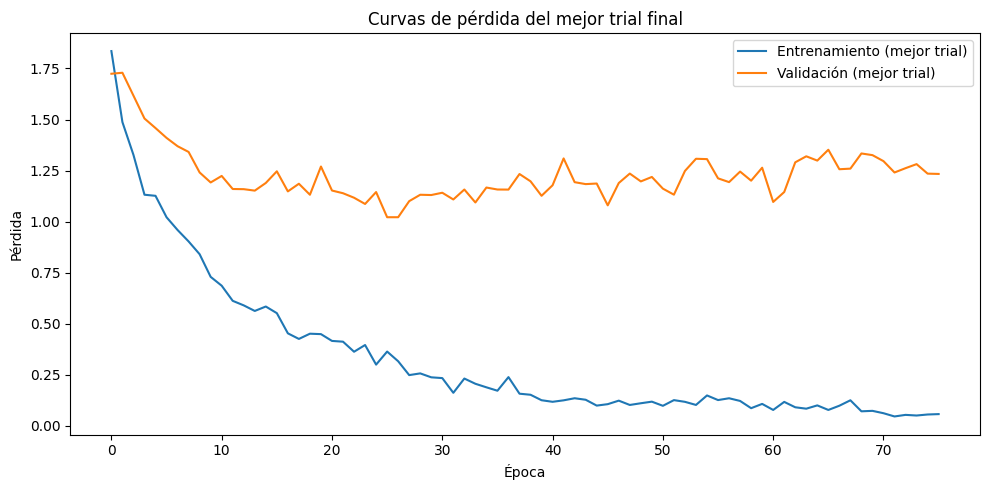

In [71]:
# Graficar las curvas de pérdida de entrenamiento y validación para cada trial de Optuna

import matplotlib.pyplot as plt

# Si quieres graficar las curvas de entrenamiento y validación del mejor trial final:
if 'final_history' in locals():
    plt.figure(figsize=(10, 5))
    plt.plot(final_history['train_loss'], label='Entrenamiento (mejor trial)')
    plt.plot(final_history['val_loss'], label='Validación (mejor trial)')
    plt.title('Curvas de pérdida del mejor trial final')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.tight_layout()
    plt.show()

## Evaluación del Modelo Final y Visualización de Resultados

In [63]:
# Asegurando de que las variables de módulos anteriores estén disponibles
if ('test_loader' not in locals() or test_loader is None or
    'device' not in locals() or
    'FINAL_BEST_MODEL_PATH' not in locals() or not os.path.exists(FINAL_BEST_MODEL_PATH) or
    'idx_to_class' not in locals() or 'num_classes' not in locals() or
    'SimpleCNN' not in locals()):
     print("Error: Variables o componentes de módulos anteriores no encontrados o invalidos para la evaluación.")     
     # Intenta cargar info esencial si el checkpoint existe pero las vars no están en locals()
     if os.path.exists(FINAL_BEST_MODEL_PATH):
         try:
             print(f"Intentando cargar información básica desde el checkpoint final: {FINAL_BEST_MODEL_PATH}")
             temp_checkpoint = torch.load(FINAL_BEST_MODEL_PATH, map_location='cpu') # Cargar a CPU temporalmente
             if 'num_classes' not in locals(): num_classes = temp_checkpoint.get('num_classes')
             if 'idx_to_class' not in locals(): idx_to_class = temp_checkpoint.get('idx_to_class')
             print("Información básica cargada desde checkpoint.")
         except Exception as e:
             print(f"Error al cargar información básica del checkpoint: {e}")

     # Verificar si, tras el intento, aún faltan variables
     if ('test_loader' not in locals() or test_loader is None or 'device' not in locals() or
         'num_classes' not in locals() or num_classes is None or 'idx_to_class' not in locals() or idx_to_class is None or
         'SimpleCNN' not in locals()):
          raise RuntimeError("Faltan componentes necesarios para la evaluación final incluso después de intentar cargar info del checkpoint.")


print(f"\nDispositivo de evaluación: {device}")
print(f"Usando DataLoader de prueba con {len(test_loader.dataset)} muestras.")
print(f"Ruta del mejor modelo FINAL a cargar: {FINAL_BEST_MODEL_PATH}")
print(f"Número de clases (verificado): {num_classes}")


Dispositivo de evaluación: cuda
Usando DataLoader de prueba con 45 muestras.
Ruta del mejor modelo FINAL a cargar: ./Resultados/final_model\final_best_optuna_model.pth
Número de clases (verificado): 6


In [72]:

# Cargar el Mejor Modelo Entrenado con HPs Óptimos
# Intentar cargar el checkpoint del mejor modelo guardado.
print("Cargando el mejor modelo entrenado con HPs óptimos desde el checkpoint final...")

try:
    if 'SimpleCNN' not in locals():
         raise RuntimeError("La clase SimpleCNN no está definida.")

    checkpoint = torch.load(FINAL_BEST_MODEL_PATH, map_location=device)

     #Creamos una variable local 'final_model_eval'.
    final_model_eval = SimpleCNN(num_classes=num_classes)

    # Aplicar HPs del checkpoint si modifican la arquitectura (ej. dropout)
    # Asegurarse de que los HPs fueron guardados en el checkpoint del Módulo 6.
    if 'hps' in checkpoint and checkpoint['hps'] is not None:
         loaded_hps = checkpoint['hps']
         print(f"  HPs cargados desde el checkpoint: {loaded_hps}")
         if 'dropout_rate' in loaded_hps:
              tuned_dropout_rate = loaded_hps['dropout_rate']
              for module in final_model_eval.modules():
                   if isinstance(module, nn.Dropout):
                        module.p = tuned_dropout_rate
              print(f"  Ajustada tasa de dropout en el modelo cargado a: {tuned_dropout_rate:.2f}")
    else:
        print("  Advertencia: HPs no encontrados en el checkpoint final. No se aplicaron ajustes de arquitectura basados en HPs.")


    final_model_eval.load_state_dict(checkpoint['model_state_dict'])

    # Asegurando que el modelo está en el dispositivo correcto
    final_model_eval.to(device)

    # Recuperar información de clases del checkpoint por si acaso
    if 'idx_to_class' in checkpoint:
         idx_to_class = checkpoint['idx_to_class']
    if 'num_classes' in checkpoint:
         num_classes = checkpoint['num_classes']

    print("Mejor modelo de Optuna cargado exitosamente para evaluación.")

except Exception as e:
    print(f"Error FATAL al cargar el checkpoint '{FINAL_BEST_MODEL_PATH}': {e}")
    print("La evaluación no puede continuar sin un modelo cargado.")
    raise # Detener la ejecución si el modelo no se carga

# Asegurarse de que num_classes e idx_to_class están disponibles tras la carga/verificación inicial
if num_classes is None or idx_to_class is None:
     raise RuntimeError("No se pudo obtener la información de clase necesaria para la evaluación.")

target_names = [idx_to_class[i] for i in range(num_classes)]
print(f"Nombres de clases para métricas: {target_names}")

Cargando el mejor modelo entrenado con HPs óptimos desde el checkpoint final...
Tamaño de entrada calculado para la capa lineal: 99200
  HPs cargados desde el checkpoint: {'learning_rate': 0.00521184317157584, 'weight_decay': 5.650703048469157e-06, 'dropout_rate': 0.3950234174474301, 'optimizer': 'SGD', 'momentum': 0.8423390373844803}
  Ajustada tasa de dropout en el modelo cargado a: 0.40
Mejor modelo de Optuna cargado exitosamente para evaluación.
Nombres de clases para métricas: ['ah64', 'chinook', 'cougar', 'f15', 'f16', 'seahawk']


In [73]:
# Evaluación en el Conjunto de prueba
final_model_eval.eval() # Pone el modelo en modo evaluación
print("\nEvaluando el modelo en el conjunto de prueba...")

# Listas para almacenar las etiquetas verdaderas y las predicciones
all_labels = []
all_predictions = []

# Desactivar el cálculo de gradientes para la inferencia
with torch.no_grad():
    # Monitorización de VRAM antes de la evaluación
    if device.type == 'cuda':
        torch.cuda.empty_cache() # Limpiar caché por si acaso
        print(f"  VRAM al inicio de la evaluación: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")

    for i, (inputs, labels) in enumerate(test_loader):
        # Mover datos al dispositivo
        inputs = inputs.to(device)
        # Las etiquetas no necesitan gradientes, pero sí deben estar en el mismo dispositivo si se usan en cálculos intermedios
        # En este caso, las guardaremos para la CPU más tarde.

        # Forward pass
        outputs = final_model_eval(inputs) # Usar el modelo cargado para evaluación

        # Obtener las predicciones (índice de la clase con mayor score)
        _, predicted = torch.max(outputs.data, 1)

        # Mover predicciones y etiquetas a la CPU antes de almacenarlas
        # Esto es CRUCIAL para no agotar la VRAM al acumular todas las predicciones/etiquetas
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy()) # Las etiquetas originales del loader ya pueden estar en CPU, pero mejor asegurar.

# Convertir listas a arrays numpy
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

print("Evaluación completada.")


Evaluando el modelo en el conjunto de prueba...
  VRAM al inicio de la evaluación: 516.82 MB
Evaluación completada.


## Métricas de Evaluación en el Conjunto de Prueba

In [74]:
#Cálculo e Impresión de Métricas de Evaluación

# Precisión general (Accuracy)
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Precisión (Accuracy): {accuracy:.4f}")

# Reporte completo de clasificación (incluye precision, recall, f1-score por clase y promedios)
# target_names son los nombres de las clases en el mismo orden que los índices numéricos (0, 1, 2, ...)

print("\nReporte de Clasificación:")

try:
    print(classification_report(all_labels, all_predictions, target_names=target_names, zero_division=0))
except Exception as e:
     print(f"Error al generar el reporte de clasificación: {e}")
     print("Reporte básico sin target_names:")
     print(classification_report(all_labels, all_predictions, zero_division=0))

Precisión (Accuracy): 0.8000

Reporte de Clasificación:
              precision    recall  f1-score   support

        ah64       0.83      0.71      0.77         7
     chinook       0.71      0.71      0.71         7
      cougar       0.89      1.00      0.94         8
         f15       0.80      0.50      0.62         8
         f16       0.89      1.00      0.94         8
     seahawk       0.67      0.86      0.75         7

    accuracy                           0.80        45
   macro avg       0.80      0.80      0.79        45
weighted avg       0.80      0.80      0.79        45




Matriz de Confusión (numpy array):


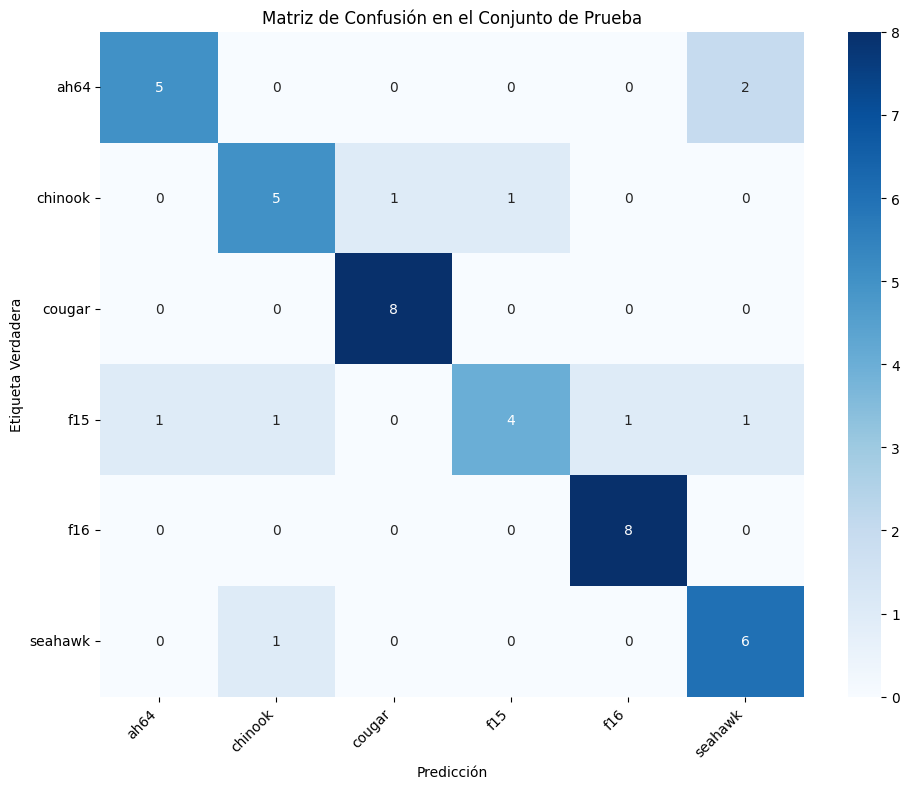

In [67]:
# Matriz de Confusión
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("\nMatriz de Confusión (numpy array):")
# print(conf_matrix) # Imprimir la matriz numpy si quieres

# 4. Visualización de la Matriz de Confusión
plt.figure(figsize=(10, 8))
# Usar seaborn para una visualización más atractiva
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión en el Conjunto de Prueba')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Visualización de Ejemplos de Predicción

Cargando un lote del test_loader para visualización de predicciones...


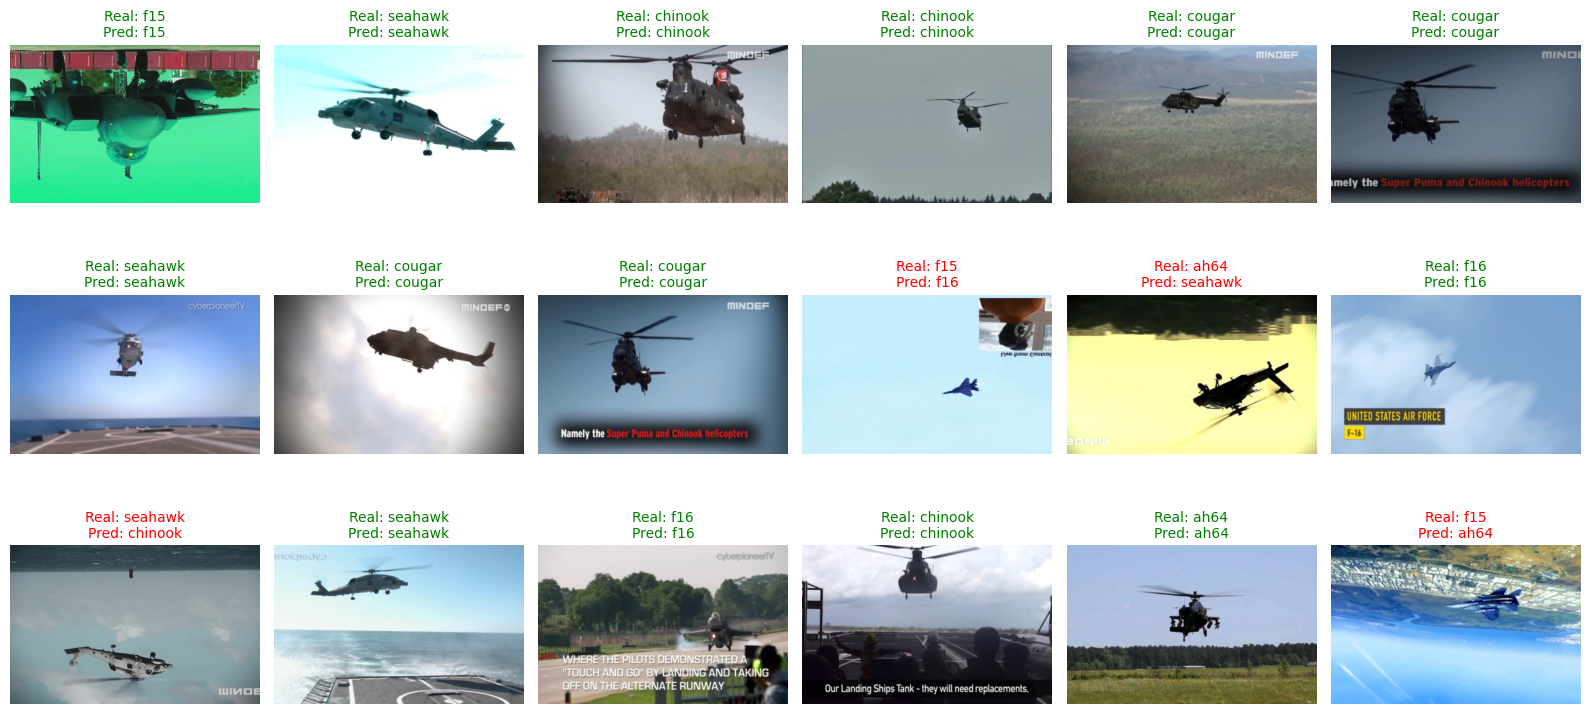

  VRAM después de visualización de ejemplos: 516.82 MB


In [69]:
# Función para de-normalizar una imagen (necesaria si quieres ver la imagen original)
# Esta función asume la media y std de ImageNet que usamos en M2/M3
def denormalize(tensor, mean=mean_list, std=std_list):
    """Denormaliza un tensor de imagen (C, H, W) con media y std dadas."""
    mean = torch.tensor(mean).view(1, 3, 1, 1)
    std = torch.tensor(std).view(1, 3, 1, 1)
    # Asegurarse de que mean y std están en el mismo dispositivo que el tensor
    mean = mean.cpu()
    std = std.cpu()

    # Esta función espera un tensor (C, H, W) o un lote (B, C, H, W)
    if tensor.dim() == 3: # (C, H, W)
         tensor = tensor.unsqueeze(0) # Añadir dimensión de lote temporal
         denorm_tensor = tensor * std + mean
         denorm_tensor = denorm_tensor.squeeze(0) # Eliminar dimensión de lote
    elif tensor.dim() == 4: # (B, C, H, W)
         denorm_tensor = tensor * std + mean
    else:
        raise ValueError("Formato de tensor incorrecto para denormalización. Espera (C, H, W) o (B, C, H, W).")


    # Asegurar que los valores estén en el rango [0, 1] para visualización
    denorm_tensor = torch.clamp(denorm_tensor, 0, 1)
    return denorm_tensor

# Obtener algunas imágenes de ejemplo del test_loader
print("Cargando un lote del test_loader para visualización de predicciones...")
try:
    # Configurar el test_loader para no barajar y tomar el primer lote
    data_iter = iter(test_loader)
    test_images_batch, test_labels_batch = next(data_iter)

    # Hacer predicciones para este lote específico    
    final_model_eval.eval()
    with torch.no_grad():
         # Mover solo el lote actual al dispositivo para la predicción
         batch_images_device = test_images_batch.to(device)
         batch_outputs = final_model_eval(batch_images_device)
         _, batch_predicted = torch.max(batch_outputs.data, 1)
         batch_predicted = batch_predicted.cpu() # Mover predicciones a CPU

    # De-normalizar las imágenes para mostrarlas (pasando el tensor del batch)
    test_images_display_batch = denormalize(test_images_batch)

    # Convertir a numpy para matplotlib y permutar dimensiones (B, C, H, W) -> (B, H, W, C)
    test_images_display_batch = test_images_display_batch.permute(0, 2, 3, 1).numpy()
    test_labels_np = test_labels_batch.numpy()
    batch_predicted_np = batch_predicted.numpy()

    # Mostrar algunas imágenes con sus etiquetas verdaderas y predichas
    # Determinar cuántas imágenes mostrar (ej. un máximo de 18 en 3x6)
    num_images_to_show = min(len(test_images_display_batch), 18)
    fig, axes = plt.subplots(3, 6, figsize=(16, 8)) 
    axes = axes.ravel() # Aplanar la matriz de ejes

    for i in range(num_images_to_show):
        ax = axes[i]
        ax.imshow(test_images_display_batch[i])
        true_class = idx_to_class[test_labels_np[i]]
        predicted_class = idx_to_class[batch_predicted_np[i]]
        color = 'green' if true_class == predicted_class else 'red'
        title = f"Real: {true_class}\nPred: {predicted_class}"
        ax.set_title(title, color=color, fontsize=10) 
        ax.axis('off') # Ocultar ejes

    # Ocultar ejes restantes si mostramos menos de 18 imágenes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    # Liberar tensores
    del data_iter, test_images_batch, test_labels_batch, batch_images_device, batch_outputs, batch_predicted, test_images_display_batch, test_labels_np, batch_predicted_np
    if device.type == 'cuda':
        torch.cuda.empty_cache()
        print(f"  VRAM después de visualización de ejemplos: {torch.cuda.memory_allocated() / (1024**2):.2f} MB")

except Exception as e:
    print(f"\nError al intentar visualizar ejemplos de predicción: {e}")
    print("Asegúrate de que matplotlib, seaborn y torchvision están correctamente instalados y que hay suficientes imágenes en el test_loader.")


# Limpieza de memoria 
gc.collect()
if device.type == 'cuda':
    torch.cuda.empty_cache()